# Sciplex Dose

In [1]:
ood_seed = 1

In [2]:
num_ood = 1

In [3]:
obs_key = "dose_training"

In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('BMS', '10.0'), 153)

Removed datapoint: 153


In [11]:
adata

AnnData object with n_obs × n_vars = 14658 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_cat_ood-seed-{ood_seed}_size-{num_ood}_obs-{obs_key}"
)

In [13]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [14]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [15]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = obs_key,
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [16]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.5,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=False
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=64,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=5e-5,
        weight_decay=1e-2,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: id6086g0
Name: forgotten-speeder-455
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/id6086g0
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_114805-id6086g0/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `training` set. Number of elements in each group: 1751,1574,1402,1741,1449,1423,1401,986
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `validation` set. Number of elements in each group: 404,387,390,430,341,364,366,249
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:08<1:28:48,  8.90s/it]

Epoch 1/600:   0%|          | 1/600 [00:08<1:28:48,  8.90s/it, v_num=g0_1, total_loss_train=2.66e+3, kl_local_train=27.5]

Epoch 2/600:   0%|          | 1/600 [00:08<1:28:48,  8.90s/it, v_num=g0_1, total_loss_train=2.66e+3, kl_local_train=27.5]

Epoch 2/600:   0%|          | 2/600 [00:17<1:26:26,  8.67s/it, v_num=g0_1, total_loss_train=2.66e+3, kl_local_train=27.5]

Epoch 2/600:   0%|          | 2/600 [00:17<1:26:26,  8.67s/it, v_num=g0_1, total_loss_train=2.24e+3, kl_local_train=50.9]

Epoch 3/600:   0%|          | 2/600 [00:17<1:26:26,  8.67s/it, v_num=g0_1, total_loss_train=2.24e+3, kl_local_train=50.9]

Epoch 3/600:   0%|          | 3/600 [00:25<1:25:30,  8.59s/it, v_num=g0_1, total_loss_train=2.24e+3, kl_local_train=50.9]

Epoch 3/600:   0%|          | 3/600 [00:25<1:25:30,  8.59s/it, v_num=g0_1, total_loss_train=2.22e+3, kl_local_train=55.6]

Epoch 4/600:   0%|          | 3/600 [00:25<1:25:30,  8.59s/it, v_num=g0_1, total_loss_train=2.22e+3, kl_local_train=55.6]

Epoch 4/600:   1%|          | 4/600 [00:34<1:24:54,  8.55s/it, v_num=g0_1, total_loss_train=2.22e+3, kl_local_train=55.6]

Epoch 4/600:   1%|          | 4/600 [00:34<1:24:54,  8.55s/it, v_num=g0_1, total_loss_train=2.21e+3, kl_local_train=56.8]

Epoch 5/600:   1%|          | 4/600 [00:34<1:24:54,  8.55s/it, v_num=g0_1, total_loss_train=2.21e+3, kl_local_train=56.8]

Epoch 5/600:   1%|          | 5/600 [00:43<1:26:12,  8.69s/it, v_num=g0_1, total_loss_train=2.21e+3, kl_local_train=56.8]

Epoch 5/600:   1%|          | 5/600 [00:43<1:26:12,  8.69s/it, v_num=g0_1, total_loss_train=2.21e+3, kl_local_train=55.5]

Epoch 6/600:   1%|          | 5/600 [00:43<1:26:12,  8.69s/it, v_num=g0_1, total_loss_train=2.21e+3, kl_local_train=55.5]

Epoch 6/600:   1%|          | 6/600 [00:51<1:23:58,  8.48s/it, v_num=g0_1, total_loss_train=2.21e+3, kl_local_train=55.5]

Epoch 6/600:   1%|          | 6/600 [00:51<1:23:58,  8.48s/it, v_num=g0_1, total_loss_train=2.21e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0385, metric_mi|condition_train=0.0298]

Epoch 7/600:   1%|          | 6/600 [00:51<1:23:58,  8.48s/it, v_num=g0_1, total_loss_train=2.21e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0385, metric_mi|condition_train=0.0298]

Epoch 7/600:   1%|          | 7/600 [00:58<1:20:49,  8.18s/it, v_num=g0_1, total_loss_train=2.21e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0385, metric_mi|condition_train=0.0298]

Epoch 7/600:   1%|          | 7/600 [00:58<1:20:49,  8.18s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0385, metric_mi|condition_train=0.0298]

Epoch 8/600:   1%|          | 7/600 [00:58<1:20:49,  8.18s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0385, metric_mi|condition_train=0.0298]

Epoch 8/600:   1%|▏         | 8/600 [01:06<1:18:39,  7.97s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0385, metric_mi|condition_train=0.0298]

Epoch 8/600:   1%|▏         | 8/600 [01:06<1:18:39,  7.97s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0385, metric_mi|condition_train=0.0298]

Epoch 9/600:   1%|▏         | 8/600 [01:06<1:18:39,  7.97s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0385, metric_mi|condition_train=0.0298]

Epoch 9/600:   2%|▏         | 9/600 [01:14<1:17:09,  7.83s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0385, metric_mi|condition_train=0.0298]

Epoch 9/600:   2%|▏         | 9/600 [01:14<1:17:09,  7.83s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0385, metric_mi|condition_train=0.0298]

Epoch 10/600:   2%|▏         | 9/600 [01:14<1:17:09,  7.83s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0385, metric_mi|condition_train=0.0298]

Epoch 10/600:   2%|▏         | 10/600 [01:21<1:17:18,  7.86s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0385, metric_mi|condition_train=0.0298]

Epoch 10/600:   2%|▏         | 10/600 [01:21<1:17:18,  7.86s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0385, metric_mi|condition_train=0.0298]

Epoch 11/600:   2%|▏         | 10/600 [01:22<1:17:18,  7.86s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0385, metric_mi|condition_train=0.0298]

Epoch 11/600:   2%|▏         | 11/600 [01:30<1:18:10,  7.96s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0385, metric_mi|condition_train=0.0298]

Epoch 11/600:   2%|▏         | 11/600 [01:30<1:18:10,  7.96s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0566, metric_mi|condition_train=0.145] 

Epoch 12/600:   2%|▏         | 11/600 [01:30<1:18:10,  7.96s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0566, metric_mi|condition_train=0.145]

Epoch 12/600:   2%|▏         | 12/600 [01:37<1:17:18,  7.89s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0566, metric_mi|condition_train=0.145]

Epoch 12/600:   2%|▏         | 12/600 [01:37<1:17:18,  7.89s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0566, metric_mi|condition_train=0.145]

Epoch 13/600:   2%|▏         | 12/600 [01:37<1:17:18,  7.89s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0566, metric_mi|condition_train=0.145]

Epoch 13/600:   2%|▏         | 13/600 [01:45<1:16:37,  7.83s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0566, metric_mi|condition_train=0.145]

Epoch 13/600:   2%|▏         | 13/600 [01:45<1:16:37,  7.83s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0566, metric_mi|condition_train=0.145]

Epoch 14/600:   2%|▏         | 13/600 [01:45<1:16:37,  7.83s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0566, metric_mi|condition_train=0.145]

Epoch 14/600:   2%|▏         | 14/600 [01:53<1:16:03,  7.79s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0566, metric_mi|condition_train=0.145]

Epoch 14/600:   2%|▏         | 14/600 [01:53<1:16:03,  7.79s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0566, metric_mi|condition_train=0.145]

Epoch 15/600:   2%|▏         | 14/600 [01:53<1:16:03,  7.79s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0566, metric_mi|condition_train=0.145]

Epoch 15/600:   2%|▎         | 15/600 [02:01<1:16:38,  7.86s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0566, metric_mi|condition_train=0.145]

Epoch 15/600:   2%|▎         | 15/600 [02:01<1:16:38,  7.86s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0566, metric_mi|condition_train=0.145]

Epoch 16/600:   2%|▎         | 15/600 [02:01<1:16:38,  7.86s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0566, metric_mi|condition_train=0.145]

Epoch 16/600:   3%|▎         | 16/600 [02:09<1:17:23,  7.95s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0566, metric_mi|condition_train=0.145]

Epoch 16/600:   3%|▎         | 16/600 [02:09<1:17:23,  7.95s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0579, metric_mi|condition_train=0.136]

Epoch 17/600:   3%|▎         | 16/600 [02:09<1:17:23,  7.95s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0579, metric_mi|condition_train=0.136]

Epoch 17/600:   3%|▎         | 17/600 [02:17<1:16:34,  7.88s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0579, metric_mi|condition_train=0.136]

Epoch 17/600:   3%|▎         | 17/600 [02:17<1:16:34,  7.88s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0579, metric_mi|condition_train=0.136]

Epoch 18/600:   3%|▎         | 17/600 [02:17<1:16:34,  7.88s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0579, metric_mi|condition_train=0.136]

Epoch 18/600:   3%|▎         | 18/600 [02:24<1:15:56,  7.83s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0579, metric_mi|condition_train=0.136]

Epoch 18/600:   3%|▎         | 18/600 [02:24<1:15:56,  7.83s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0579, metric_mi|condition_train=0.136]

Epoch 19/600:   3%|▎         | 18/600 [02:24<1:15:56,  7.83s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0579, metric_mi|condition_train=0.136]

Epoch 19/600:   3%|▎         | 19/600 [02:32<1:15:27,  7.79s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0579, metric_mi|condition_train=0.136]

Epoch 19/600:   3%|▎         | 19/600 [02:32<1:15:27,  7.79s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0579, metric_mi|condition_train=0.136]

Epoch 20/600:   3%|▎         | 19/600 [02:32<1:15:27,  7.79s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0579, metric_mi|condition_train=0.136]

Epoch 20/600:   3%|▎         | 20/600 [02:41<1:18:15,  8.10s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0579, metric_mi|condition_train=0.136]

Epoch 20/600:   3%|▎         | 20/600 [02:41<1:18:15,  8.10s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=39, metric_mi|dose_training_train=0.0579, metric_mi|condition_train=0.136]  

Epoch 21/600:   3%|▎         | 20/600 [02:41<1:18:15,  8.10s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=39, metric_mi|dose_training_train=0.0579, metric_mi|condition_train=0.136]

Epoch 21/600:   4%|▎         | 21/600 [02:49<1:18:07,  8.10s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=39, metric_mi|dose_training_train=0.0579, metric_mi|condition_train=0.136]

Epoch 21/600:   4%|▎         | 21/600 [02:49<1:18:07,  8.10s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.119]

Epoch 22/600:   4%|▎         | 21/600 [02:49<1:18:07,  8.10s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.119]

Epoch 22/600:   4%|▎         | 22/600 [02:57<1:16:41,  7.96s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.119]

Epoch 22/600:   4%|▎         | 22/600 [02:57<1:16:41,  7.96s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.119]

Epoch 23/600:   4%|▎         | 22/600 [02:57<1:16:41,  7.96s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.119]

Epoch 23/600:   4%|▍         | 23/600 [03:04<1:15:38,  7.87s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.119]

Epoch 23/600:   4%|▍         | 23/600 [03:04<1:15:38,  7.87s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.119]

Epoch 24/600:   4%|▍         | 23/600 [03:04<1:15:38,  7.87s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.119]

Epoch 24/600:   4%|▍         | 24/600 [03:12<1:14:52,  7.80s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.119]

Epoch 24/600:   4%|▍         | 24/600 [03:12<1:14:52,  7.80s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.119]

Epoch 25/600:   4%|▍         | 24/600 [03:12<1:14:52,  7.80s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.119]

Epoch 25/600:   4%|▍         | 25/600 [03:20<1:15:39,  7.90s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.119]

Epoch 25/600:   4%|▍         | 25/600 [03:20<1:15:39,  7.90s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.119]

Epoch 26/600:   4%|▍         | 25/600 [03:20<1:15:39,  7.90s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.119]

Epoch 26/600:   4%|▍         | 26/600 [03:28<1:16:03,  7.95s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.119]

Epoch 26/600:   4%|▍         | 26/600 [03:28<1:16:03,  7.95s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.109]

Epoch 27/600:   4%|▍         | 26/600 [03:28<1:16:03,  7.95s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.109]

Epoch 27/600:   4%|▍         | 27/600 [03:36<1:15:04,  7.86s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.109]

Epoch 27/600:   4%|▍         | 27/600 [03:36<1:15:04,  7.86s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=39, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.109]  

Epoch 28/600:   4%|▍         | 27/600 [03:36<1:15:04,  7.86s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=39, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.109]

Epoch 28/600:   5%|▍         | 28/600 [03:43<1:14:19,  7.80s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=39, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.109]

Epoch 28/600:   5%|▍         | 28/600 [03:43<1:14:19,  7.80s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.109]

Epoch 29/600:   5%|▍         | 28/600 [03:43<1:14:19,  7.80s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.109]

Epoch 29/600:   5%|▍         | 29/600 [03:51<1:13:46,  7.75s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.109]

Epoch 29/600:   5%|▍         | 29/600 [03:51<1:13:46,  7.75s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.109]

Epoch 30/600:   5%|▍         | 29/600 [03:51<1:13:46,  7.75s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.109]

Epoch 30/600:   5%|▌         | 30/600 [03:59<1:15:35,  7.96s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.109]

Epoch 30/600:   5%|▌         | 30/600 [03:59<1:15:35,  7.96s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.109]

Epoch 31/600:   5%|▌         | 30/600 [04:00<1:15:35,  7.96s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.109]

Epoch 31/600:   5%|▌         | 31/600 [04:08<1:15:49,  7.99s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0559, metric_mi|condition_train=0.109]

Epoch 31/600:   5%|▌         | 31/600 [04:08<1:15:49,  7.99s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0563, metric_mi|condition_train=0.0978]

Epoch 32/600:   5%|▌         | 31/600 [04:08<1:15:49,  7.99s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0563, metric_mi|condition_train=0.0978]

Epoch 32/600:   5%|▌         | 32/600 [04:15<1:14:42,  7.89s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0563, metric_mi|condition_train=0.0978]

Epoch 32/600:   5%|▌         | 32/600 [04:15<1:14:42,  7.89s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0563, metric_mi|condition_train=0.0978]

Epoch 33/600:   5%|▌         | 32/600 [04:15<1:14:42,  7.89s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0563, metric_mi|condition_train=0.0978]

Epoch 33/600:   6%|▌         | 33/600 [04:23<1:13:59,  7.83s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0563, metric_mi|condition_train=0.0978]

Epoch 33/600:   6%|▌         | 33/600 [04:23<1:13:59,  7.83s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0563, metric_mi|condition_train=0.0978]

Epoch 34/600:   6%|▌         | 33/600 [04:23<1:13:59,  7.83s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0563, metric_mi|condition_train=0.0978]

Epoch 34/600:   6%|▌         | 34/600 [04:31<1:13:29,  7.79s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0563, metric_mi|condition_train=0.0978]

Epoch 34/600:   6%|▌         | 34/600 [04:31<1:13:29,  7.79s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=45, metric_mi|dose_training_train=0.0563, metric_mi|condition_train=0.0978]  

Epoch 35/600:   6%|▌         | 34/600 [04:31<1:13:29,  7.79s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=45, metric_mi|dose_training_train=0.0563, metric_mi|condition_train=0.0978]

Epoch 35/600:   6%|▌         | 35/600 [04:39<1:13:56,  7.85s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=45, metric_mi|dose_training_train=0.0563, metric_mi|condition_train=0.0978]

Epoch 35/600:   6%|▌         | 35/600 [04:39<1:13:56,  7.85s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0563, metric_mi|condition_train=0.0978]

Epoch 36/600:   6%|▌         | 35/600 [04:39<1:13:56,  7.85s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0563, metric_mi|condition_train=0.0978]

Epoch 36/600:   6%|▌         | 36/600 [04:47<1:14:33,  7.93s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0563, metric_mi|condition_train=0.0978]

Epoch 36/600:   6%|▌         | 36/600 [04:47<1:14:33,  7.93s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.057, metric_mi|condition_train=0.0902] 

Epoch 37/600:   6%|▌         | 36/600 [04:47<1:14:33,  7.93s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.057, metric_mi|condition_train=0.0902]

Epoch 37/600:   6%|▌         | 37/600 [04:54<1:13:55,  7.88s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.057, metric_mi|condition_train=0.0902]

Epoch 37/600:   6%|▌         | 37/600 [04:54<1:13:55,  7.88s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=47, metric_mi|dose_training_train=0.057, metric_mi|condition_train=0.0902]  

Epoch 38/600:   6%|▌         | 37/600 [04:54<1:13:55,  7.88s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=47, metric_mi|dose_training_train=0.057, metric_mi|condition_train=0.0902]

Epoch 38/600:   6%|▋         | 38/600 [05:02<1:13:17,  7.82s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=47, metric_mi|dose_training_train=0.057, metric_mi|condition_train=0.0902]

Epoch 38/600:   6%|▋         | 38/600 [05:02<1:13:17,  7.82s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.057, metric_mi|condition_train=0.0902]

Epoch 39/600:   6%|▋         | 38/600 [05:02<1:13:17,  7.82s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.057, metric_mi|condition_train=0.0902]

Epoch 39/600:   6%|▋         | 39/600 [05:10<1:13:16,  7.84s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.057, metric_mi|condition_train=0.0902]

Epoch 39/600:   6%|▋         | 39/600 [05:10<1:13:16,  7.84s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.057, metric_mi|condition_train=0.0902]

Epoch 40/600:   6%|▋         | 39/600 [05:10<1:13:16,  7.84s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.057, metric_mi|condition_train=0.0902]

Epoch 40/600:   7%|▋         | 40/600 [05:19<1:14:55,  8.03s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.057, metric_mi|condition_train=0.0902]

Epoch 40/600:   7%|▋         | 40/600 [05:19<1:14:55,  8.03s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.057, metric_mi|condition_train=0.0902]

Epoch 41/600:   7%|▋         | 40/600 [05:19<1:14:55,  8.03s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.057, metric_mi|condition_train=0.0902]

Epoch 41/600:   7%|▋         | 41/600 [05:27<1:14:46,  8.03s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.057, metric_mi|condition_train=0.0902]

Epoch 41/600:   7%|▋         | 41/600 [05:27<1:14:46,  8.03s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0578, metric_mi|condition_train=0.0852]

Epoch 42/600:   7%|▋         | 41/600 [05:27<1:14:46,  8.03s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0578, metric_mi|condition_train=0.0852]

Epoch 42/600:   7%|▋         | 42/600 [05:34<1:13:25,  7.89s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0578, metric_mi|condition_train=0.0852]

Epoch 42/600:   7%|▋         | 42/600 [05:34<1:13:25,  7.89s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=50, metric_mi|dose_training_train=0.0578, metric_mi|condition_train=0.0852]  

Epoch 43/600:   7%|▋         | 42/600 [05:34<1:13:25,  7.89s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=50, metric_mi|dose_training_train=0.0578, metric_mi|condition_train=0.0852]

Epoch 43/600:   7%|▋         | 43/600 [05:42<1:12:24,  7.80s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=50, metric_mi|dose_training_train=0.0578, metric_mi|condition_train=0.0852]

Epoch 43/600:   7%|▋         | 43/600 [05:42<1:12:24,  7.80s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0578, metric_mi|condition_train=0.0852]

Epoch 44/600:   7%|▋         | 43/600 [05:42<1:12:24,  7.80s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0578, metric_mi|condition_train=0.0852]

Epoch 44/600:   7%|▋         | 44/600 [05:49<1:11:40,  7.74s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0578, metric_mi|condition_train=0.0852]

Epoch 44/600:   7%|▋         | 44/600 [05:49<1:11:40,  7.74s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0578, metric_mi|condition_train=0.0852]

Epoch 45/600:   7%|▋         | 44/600 [05:49<1:11:40,  7.74s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0578, metric_mi|condition_train=0.0852]

Epoch 45/600:   8%|▊         | 45/600 [05:58<1:13:23,  7.93s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0578, metric_mi|condition_train=0.0852]

Epoch 45/600:   8%|▊         | 45/600 [05:58<1:13:23,  7.93s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0578, metric_mi|condition_train=0.0852]

Epoch 46/600:   8%|▊         | 45/600 [05:58<1:13:23,  7.93s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0578, metric_mi|condition_train=0.0852]

Epoch 46/600:   8%|▊         | 46/600 [06:06<1:13:27,  7.96s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0578, metric_mi|condition_train=0.0852]

Epoch 46/600:   8%|▊         | 46/600 [06:06<1:13:27,  7.96s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.0823]

Epoch 47/600:   8%|▊         | 46/600 [06:06<1:13:27,  7.96s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.0823]

Epoch 47/600:   8%|▊         | 47/600 [06:13<1:12:15,  7.84s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.0823]

Epoch 47/600:   8%|▊         | 47/600 [06:13<1:12:15,  7.84s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.0823]

Epoch 48/600:   8%|▊         | 47/600 [06:13<1:12:15,  7.84s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.0823]

Epoch 48/600:   8%|▊         | 48/600 [06:21<1:11:22,  7.76s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.0823]

Epoch 48/600:   8%|▊         | 48/600 [06:21<1:11:22,  7.76s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.0823]

Epoch 49/600:   8%|▊         | 48/600 [06:21<1:11:22,  7.76s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.0823]

Epoch 49/600:   8%|▊         | 49/600 [06:28<1:10:40,  7.70s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.0823]

Epoch 49/600:   8%|▊         | 49/600 [06:28<1:10:40,  7.70s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.0823]

Epoch 50/600:   8%|▊         | 49/600 [06:28<1:10:40,  7.70s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.0823]

Epoch 50/600:   8%|▊         | 50/600 [06:36<1:10:48,  7.73s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.0823]

Epoch 50/600:   8%|▊         | 50/600 [06:36<1:10:48,  7.73s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.0823]

Epoch 51/600:   8%|▊         | 50/600 [06:37<1:10:48,  7.73s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.0823]

Epoch 51/600:   8%|▊         | 51/600 [06:44<1:11:23,  7.80s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.0823]

Epoch 51/600:   8%|▊         | 51/600 [06:44<1:11:23,  7.80s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0584, metric_mi|condition_train=0.0788]

Epoch 52/600:   8%|▊         | 51/600 [06:44<1:11:23,  7.80s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0584, metric_mi|condition_train=0.0788]

Epoch 52/600:   9%|▊         | 52/600 [06:52<1:10:33,  7.73s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0584, metric_mi|condition_train=0.0788]

Epoch 52/600:   9%|▊         | 52/600 [06:52<1:10:33,  7.73s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53, metric_mi|dose_training_train=0.0584, metric_mi|condition_train=0.0788]  

Epoch 53/600:   9%|▊         | 52/600 [06:52<1:10:33,  7.73s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53, metric_mi|dose_training_train=0.0584, metric_mi|condition_train=0.0788]

Epoch 53/600:   9%|▉         | 53/600 [06:59<1:09:57,  7.67s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53, metric_mi|dose_training_train=0.0584, metric_mi|condition_train=0.0788]

Epoch 53/600:   9%|▉         | 53/600 [06:59<1:09:57,  7.67s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0584, metric_mi|condition_train=0.0788]

Epoch 54/600:   9%|▉         | 53/600 [06:59<1:09:57,  7.67s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0584, metric_mi|condition_train=0.0788]

Epoch 54/600:   9%|▉         | 54/600 [07:07<1:09:29,  7.64s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0584, metric_mi|condition_train=0.0788]

Epoch 54/600:   9%|▉         | 54/600 [07:07<1:09:29,  7.64s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0584, metric_mi|condition_train=0.0788]

Epoch 55/600:   9%|▉         | 54/600 [07:07<1:09:29,  7.64s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0584, metric_mi|condition_train=0.0788]

Epoch 55/600:   9%|▉         | 55/600 [07:15<1:09:45,  7.68s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0584, metric_mi|condition_train=0.0788]

Epoch 55/600:   9%|▉         | 55/600 [07:15<1:09:45,  7.68s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0584, metric_mi|condition_train=0.0788]

Epoch 56/600:   9%|▉         | 55/600 [07:15<1:09:45,  7.68s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0584, metric_mi|condition_train=0.0788]

Epoch 56/600:   9%|▉         | 56/600 [07:23<1:10:28,  7.77s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0584, metric_mi|condition_train=0.0788]

Epoch 56/600:   9%|▉         | 56/600 [07:23<1:10:28,  7.77s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.0762]

Epoch 57/600:   9%|▉         | 56/600 [07:23<1:10:28,  7.77s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.0762]

Epoch 57/600:  10%|▉         | 57/600 [07:30<1:09:43,  7.71s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.0762]

Epoch 57/600:  10%|▉         | 57/600 [07:30<1:09:43,  7.71s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.0762]

Epoch 58/600:  10%|▉         | 57/600 [07:30<1:09:43,  7.71s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.0762]

Epoch 58/600:  10%|▉         | 58/600 [07:38<1:09:12,  7.66s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.0762]

Epoch 58/600:  10%|▉         | 58/600 [07:38<1:09:12,  7.66s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.0762]

Epoch 59/600:  10%|▉         | 58/600 [07:38<1:09:12,  7.66s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.0762]

Epoch 59/600:  10%|▉         | 59/600 [07:45<1:08:51,  7.64s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.0762]

Epoch 59/600:  10%|▉         | 59/600 [07:45<1:08:51,  7.64s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.0762]

Epoch 60/600:  10%|▉         | 59/600 [07:45<1:08:51,  7.64s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.0762]

Epoch 60/600:  10%|█         | 60/600 [07:53<1:09:05,  7.68s/it, v_num=g0_1, total_loss_train=2.19e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.0762]

Epoch 60/600:  10%|█         | 60/600 [07:53<1:09:05,  7.68s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.0762]

Epoch 61/600:  10%|█         | 60/600 [07:53<1:09:05,  7.68s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.0762]

Epoch 61/600:  10%|█         | 61/600 [08:01<1:09:48,  7.77s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0587, metric_mi|condition_train=0.0762]

Epoch 61/600:  10%|█         | 61/600 [08:01<1:09:48,  7.77s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.075]   

Epoch 62/600:  10%|█         | 61/600 [08:01<1:09:48,  7.77s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.075]

Epoch 62/600:  10%|█         | 62/600 [08:09<1:09:08,  7.71s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.075]

Epoch 62/600:  10%|█         | 62/600 [08:09<1:09:08,  7.71s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.075]

Epoch 63/600:  10%|█         | 62/600 [08:09<1:09:08,  7.71s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.075]

Epoch 63/600:  10%|█         | 63/600 [08:16<1:08:38,  7.67s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.075]

Epoch 63/600:  10%|█         | 63/600 [08:16<1:08:38,  7.67s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.075]

Epoch 64/600:  10%|█         | 63/600 [08:16<1:08:38,  7.67s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.075]

Epoch 64/600:  11%|█         | 64/600 [08:24<1:08:13,  7.64s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.075]

Epoch 64/600:  11%|█         | 64/600 [08:24<1:08:13,  7.64s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=55, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.075]  

Epoch 65/600:  11%|█         | 64/600 [08:24<1:08:13,  7.64s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=55, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.075]

Epoch 65/600:  11%|█         | 65/600 [08:32<1:08:30,  7.68s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=55, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.075]

Epoch 65/600:  11%|█         | 65/600 [08:32<1:08:30,  7.68s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.075]

Epoch 66/600:  11%|█         | 65/600 [08:32<1:08:30,  7.68s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.075]

Epoch 66/600:  11%|█         | 66/600 [08:40<1:09:12,  7.78s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.075]

Epoch 66/600:  11%|█         | 66/600 [08:40<1:09:12,  7.78s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0752]

Epoch 67/600:  11%|█         | 66/600 [08:40<1:09:12,  7.78s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0752]

Epoch 67/600:  11%|█         | 67/600 [08:47<1:08:46,  7.74s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0752]

Epoch 67/600:  11%|█         | 67/600 [08:47<1:08:46,  7.74s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0752]

Epoch 68/600:  11%|█         | 67/600 [08:47<1:08:46,  7.74s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0752]

Epoch 68/600:  11%|█▏        | 68/600 [08:55<1:08:07,  7.68s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0752]

Epoch 68/600:  11%|█▏        | 68/600 [08:55<1:08:07,  7.68s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0752]

Epoch 69/600:  11%|█▏        | 68/600 [08:55<1:08:07,  7.68s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0752]

Epoch 69/600:  12%|█▏        | 69/600 [09:02<1:07:39,  7.65s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0752]

Epoch 69/600:  12%|█▏        | 69/600 [09:02<1:07:39,  7.65s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0752]

Epoch 70/600:  12%|█▏        | 69/600 [09:02<1:07:39,  7.65s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0752]

Epoch 70/600:  12%|█▏        | 70/600 [09:10<1:08:19,  7.73s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0752]

Epoch 70/600:  12%|█▏        | 70/600 [09:10<1:08:19,  7.73s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0752]

Epoch 71/600:  12%|█▏        | 70/600 [09:11<1:08:19,  7.73s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0752]

Epoch 71/600:  12%|█▏        | 71/600 [09:18<1:08:52,  7.81s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0752]

Epoch 71/600:  12%|█▏        | 71/600 [09:18<1:08:52,  7.81s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.075]  

Epoch 72/600:  12%|█▏        | 71/600 [09:18<1:08:52,  7.81s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.075]

Epoch 72/600:  12%|█▏        | 72/600 [09:26<1:08:05,  7.74s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.075]

Epoch 72/600:  12%|█▏        | 72/600 [09:26<1:08:05,  7.74s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.075]

Epoch 73/600:  12%|█▏        | 72/600 [09:26<1:08:05,  7.74s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.075]

Epoch 73/600:  12%|█▏        | 73/600 [09:33<1:07:35,  7.69s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.075]

Epoch 73/600:  12%|█▏        | 73/600 [09:33<1:07:35,  7.69s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=56, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.075]  

Epoch 74/600:  12%|█▏        | 73/600 [09:33<1:07:35,  7.69s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=56, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.075]

Epoch 74/600:  12%|█▏        | 74/600 [09:41<1:07:05,  7.65s/it, v_num=g0_1, total_loss_train=2.18e+3, kl_local_train=56, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.075]

Epoch 74/600:  12%|█▏        | 74/600 [09:41<1:07:05,  7.65s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.075]

Epoch 75/600:  12%|█▏        | 74/600 [09:41<1:07:05,  7.65s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.075]

Epoch 75/600:  12%|█▎        | 75/600 [09:49<1:08:55,  7.88s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.075]

Epoch 75/600:  12%|█▎        | 75/600 [09:49<1:08:55,  7.88s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.075]

Epoch 76/600:  12%|█▎        | 75/600 [09:50<1:08:55,  7.88s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.075]

Epoch 76/600:  13%|█▎        | 76/600 [09:57<1:09:19,  7.94s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.075]

Epoch 76/600:  13%|█▎        | 76/600 [09:57<1:09:19,  7.94s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0751]

Epoch 77/600:  13%|█▎        | 76/600 [09:57<1:09:19,  7.94s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0751]

Epoch 77/600:  13%|█▎        | 77/600 [10:05<1:08:35,  7.87s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0751]

Epoch 77/600:  13%|█▎        | 77/600 [10:05<1:08:35,  7.87s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0751]

Epoch 78/600:  13%|█▎        | 77/600 [10:05<1:08:35,  7.87s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0751]

Epoch 78/600:  13%|█▎        | 78/600 [10:13<1:08:07,  7.83s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0751]

Epoch 78/600:  13%|█▎        | 78/600 [10:13<1:08:07,  7.83s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0751]

Epoch 79/600:  13%|█▎        | 78/600 [10:13<1:08:07,  7.83s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0751]

Epoch 79/600:  13%|█▎        | 79/600 [10:21<1:07:39,  7.79s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0751]

Epoch 79/600:  13%|█▎        | 79/600 [10:21<1:07:39,  7.79s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0751]

Epoch 80/600:  13%|█▎        | 79/600 [10:21<1:07:39,  7.79s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0751]

Epoch 80/600:  13%|█▎        | 80/600 [10:28<1:07:47,  7.82s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0751]

Epoch 80/600:  13%|█▎        | 80/600 [10:28<1:07:47,  7.82s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0751]

Epoch 81/600:  13%|█▎        | 80/600 [10:29<1:07:47,  7.82s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0751]

Epoch 81/600:  14%|█▎        | 81/600 [10:36<1:08:13,  7.89s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0751]

Epoch 81/600:  14%|█▎        | 81/600 [10:36<1:08:13,  7.89s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0749]

Epoch 82/600:  14%|█▎        | 81/600 [10:36<1:08:13,  7.89s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0749]

Epoch 82/600:  14%|█▎        | 82/600 [10:44<1:07:22,  7.80s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0749]

Epoch 82/600:  14%|█▎        | 82/600 [10:44<1:07:22,  7.80s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0749]

Epoch 83/600:  14%|█▎        | 82/600 [10:44<1:07:22,  7.80s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0749]

Epoch 83/600:  14%|█▍        | 83/600 [10:52<1:06:43,  7.74s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0749]

Epoch 83/600:  14%|█▍        | 83/600 [10:52<1:06:43,  7.74s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0749]

Epoch 84/600:  14%|█▍        | 83/600 [10:52<1:06:43,  7.74s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0749]

Epoch 84/600:  14%|█▍        | 84/600 [10:59<1:06:14,  7.70s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0749]

Epoch 84/600:  14%|█▍        | 84/600 [10:59<1:06:14,  7.70s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0749]

Epoch 85/600:  14%|█▍        | 84/600 [10:59<1:06:14,  7.70s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0749]

Epoch 85/600:  14%|█▍        | 85/600 [11:07<1:06:24,  7.74s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0749]

Epoch 85/600:  14%|█▍        | 85/600 [11:07<1:06:24,  7.74s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=57, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0749]  

Epoch 86/600:  14%|█▍        | 85/600 [11:08<1:06:24,  7.74s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=57, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0749]

Epoch 86/600:  14%|█▍        | 86/600 [11:15<1:07:14,  7.85s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=57, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0749]

Epoch 86/600:  14%|█▍        | 86/600 [11:15<1:07:14,  7.85s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0737]

Epoch 87/600:  14%|█▍        | 86/600 [11:15<1:07:14,  7.85s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0737]

Epoch 87/600:  14%|█▍        | 87/600 [11:23<1:06:36,  7.79s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0737]

Epoch 87/600:  14%|█▍        | 87/600 [11:23<1:06:36,  7.79s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0737]

Epoch 88/600:  14%|█▍        | 87/600 [11:23<1:06:36,  7.79s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0737]

Epoch 88/600:  15%|█▍        | 88/600 [11:31<1:06:10,  7.75s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0737]

Epoch 88/600:  15%|█▍        | 88/600 [11:31<1:06:10,  7.75s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=55, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0737]  

Epoch 89/600:  15%|█▍        | 88/600 [11:31<1:06:10,  7.75s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=55, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0737]

Epoch 89/600:  15%|█▍        | 89/600 [11:38<1:05:47,  7.72s/it, v_num=g0_1, total_loss_train=2.17e+3, kl_local_train=55, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0737]

Epoch 89/600:  15%|█▍        | 89/600 [11:38<1:05:47,  7.72s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0737]

Epoch 90/600:  15%|█▍        | 89/600 [11:38<1:05:47,  7.72s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0737]

Epoch 90/600:  15%|█▌        | 90/600 [11:46<1:06:01,  7.77s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0737]

Epoch 90/600:  15%|█▌        | 90/600 [11:46<1:06:01,  7.77s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0737]

Epoch 91/600:  15%|█▌        | 90/600 [11:47<1:06:01,  7.77s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0737]

Epoch 91/600:  15%|█▌        | 91/600 [11:54<1:06:42,  7.86s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0737]

Epoch 91/600:  15%|█▌        | 91/600 [11:54<1:06:42,  7.86s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.0721]

Epoch 92/600:  15%|█▌        | 91/600 [11:54<1:06:42,  7.86s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.0721]

Epoch 92/600:  15%|█▌        | 92/600 [12:02<1:06:03,  7.80s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.0721]

Epoch 92/600:  15%|█▌        | 92/600 [12:02<1:06:03,  7.80s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.0721]

Epoch 93/600:  15%|█▌        | 92/600 [12:02<1:06:03,  7.80s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.0721]

Epoch 93/600:  16%|█▌        | 93/600 [12:09<1:05:32,  7.76s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.0721]

Epoch 93/600:  16%|█▌        | 93/600 [12:09<1:05:32,  7.76s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.0721]

Epoch 94/600:  16%|█▌        | 93/600 [12:09<1:05:32,  7.76s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.0721]

Epoch 94/600:  16%|█▌        | 94/600 [12:17<1:05:11,  7.73s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.0721]

Epoch 94/600:  16%|█▌        | 94/600 [12:17<1:05:11,  7.73s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.0721]

Epoch 95/600:  16%|█▌        | 94/600 [12:17<1:05:11,  7.73s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.0721]

Epoch 95/600:  16%|█▌        | 95/600 [12:25<1:05:24,  7.77s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.0721]

Epoch 95/600:  16%|█▌        | 95/600 [12:25<1:05:24,  7.77s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.0721]

Epoch 96/600:  16%|█▌        | 95/600 [12:25<1:05:24,  7.77s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.0721]

Epoch 96/600:  16%|█▌        | 96/600 [12:33<1:06:07,  7.87s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.0721]

Epoch 96/600:  16%|█▌        | 96/600 [12:33<1:06:07,  7.87s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.071] 

Epoch 97/600:  16%|█▌        | 96/600 [12:33<1:06:07,  7.87s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.071]

Epoch 97/600:  16%|█▌        | 97/600 [12:41<1:05:27,  7.81s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.071]

Epoch 97/600:  16%|█▌        | 97/600 [12:41<1:05:27,  7.81s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.071]

Epoch 98/600:  16%|█▌        | 97/600 [12:41<1:05:27,  7.81s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.071]

Epoch 98/600:  16%|█▋        | 98/600 [12:48<1:04:58,  7.77s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.071]

Epoch 98/600:  16%|█▋        | 98/600 [12:48<1:04:58,  7.77s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.071]

Epoch 99/600:  16%|█▋        | 98/600 [12:48<1:04:58,  7.77s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.071]

Epoch 99/600:  16%|█▋        | 99/600 [12:56<1:04:35,  7.74s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.071]

Epoch 99/600:  16%|█▋        | 99/600 [12:56<1:04:35,  7.74s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.071]

Epoch 100/600:  16%|█▋        | 99/600 [12:56<1:04:35,  7.74s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.071]

Epoch 100/600:  17%|█▋        | 100/600 [13:04<1:04:49,  7.78s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.071]

Epoch 100/600:  17%|█▋        | 100/600 [13:04<1:04:49,  7.78s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.071]

Epoch 101/600:  17%|█▋        | 100/600 [13:04<1:04:49,  7.78s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.071]

Epoch 101/600:  17%|█▋        | 101/600 [13:12<1:05:29,  7.87s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.071]

Epoch 101/600:  17%|█▋        | 101/600 [13:12<1:05:29,  7.87s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0709]

Epoch 102/600:  17%|█▋        | 101/600 [13:12<1:05:29,  7.87s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0709]

Epoch 102/600:  17%|█▋        | 102/600 [13:20<1:04:49,  7.81s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0709]

Epoch 102/600:  17%|█▋        | 102/600 [13:20<1:04:49,  7.81s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0709]

Epoch 103/600:  17%|█▋        | 102/600 [13:20<1:04:49,  7.81s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0709]

Epoch 103/600:  17%|█▋        | 103/600 [13:27<1:04:16,  7.76s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0709]

Epoch 103/600:  17%|█▋        | 103/600 [13:27<1:04:16,  7.76s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0709]

Epoch 104/600:  17%|█▋        | 103/600 [13:27<1:04:16,  7.76s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0709]

Epoch 104/600:  17%|█▋        | 104/600 [13:35<1:03:54,  7.73s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0709]

Epoch 104/600:  17%|█▋        | 104/600 [13:35<1:03:54,  7.73s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0709]

Epoch 105/600:  17%|█▋        | 104/600 [13:35<1:03:54,  7.73s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0709]

Epoch 105/600:  18%|█▊        | 105/600 [13:43<1:04:06,  7.77s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0709]

Epoch 105/600:  18%|█▊        | 105/600 [13:43<1:04:06,  7.77s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0709]

Epoch 106/600:  18%|█▊        | 105/600 [13:43<1:04:06,  7.77s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0709]

Epoch 106/600:  18%|█▊        | 106/600 [13:51<1:04:49,  7.87s/it, v_num=g0_1, total_loss_train=2.16e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0709]

Epoch 106/600:  18%|█▊        | 106/600 [13:51<1:04:49,  7.87s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0688]

Epoch 107/600:  18%|█▊        | 106/600 [13:51<1:04:49,  7.87s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0688]

Epoch 107/600:  18%|█▊        | 107/600 [13:59<1:04:10,  7.81s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0688]

Epoch 107/600:  18%|█▊        | 107/600 [13:59<1:04:10,  7.81s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0688]

Epoch 108/600:  18%|█▊        | 107/600 [13:59<1:04:10,  7.81s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0688]

Epoch 108/600:  18%|█▊        | 108/600 [14:06<1:03:42,  7.77s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0688]

Epoch 108/600:  18%|█▊        | 108/600 [14:06<1:03:42,  7.77s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0688]

Epoch 109/600:  18%|█▊        | 108/600 [14:06<1:03:42,  7.77s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0688]

Epoch 109/600:  18%|█▊        | 109/600 [14:14<1:03:19,  7.74s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0688]

Epoch 109/600:  18%|█▊        | 109/600 [14:14<1:03:19,  7.74s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0688]

Epoch 110/600:  18%|█▊        | 109/600 [14:14<1:03:19,  7.74s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0688]

Epoch 110/600:  18%|█▊        | 110/600 [14:22<1:03:34,  7.78s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0688]

Epoch 110/600:  18%|█▊        | 110/600 [14:22<1:03:34,  7.78s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0688]

Epoch 111/600:  18%|█▊        | 110/600 [14:22<1:03:34,  7.78s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0688]

Epoch 111/600:  18%|█▊        | 111/600 [14:30<1:04:13,  7.88s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0688]

Epoch 111/600:  18%|█▊        | 111/600 [14:30<1:04:13,  7.88s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.0677] 

Epoch 112/600:  18%|█▊        | 111/600 [14:30<1:04:13,  7.88s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.0677]

Epoch 112/600:  19%|█▊        | 112/600 [14:38<1:03:37,  7.82s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.0677]

Epoch 112/600:  19%|█▊        | 112/600 [14:38<1:03:37,  7.82s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.0677]

Epoch 113/600:  19%|█▊        | 112/600 [14:38<1:03:37,  7.82s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.0677]

Epoch 113/600:  19%|█▉        | 113/600 [14:45<1:03:11,  7.79s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.0677]

Epoch 113/600:  19%|█▉        | 113/600 [14:45<1:03:11,  7.79s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.0677]

Epoch 114/600:  19%|█▉        | 113/600 [14:45<1:03:11,  7.79s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.0677]

Epoch 114/600:  19%|█▉        | 114/600 [14:53<1:02:46,  7.75s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.0677]

Epoch 114/600:  19%|█▉        | 114/600 [14:53<1:02:46,  7.75s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=51, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.0677]  

Epoch 115/600:  19%|█▉        | 114/600 [14:53<1:02:46,  7.75s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=51, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.0677]

Epoch 115/600:  19%|█▉        | 115/600 [15:01<1:03:19,  7.83s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=51, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.0677]

Epoch 115/600:  19%|█▉        | 115/600 [15:01<1:03:19,  7.83s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.0677]

Epoch 116/600:  19%|█▉        | 115/600 [15:02<1:03:19,  7.83s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.0677]

Epoch 116/600:  19%|█▉        | 116/600 [15:09<1:03:48,  7.91s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.0677]

Epoch 116/600:  19%|█▉        | 116/600 [15:09<1:03:48,  7.91s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0668]

Epoch 117/600:  19%|█▉        | 116/600 [15:09<1:03:48,  7.91s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0668]

Epoch 117/600:  20%|█▉        | 117/600 [15:17<1:03:09,  7.84s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0668]

Epoch 117/600:  20%|█▉        | 117/600 [15:17<1:03:09,  7.84s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0668]  

Epoch 118/600:  20%|█▉        | 117/600 [15:17<1:03:09,  7.84s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0668]

Epoch 118/600:  20%|█▉        | 118/600 [15:25<1:02:29,  7.78s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0668]

Epoch 118/600:  20%|█▉        | 118/600 [15:25<1:02:29,  7.78s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0668]

Epoch 119/600:  20%|█▉        | 118/600 [15:25<1:02:29,  7.78s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0668]

Epoch 119/600:  20%|█▉        | 119/600 [15:32<1:02:12,  7.76s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0668]

Epoch 119/600:  20%|█▉        | 119/600 [15:32<1:02:12,  7.76s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0668]

Epoch 120/600:  20%|█▉        | 119/600 [15:32<1:02:12,  7.76s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0668]

Epoch 120/600:  20%|██        | 120/600 [15:40<1:02:17,  7.79s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0668]

Epoch 120/600:  20%|██        | 120/600 [15:40<1:02:17,  7.79s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0668]

Epoch 121/600:  20%|██        | 120/600 [15:41<1:02:17,  7.79s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0668]

Epoch 121/600:  20%|██        | 121/600 [15:48<1:02:47,  7.86s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0668]

Epoch 121/600:  20%|██        | 121/600 [15:48<1:02:47,  7.86s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0656]

Epoch 122/600:  20%|██        | 121/600 [15:48<1:02:47,  7.86s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0656]

Epoch 122/600:  20%|██        | 122/600 [15:56<1:02:04,  7.79s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0656]

Epoch 122/600:  20%|██        | 122/600 [15:56<1:02:04,  7.79s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0656]

Epoch 123/600:  20%|██        | 122/600 [15:56<1:02:04,  7.79s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0656]

Epoch 123/600:  20%|██        | 123/600 [16:03<1:01:32,  7.74s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0656]

Epoch 123/600:  20%|██        | 123/600 [16:03<1:01:32,  7.74s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0656]  

Epoch 124/600:  20%|██        | 123/600 [16:03<1:01:32,  7.74s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0656]

Epoch 124/600:  21%|██        | 124/600 [16:11<1:01:11,  7.71s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=50, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0656]

Epoch 124/600:  21%|██        | 124/600 [16:11<1:01:11,  7.71s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0656]

Epoch 125/600:  21%|██        | 124/600 [16:11<1:01:11,  7.71s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0656]

Epoch 125/600:  21%|██        | 125/600 [16:19<1:01:36,  7.78s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0656]

Epoch 125/600:  21%|██        | 125/600 [16:19<1:01:36,  7.78s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0656]

Epoch 126/600:  21%|██        | 125/600 [16:19<1:01:36,  7.78s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0656]

Epoch 126/600:  21%|██        | 126/600 [16:27<1:02:06,  7.86s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0656]

Epoch 126/600:  21%|██        | 126/600 [16:27<1:02:06,  7.86s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0665]

Epoch 127/600:  21%|██        | 126/600 [16:27<1:02:06,  7.86s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0665]

Epoch 127/600:  21%|██        | 127/600 [16:35<1:01:22,  7.78s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0665]

Epoch 127/600:  21%|██        | 127/600 [16:35<1:01:22,  7.78s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0665]

Epoch 128/600:  21%|██        | 127/600 [16:35<1:01:22,  7.78s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0665]

Epoch 128/600:  21%|██▏       | 128/600 [16:42<1:00:49,  7.73s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0665]

Epoch 128/600:  21%|██▏       | 128/600 [16:42<1:00:49,  7.73s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0665]

Epoch 129/600:  21%|██▏       | 128/600 [16:42<1:00:49,  7.73s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0665]

Epoch 129/600:  22%|██▏       | 129/600 [16:50<1:00:24,  7.70s/it, v_num=g0_1, total_loss_train=2.15e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0665]

Epoch 129/600:  22%|██▏       | 129/600 [16:50<1:00:24,  7.70s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0665]

Epoch 130/600:  22%|██▏       | 129/600 [16:50<1:00:24,  7.70s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0665]

Epoch 130/600:  22%|██▏       | 130/600 [16:58<1:00:45,  7.76s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0665]

Epoch 130/600:  22%|██▏       | 130/600 [16:58<1:00:45,  7.76s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0665]

Epoch 131/600:  22%|██▏       | 130/600 [16:58<1:00:45,  7.76s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0665]

Epoch 131/600:  22%|██▏       | 131/600 [17:06<1:01:22,  7.85s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0665]

Epoch 131/600:  22%|██▏       | 131/600 [17:06<1:01:22,  7.85s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0658]  

Epoch 132/600:  22%|██▏       | 131/600 [17:06<1:01:22,  7.85s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0658]

Epoch 132/600:  22%|██▏       | 132/600 [17:13<1:00:41,  7.78s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0658]

Epoch 132/600:  22%|██▏       | 132/600 [17:13<1:00:41,  7.78s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0658]

Epoch 133/600:  22%|██▏       | 132/600 [17:13<1:00:41,  7.78s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0658]

Epoch 133/600:  22%|██▏       | 133/600 [17:21<1:00:11,  7.73s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0658]

Epoch 133/600:  22%|██▏       | 133/600 [17:21<1:00:11,  7.73s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0658]

Epoch 134/600:  22%|██▏       | 133/600 [17:21<1:00:11,  7.73s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0658]

Epoch 134/600:  22%|██▏       | 134/600 [17:29<59:48,  7.70s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0658]  

Epoch 134/600:  22%|██▏       | 134/600 [17:29<59:48,  7.70s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0658]  

Epoch 135/600:  22%|██▏       | 134/600 [17:29<59:48,  7.70s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0658]

Epoch 135/600:  22%|██▎       | 135/600 [17:37<1:01:11,  7.90s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=49, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0658]

Epoch 135/600:  22%|██▎       | 135/600 [17:37<1:01:11,  7.90s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0658]

Epoch 136/600:  22%|██▎       | 135/600 [17:37<1:01:11,  7.90s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0658]

Epoch 136/600:  23%|██▎       | 136/600 [17:45<1:01:28,  7.95s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0658]

Epoch 136/600:  23%|██▎       | 136/600 [17:45<1:01:28,  7.95s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0652]  

Epoch 137/600:  23%|██▎       | 136/600 [17:45<1:01:28,  7.95s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0652]

Epoch 137/600:  23%|██▎       | 137/600 [17:53<1:00:33,  7.85s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0652]

Epoch 137/600:  23%|██▎       | 137/600 [17:53<1:00:33,  7.85s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0652]

Epoch 138/600:  23%|██▎       | 137/600 [17:53<1:00:33,  7.85s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0652]

Epoch 138/600:  23%|██▎       | 138/600 [18:00<59:54,  7.78s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0652]  

Epoch 138/600:  23%|██▎       | 138/600 [18:00<59:54,  7.78s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0652]

Epoch 139/600:  23%|██▎       | 138/600 [18:00<59:54,  7.78s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0652]

Epoch 139/600:  23%|██▎       | 139/600 [18:08<59:25,  7.73s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0652]

Epoch 139/600:  23%|██▎       | 139/600 [18:08<59:25,  7.73s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0652]

Epoch 140/600:  23%|██▎       | 139/600 [18:08<59:25,  7.73s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0652]

Epoch 140/600:  23%|██▎       | 140/600 [18:16<1:00:44,  7.92s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0652]

Epoch 140/600:  23%|██▎       | 140/600 [18:16<1:00:44,  7.92s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0652]

Epoch 141/600:  23%|██▎       | 140/600 [18:17<1:00:44,  7.92s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0652]

Epoch 141/600:  24%|██▎       | 141/600 [18:24<1:00:54,  7.96s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0652]

Epoch 141/600:  24%|██▎       | 141/600 [18:24<1:00:54,  7.96s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.0638]

Epoch 142/600:  24%|██▎       | 141/600 [18:24<1:00:54,  7.96s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.0638]

Epoch 142/600:  24%|██▎       | 142/600 [18:32<1:00:02,  7.87s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.0638]

Epoch 142/600:  24%|██▎       | 142/600 [18:32<1:00:02,  7.87s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.0638]

Epoch 143/600:  24%|██▎       | 142/600 [18:32<1:00:02,  7.87s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.0638]

Epoch 143/600:  24%|██▍       | 143/600 [18:40<59:20,  7.79s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.0638]  

Epoch 143/600:  24%|██▍       | 143/600 [18:40<59:20,  7.79s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.0638]

Epoch 144/600:  24%|██▍       | 143/600 [18:40<59:20,  7.79s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.0638]

Epoch 144/600:  24%|██▍       | 144/600 [18:47<58:51,  7.74s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.0638]

Epoch 144/600:  24%|██▍       | 144/600 [18:47<58:51,  7.74s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.0638]

Epoch 145/600:  24%|██▍       | 144/600 [18:47<58:51,  7.74s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.0638]

Epoch 145/600:  24%|██▍       | 145/600 [18:56<1:00:12,  7.94s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.0638]

Epoch 145/600:  24%|██▍       | 145/600 [18:56<1:00:12,  7.94s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.0638]

Epoch 146/600:  24%|██▍       | 145/600 [18:56<1:00:12,  7.94s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.0638]

Epoch 146/600:  24%|██▍       | 146/600 [19:04<1:00:20,  7.98s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.0638]

Epoch 146/600:  24%|██▍       | 146/600 [19:04<1:00:20,  7.98s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0628]

Epoch 147/600:  24%|██▍       | 146/600 [19:04<1:00:20,  7.98s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0628]

Epoch 147/600:  24%|██▍       | 147/600 [19:11<59:24,  7.87s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0628]  

Epoch 147/600:  24%|██▍       | 147/600 [19:11<59:24,  7.87s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0628]

Epoch 148/600:  24%|██▍       | 147/600 [19:11<59:24,  7.87s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0628]

Epoch 148/600:  25%|██▍       | 148/600 [19:19<58:44,  7.80s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0628]

Epoch 148/600:  25%|██▍       | 148/600 [19:19<58:44,  7.80s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0628]

Epoch 149/600:  25%|██▍       | 148/600 [19:19<58:44,  7.80s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0628]

Epoch 149/600:  25%|██▍       | 149/600 [19:27<58:12,  7.74s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0628]

Epoch 149/600:  25%|██▍       | 149/600 [19:27<58:12,  7.74s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0628]

Epoch 150/600:  25%|██▍       | 149/600 [19:27<58:12,  7.74s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0628]

Epoch 150/600:  25%|██▌       | 150/600 [19:34<58:14,  7.77s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0628]

Epoch 150/600:  25%|██▌       | 150/600 [19:34<58:14,  7.77s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0628]

Epoch 151/600:  25%|██▌       | 150/600 [19:35<58:14,  7.77s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0628]

Epoch 151/600:  25%|██▌       | 151/600 [19:42<58:47,  7.86s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0717, metric_mi|condition_train=0.0628]

Epoch 151/600:  25%|██▌       | 151/600 [19:42<58:47,  7.86s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0619]

Epoch 152/600:  25%|██▌       | 151/600 [19:42<58:47,  7.86s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0619]

Epoch 152/600:  25%|██▌       | 152/600 [19:50<58:07,  7.78s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0619]

Epoch 152/600:  25%|██▌       | 152/600 [19:50<58:07,  7.78s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0619]

Epoch 153/600:  25%|██▌       | 152/600 [19:50<58:07,  7.78s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0619]

Epoch 153/600:  26%|██▌       | 153/600 [19:58<57:38,  7.74s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0619]

Epoch 153/600:  26%|██▌       | 153/600 [19:58<57:38,  7.74s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0619]

Epoch 154/600:  26%|██▌       | 153/600 [19:58<57:38,  7.74s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0619]

Epoch 154/600:  26%|██▌       | 154/600 [20:05<57:16,  7.71s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0619]

Epoch 154/600:  26%|██▌       | 154/600 [20:05<57:16,  7.71s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0619]

Epoch 155/600:  26%|██▌       | 154/600 [20:05<57:16,  7.71s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0619]

Epoch 155/600:  26%|██▌       | 155/600 [20:14<58:40,  7.91s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0619]

Epoch 155/600:  26%|██▌       | 155/600 [20:14<58:40,  7.91s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0619]  

Epoch 156/600:  26%|██▌       | 155/600 [20:14<58:40,  7.91s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0619]

Epoch 156/600:  26%|██▌       | 156/600 [20:22<58:58,  7.97s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=47, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0619]

Epoch 156/600:  26%|██▌       | 156/600 [20:22<58:58,  7.97s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0609]

Epoch 157/600:  26%|██▌       | 156/600 [20:22<58:58,  7.97s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0609]

Epoch 157/600:  26%|██▌       | 157/600 [20:30<58:10,  7.88s/it, v_num=g0_1, total_loss_train=2.14e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0609]

Epoch 157/600:  26%|██▌       | 157/600 [20:30<58:10,  7.88s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0609]

Epoch 158/600:  26%|██▌       | 157/600 [20:30<58:10,  7.88s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0609]

Epoch 158/600:  26%|██▋       | 158/600 [20:37<57:32,  7.81s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0609]

Epoch 158/600:  26%|██▋       | 158/600 [20:37<57:32,  7.81s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0609]

Epoch 159/600:  26%|██▋       | 158/600 [20:37<57:32,  7.81s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0609]

Epoch 159/600:  26%|██▋       | 159/600 [20:45<57:06,  7.77s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0609]

Epoch 159/600:  26%|██▋       | 159/600 [20:45<57:06,  7.77s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0609]

Epoch 160/600:  26%|██▋       | 159/600 [20:45<57:06,  7.77s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0609]

Epoch 160/600:  27%|██▋       | 160/600 [20:53<58:21,  7.96s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0609]

Epoch 160/600:  27%|██▋       | 160/600 [20:53<58:21,  7.96s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0609]

Epoch 161/600:  27%|██▋       | 160/600 [20:54<58:21,  7.96s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0609]

Epoch 161/600:  27%|██▋       | 161/600 [21:01<58:28,  7.99s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.0609]

Epoch 161/600:  27%|██▋       | 161/600 [21:01<58:28,  7.99s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0606]

Epoch 162/600:  27%|██▋       | 161/600 [21:01<58:28,  7.99s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0606]

Epoch 162/600:  27%|██▋       | 162/600 [21:09<57:34,  7.89s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0606]

Epoch 162/600:  27%|██▋       | 162/600 [21:09<57:34,  7.89s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=46, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0606]  

Epoch 163/600:  27%|██▋       | 162/600 [21:09<57:34,  7.89s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=46, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0606]

Epoch 163/600:  27%|██▋       | 163/600 [21:17<56:54,  7.81s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=46, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0606]

Epoch 163/600:  27%|██▋       | 163/600 [21:17<56:54,  7.81s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0606]

Epoch 164/600:  27%|██▋       | 163/600 [21:17<56:54,  7.81s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0606]

Epoch 164/600:  27%|██▋       | 164/600 [21:24<56:20,  7.75s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0606]

Epoch 164/600:  27%|██▋       | 164/600 [21:24<56:20,  7.75s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0606]

Epoch 165/600:  27%|██▋       | 164/600 [21:24<56:20,  7.75s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0606]

Epoch 165/600:  28%|██▊       | 165/600 [21:33<57:36,  7.95s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0606]

Epoch 165/600:  28%|██▊       | 165/600 [21:33<57:36,  7.95s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0606]

Epoch 166/600:  28%|██▊       | 165/600 [21:33<57:36,  7.95s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0606]

Epoch 166/600:  28%|██▊       | 166/600 [21:41<57:43,  7.98s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0606]

Epoch 166/600:  28%|██▊       | 166/600 [21:41<57:43,  7.98s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.0608]

Epoch 167/600:  28%|██▊       | 166/600 [21:41<57:43,  7.98s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.0608]

Epoch 167/600:  28%|██▊       | 167/600 [21:48<56:51,  7.88s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.0608]

Epoch 167/600:  28%|██▊       | 167/600 [21:48<56:51,  7.88s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.0608]

Epoch 168/600:  28%|██▊       | 167/600 [21:48<56:51,  7.88s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.0608]

Epoch 168/600:  28%|██▊       | 168/600 [21:56<56:12,  7.81s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.0608]

Epoch 168/600:  28%|██▊       | 168/600 [21:56<56:12,  7.81s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.0608]

Epoch 169/600:  28%|██▊       | 168/600 [21:56<56:12,  7.81s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.0608]

Epoch 169/600:  28%|██▊       | 169/600 [22:04<55:43,  7.76s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.0608]

Epoch 169/600:  28%|██▊       | 169/600 [22:04<55:43,  7.76s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.0608]

Epoch 170/600:  28%|██▊       | 169/600 [22:04<55:43,  7.76s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.0608]

Epoch 170/600:  28%|██▊       | 170/600 [22:12<57:04,  7.96s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.0608]

Epoch 170/600:  28%|██▊       | 170/600 [22:12<57:04,  7.96s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.0608]

Epoch 171/600:  28%|██▊       | 170/600 [22:12<57:04,  7.96s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.0608]

Epoch 171/600:  28%|██▊       | 171/600 [22:20<57:08,  7.99s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.0608]

Epoch 171/600:  28%|██▊       | 171/600 [22:20<57:08,  7.99s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0619]

Epoch 172/600:  28%|██▊       | 171/600 [22:20<57:08,  7.99s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0619]

Epoch 172/600:  29%|██▊       | 172/600 [22:28<56:13,  7.88s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0619]

Epoch 172/600:  29%|██▊       | 172/600 [22:28<56:13,  7.88s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0619]  

Epoch 173/600:  29%|██▊       | 172/600 [22:28<56:13,  7.88s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0619]

Epoch 173/600:  29%|██▉       | 173/600 [22:35<55:30,  7.80s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0619]

Epoch 173/600:  29%|██▉       | 173/600 [22:35<55:30,  7.80s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0619]

Epoch 174/600:  29%|██▉       | 173/600 [22:35<55:30,  7.80s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0619]

Epoch 174/600:  29%|██▉       | 174/600 [22:43<54:57,  7.74s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0619]

Epoch 174/600:  29%|██▉       | 174/600 [22:43<54:57,  7.74s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0619]

Epoch 175/600:  29%|██▉       | 174/600 [22:43<54:57,  7.74s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0619]

Epoch 175/600:  29%|██▉       | 175/600 [22:51<55:03,  7.77s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0619]

Epoch 175/600:  29%|██▉       | 175/600 [22:51<55:03,  7.77s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0619]

Epoch 176/600:  29%|██▉       | 175/600 [22:51<55:03,  7.77s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0619]

Epoch 176/600:  29%|██▉       | 176/600 [22:59<55:30,  7.85s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0619]

Epoch 176/600:  29%|██▉       | 176/600 [22:59<55:30,  7.85s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.061] 

Epoch 177/600:  29%|██▉       | 176/600 [22:59<55:30,  7.85s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.061]

Epoch 177/600:  30%|██▉       | 177/600 [23:07<55:12,  7.83s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.061]

Epoch 177/600:  30%|██▉       | 177/600 [23:07<55:12,  7.83s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.061]

Epoch 178/600:  30%|██▉       | 177/600 [23:07<55:12,  7.83s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.061]

Epoch 178/600:  30%|██▉       | 178/600 [23:14<54:40,  7.77s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.061]

Epoch 178/600:  30%|██▉       | 178/600 [23:14<54:40,  7.77s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.061]

Epoch 179/600:  30%|██▉       | 178/600 [23:14<54:40,  7.77s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.061]

Epoch 179/600:  30%|██▉       | 179/600 [23:22<54:13,  7.73s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.061]

Epoch 179/600:  30%|██▉       | 179/600 [23:22<54:13,  7.73s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.061]

Epoch 180/600:  30%|██▉       | 179/600 [23:22<54:13,  7.73s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.061]

Epoch 180/600:  30%|███       | 180/600 [23:30<54:19,  7.76s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.061]

Epoch 180/600:  30%|███       | 180/600 [23:30<54:19,  7.76s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.061]

Epoch 181/600:  30%|███       | 180/600 [23:30<54:19,  7.76s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.061]

Epoch 181/600:  30%|███       | 181/600 [23:38<54:49,  7.85s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.061]

Epoch 181/600:  30%|███       | 181/600 [23:38<54:49,  7.85s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.0608]

Epoch 182/600:  30%|███       | 181/600 [23:38<54:49,  7.85s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.0608]

Epoch 182/600:  30%|███       | 182/600 [23:45<54:12,  7.78s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.0608]

Epoch 182/600:  30%|███       | 182/600 [23:45<54:12,  7.78s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.0608]

Epoch 183/600:  30%|███       | 182/600 [23:45<54:12,  7.78s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.0608]

Epoch 183/600:  30%|███       | 183/600 [23:53<53:45,  7.73s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.0608]

Epoch 183/600:  30%|███       | 183/600 [23:53<53:45,  7.73s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.0608]

Epoch 184/600:  30%|███       | 183/600 [23:53<53:45,  7.73s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.0608]

Epoch 184/600:  31%|███       | 184/600 [24:01<53:22,  7.70s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.0608]

Epoch 184/600:  31%|███       | 184/600 [24:01<53:22,  7.70s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.0608]

Epoch 185/600:  31%|███       | 184/600 [24:01<53:22,  7.70s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.0608]

Epoch 185/600:  31%|███       | 185/600 [24:08<53:29,  7.73s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.0608]

Epoch 185/600:  31%|███       | 185/600 [24:08<53:29,  7.73s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.0608]

Epoch 186/600:  31%|███       | 185/600 [24:09<53:29,  7.73s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.0608]

Epoch 186/600:  31%|███       | 186/600 [24:16<53:59,  7.83s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.0608]

Epoch 186/600:  31%|███       | 186/600 [24:16<53:59,  7.83s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0599]

Epoch 187/600:  31%|███       | 186/600 [24:16<53:59,  7.83s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0599]

Epoch 187/600:  31%|███       | 187/600 [24:24<53:26,  7.76s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0599]

Epoch 187/600:  31%|███       | 187/600 [24:24<53:26,  7.76s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0599]

Epoch 188/600:  31%|███       | 187/600 [24:24<53:26,  7.76s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0599]

Epoch 188/600:  31%|███▏      | 188/600 [24:32<53:00,  7.72s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0599]

Epoch 188/600:  31%|███▏      | 188/600 [24:32<53:00,  7.72s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0599]

Epoch 189/600:  31%|███▏      | 188/600 [24:32<53:00,  7.72s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0599]

Epoch 189/600:  32%|███▏      | 189/600 [24:39<52:37,  7.68s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0599]

Epoch 189/600:  32%|███▏      | 189/600 [24:39<52:37,  7.68s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0599]

Epoch 190/600:  32%|███▏      | 189/600 [24:39<52:37,  7.68s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0599]

Epoch 190/600:  32%|███▏      | 190/600 [24:47<52:48,  7.73s/it, v_num=g0_1, total_loss_train=2.13e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0599]

Epoch 190/600:  32%|███▏      | 190/600 [24:47<52:48,  7.73s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0599]

Epoch 191/600:  32%|███▏      | 190/600 [24:48<52:48,  7.73s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0599]

Epoch 191/600:  32%|███▏      | 191/600 [24:55<53:20,  7.83s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0599]

Epoch 191/600:  32%|███▏      | 191/600 [24:55<53:20,  7.83s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0601]

Epoch 192/600:  32%|███▏      | 191/600 [24:55<53:20,  7.83s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0601]

Epoch 192/600:  32%|███▏      | 192/600 [25:03<52:45,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0601]

Epoch 192/600:  32%|███▏      | 192/600 [25:03<52:45,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0601]

Epoch 193/600:  32%|███▏      | 192/600 [25:03<52:45,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0601]

Epoch 193/600:  32%|███▏      | 193/600 [25:10<52:22,  7.72s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0601]

Epoch 193/600:  32%|███▏      | 193/600 [25:10<52:22,  7.72s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0601]

Epoch 194/600:  32%|███▏      | 193/600 [25:10<52:22,  7.72s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0601]

Epoch 194/600:  32%|███▏      | 194/600 [25:18<52:07,  7.70s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0601]

Epoch 194/600:  32%|███▏      | 194/600 [25:18<52:07,  7.70s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0601]

Epoch 195/600:  32%|███▏      | 194/600 [25:18<52:07,  7.70s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0601]

Epoch 195/600:  32%|███▎      | 195/600 [25:26<52:25,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0601]

Epoch 195/600:  32%|███▎      | 195/600 [25:26<52:25,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0601]

Epoch 196/600:  32%|███▎      | 195/600 [25:26<52:25,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0601]

Epoch 196/600:  33%|███▎      | 196/600 [25:34<53:03,  7.88s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0601]

Epoch 196/600:  33%|███▎      | 196/600 [25:34<53:03,  7.88s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0622] 

Epoch 197/600:  33%|███▎      | 196/600 [25:34<53:03,  7.88s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0622]

Epoch 197/600:  33%|███▎      | 197/600 [25:42<52:28,  7.81s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0622]

Epoch 197/600:  33%|███▎      | 197/600 [25:42<52:28,  7.81s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0622]

Epoch 198/600:  33%|███▎      | 197/600 [25:42<52:28,  7.81s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0622]

Epoch 198/600:  33%|███▎      | 198/600 [25:49<52:04,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0622]

Epoch 198/600:  33%|███▎      | 198/600 [25:49<52:04,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0622]

Epoch 199/600:  33%|███▎      | 198/600 [25:49<52:04,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0622]

Epoch 199/600:  33%|███▎      | 199/600 [25:57<51:44,  7.74s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0622]

Epoch 199/600:  33%|███▎      | 199/600 [25:57<51:44,  7.74s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0622]

Epoch 200/600:  33%|███▎      | 199/600 [25:57<51:44,  7.74s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0622]

Epoch 200/600:  33%|███▎      | 200/600 [26:05<51:51,  7.78s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0622]

Epoch 200/600:  33%|███▎      | 200/600 [26:05<51:51,  7.78s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0622]  

Epoch 201/600:  33%|███▎      | 200/600 [26:05<51:51,  7.78s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0622]

Epoch 201/600:  34%|███▎      | 201/600 [26:13<52:21,  7.87s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=42, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0622]

Epoch 201/600:  34%|███▎      | 201/600 [26:13<52:21,  7.87s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.063]

Epoch 202/600:  34%|███▎      | 201/600 [26:13<52:21,  7.87s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.063]

Epoch 202/600:  34%|███▎      | 202/600 [26:21<51:47,  7.81s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.063]

Epoch 202/600:  34%|███▎      | 202/600 [26:21<51:47,  7.81s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.063]

Epoch 203/600:  34%|███▎      | 202/600 [26:21<51:47,  7.81s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.063]

Epoch 203/600:  34%|███▍      | 203/600 [26:28<51:22,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.063]

Epoch 203/600:  34%|███▍      | 203/600 [26:28<51:22,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.063]

Epoch 204/600:  34%|███▍      | 203/600 [26:28<51:22,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.063]

Epoch 204/600:  34%|███▍      | 204/600 [26:36<51:02,  7.73s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.063]

Epoch 204/600:  34%|███▍      | 204/600 [26:36<51:02,  7.73s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.063]

Epoch 205/600:  34%|███▍      | 204/600 [26:36<51:02,  7.73s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.063]

Epoch 205/600:  34%|███▍      | 205/600 [26:44<51:08,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.063]

Epoch 205/600:  34%|███▍      | 205/600 [26:44<51:08,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.063]

Epoch 206/600:  34%|███▍      | 205/600 [26:44<51:08,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.063]

Epoch 206/600:  34%|███▍      | 206/600 [26:52<51:41,  7.87s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.063]

Epoch 206/600:  34%|███▍      | 206/600 [26:52<51:41,  7.87s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0621]

Epoch 207/600:  34%|███▍      | 206/600 [26:52<51:41,  7.87s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0621]

Epoch 207/600:  34%|███▍      | 207/600 [27:00<51:06,  7.80s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0621]

Epoch 207/600:  34%|███▍      | 207/600 [27:00<51:06,  7.80s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0621]

Epoch 208/600:  34%|███▍      | 207/600 [27:00<51:06,  7.80s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0621]

Epoch 208/600:  35%|███▍      | 208/600 [27:07<50:40,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0621]

Epoch 208/600:  35%|███▍      | 208/600 [27:07<50:40,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0621]

Epoch 209/600:  35%|███▍      | 208/600 [27:07<50:40,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0621]

Epoch 209/600:  35%|███▍      | 209/600 [27:15<50:22,  7.73s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0621]

Epoch 209/600:  35%|███▍      | 209/600 [27:15<50:22,  7.73s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0621]

Epoch 210/600:  35%|███▍      | 209/600 [27:15<50:22,  7.73s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0621]

Epoch 210/600:  35%|███▌      | 210/600 [27:23<50:30,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0621]

Epoch 210/600:  35%|███▌      | 210/600 [27:23<50:30,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0621]

Epoch 211/600:  35%|███▌      | 210/600 [27:23<50:30,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0621]

Epoch 211/600:  35%|███▌      | 211/600 [27:31<50:58,  7.86s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0621]

Epoch 211/600:  35%|███▌      | 211/600 [27:31<50:58,  7.86s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0626]

Epoch 212/600:  35%|███▌      | 211/600 [27:31<50:58,  7.86s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0626]

Epoch 212/600:  35%|███▌      | 212/600 [27:39<50:27,  7.80s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0626]

Epoch 212/600:  35%|███▌      | 212/600 [27:39<50:27,  7.80s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0626]  

Epoch 213/600:  35%|███▌      | 212/600 [27:39<50:27,  7.80s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0626]

Epoch 213/600:  36%|███▌      | 213/600 [27:46<50:03,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0626]

Epoch 213/600:  36%|███▌      | 213/600 [27:46<50:03,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0626]

Epoch 214/600:  36%|███▌      | 213/600 [27:46<50:03,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0626]

Epoch 214/600:  36%|███▌      | 214/600 [27:54<49:39,  7.72s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0626]

Epoch 214/600:  36%|███▌      | 214/600 [27:54<49:39,  7.72s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0626]

Epoch 215/600:  36%|███▌      | 214/600 [27:54<49:39,  7.72s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0626]

Epoch 215/600:  36%|███▌      | 215/600 [28:02<49:48,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0626]

Epoch 215/600:  36%|███▌      | 215/600 [28:02<49:48,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0626]

Epoch 216/600:  36%|███▌      | 215/600 [28:02<49:48,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0626]

Epoch 216/600:  36%|███▌      | 216/600 [28:10<50:18,  7.86s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0626]

Epoch 216/600:  36%|███▌      | 216/600 [28:10<50:18,  7.86s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.062] 

Epoch 217/600:  36%|███▌      | 216/600 [28:10<50:18,  7.86s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.062]

Epoch 217/600:  36%|███▌      | 217/600 [28:18<50:09,  7.86s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.062]

Epoch 217/600:  36%|███▌      | 217/600 [28:18<50:09,  7.86s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.062]

Epoch 218/600:  36%|███▌      | 217/600 [28:18<50:09,  7.86s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.062]

Epoch 218/600:  36%|███▋      | 218/600 [28:25<49:35,  7.79s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.062]

Epoch 218/600:  36%|███▋      | 218/600 [28:25<49:35,  7.79s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.062]  

Epoch 219/600:  36%|███▋      | 218/600 [28:25<49:35,  7.79s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.062]

Epoch 219/600:  36%|███▋      | 219/600 [28:33<49:07,  7.74s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=41, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.062]

Epoch 219/600:  36%|███▋      | 219/600 [28:33<49:07,  7.74s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.062]

Epoch 220/600:  36%|███▋      | 219/600 [28:33<49:07,  7.74s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.062]

Epoch 220/600:  37%|███▋      | 220/600 [28:41<49:07,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.062]

Epoch 220/600:  37%|███▋      | 220/600 [28:41<49:07,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.062]

Epoch 221/600:  37%|███▋      | 220/600 [28:41<49:07,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.062]

Epoch 221/600:  37%|███▋      | 221/600 [28:49<49:33,  7.85s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.062]

Epoch 221/600:  37%|███▋      | 221/600 [28:49<49:33,  7.85s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.0626] 

Epoch 222/600:  37%|███▋      | 221/600 [28:49<49:33,  7.85s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.0626]

Epoch 222/600:  37%|███▋      | 222/600 [28:56<48:58,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.0626]

Epoch 222/600:  37%|███▋      | 222/600 [28:56<48:58,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.0626]

Epoch 223/600:  37%|███▋      | 222/600 [28:56<48:58,  7.77s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.0626]

Epoch 223/600:  37%|███▋      | 223/600 [29:04<48:32,  7.73s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.0626]

Epoch 223/600:  37%|███▋      | 223/600 [29:04<48:32,  7.73s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.0626]  

Epoch 224/600:  37%|███▋      | 223/600 [29:04<48:32,  7.73s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.0626]

Epoch 224/600:  37%|███▋      | 224/600 [29:12<48:11,  7.69s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.0626]

Epoch 224/600:  37%|███▋      | 224/600 [29:12<48:11,  7.69s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.0626]

Epoch 225/600:  37%|███▋      | 224/600 [29:12<48:11,  7.69s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.0626]

Epoch 225/600:  38%|███▊      | 225/600 [29:19<48:18,  7.73s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.0626]

Epoch 225/600:  38%|███▊      | 225/600 [29:19<48:18,  7.73s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.0626]

Epoch 226/600:  38%|███▊      | 225/600 [29:20<48:18,  7.73s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.0626]

Epoch 226/600:  38%|███▊      | 226/600 [29:28<48:46,  7.82s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.0626]

Epoch 226/600:  38%|███▊      | 226/600 [29:28<48:46,  7.82s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 227/600:  38%|███▊      | 226/600 [29:28<48:46,  7.82s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 227/600:  38%|███▊      | 227/600 [29:35<48:12,  7.75s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 227/600:  38%|███▊      | 227/600 [29:35<48:12,  7.75s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 228/600:  38%|███▊      | 227/600 [29:35<48:12,  7.75s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 228/600:  38%|███▊      | 228/600 [29:43<47:48,  7.71s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 228/600:  38%|███▊      | 228/600 [29:43<47:48,  7.71s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 229/600:  38%|███▊      | 228/600 [29:43<47:48,  7.71s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 229/600:  38%|███▊      | 229/600 [29:50<47:31,  7.69s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 229/600:  38%|███▊      | 229/600 [29:50<47:31,  7.69s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 230/600:  38%|███▊      | 229/600 [29:50<47:31,  7.69s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 230/600:  38%|███▊      | 230/600 [29:58<47:37,  7.72s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 230/600:  38%|███▊      | 230/600 [29:58<47:37,  7.72s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 231/600:  38%|███▊      | 230/600 [29:59<47:37,  7.72s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 231/600:  38%|███▊      | 231/600 [30:06<48:07,  7.82s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 231/600:  38%|███▊      | 231/600 [30:06<48:07,  7.82s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.061] 

Epoch 232/600:  38%|███▊      | 231/600 [30:06<48:07,  7.82s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.061]

Epoch 232/600:  39%|███▊      | 232/600 [30:14<47:37,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.061]

Epoch 232/600:  39%|███▊      | 232/600 [30:14<47:37,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.061]

Epoch 233/600:  39%|███▊      | 232/600 [30:14<47:37,  7.76s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.061]

Epoch 233/600:  39%|███▉      | 233/600 [30:21<47:16,  7.73s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.061]

Epoch 233/600:  39%|███▉      | 233/600 [30:21<47:16,  7.73s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.061]

Epoch 234/600:  39%|███▉      | 233/600 [30:21<47:16,  7.73s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.061]

Epoch 234/600:  39%|███▉      | 234/600 [30:29<46:56,  7.70s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.061]

Epoch 234/600:  39%|███▉      | 234/600 [30:29<46:56,  7.70s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.061]

Epoch 235/600:  39%|███▉      | 234/600 [30:29<46:56,  7.70s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.061]

Epoch 235/600:  39%|███▉      | 235/600 [30:37<47:09,  7.75s/it, v_num=g0_1, total_loss_train=2.12e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.061]

Epoch 235/600:  39%|███▉      | 235/600 [30:37<47:09,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.061]

Epoch 236/600:  39%|███▉      | 235/600 [30:37<47:09,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.061]

Epoch 236/600:  39%|███▉      | 236/600 [30:45<47:31,  7.83s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.061]

Epoch 236/600:  39%|███▉      | 236/600 [30:45<47:31,  7.83s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.0611]

Epoch 237/600:  39%|███▉      | 236/600 [30:45<47:31,  7.83s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.0611]

Epoch 237/600:  40%|███▉      | 237/600 [30:53<47:00,  7.77s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.0611]

Epoch 237/600:  40%|███▉      | 237/600 [30:53<47:00,  7.77s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.0611]

Epoch 238/600:  40%|███▉      | 237/600 [30:53<47:00,  7.77s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.0611]

Epoch 238/600:  40%|███▉      | 238/600 [31:00<46:36,  7.72s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.0611]

Epoch 238/600:  40%|███▉      | 238/600 [31:00<46:36,  7.72s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.0611]

Epoch 239/600:  40%|███▉      | 238/600 [31:00<46:36,  7.72s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.0611]

Epoch 239/600:  40%|███▉      | 239/600 [31:08<46:17,  7.69s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.0611]

Epoch 239/600:  40%|███▉      | 239/600 [31:08<46:17,  7.69s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.0611]

Epoch 240/600:  40%|███▉      | 239/600 [31:08<46:17,  7.69s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.0611]

Epoch 240/600:  40%|████      | 240/600 [31:16<46:20,  7.72s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.0611]

Epoch 240/600:  40%|████      | 240/600 [31:16<46:20,  7.72s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.0611]

Epoch 241/600:  40%|████      | 240/600 [31:16<46:20,  7.72s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.0611]

Epoch 241/600:  40%|████      | 241/600 [31:24<46:47,  7.82s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.0611]

Epoch 241/600:  40%|████      | 241/600 [31:24<46:47,  7.82s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0596]

Epoch 242/600:  40%|████      | 241/600 [31:24<46:47,  7.82s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0596]

Epoch 242/600:  40%|████      | 242/600 [31:31<46:14,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0596]

Epoch 242/600:  40%|████      | 242/600 [31:31<46:14,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0596]

Epoch 243/600:  40%|████      | 242/600 [31:31<46:14,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0596]

Epoch 243/600:  40%|████      | 243/600 [31:39<45:48,  7.70s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0596]

Epoch 243/600:  40%|████      | 243/600 [31:39<45:48,  7.70s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0596]

Epoch 244/600:  40%|████      | 243/600 [31:39<45:48,  7.70s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0596]

Epoch 244/600:  41%|████      | 244/600 [31:47<45:34,  7.68s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0596]

Epoch 244/600:  41%|████      | 244/600 [31:47<45:34,  7.68s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0596]

Epoch 245/600:  41%|████      | 244/600 [31:47<45:34,  7.68s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0596]

Epoch 245/600:  41%|████      | 245/600 [31:54<45:36,  7.71s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0596]

Epoch 245/600:  41%|████      | 245/600 [31:54<45:36,  7.71s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0596]

Epoch 246/600:  41%|████      | 245/600 [31:55<45:36,  7.71s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0596]

Epoch 246/600:  41%|████      | 246/600 [32:02<46:03,  7.81s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0596]

Epoch 246/600:  41%|████      | 246/600 [32:02<46:03,  7.81s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.0584]  

Epoch 247/600:  41%|████      | 246/600 [32:02<46:03,  7.81s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.0584]

Epoch 247/600:  41%|████      | 247/600 [32:10<45:31,  7.74s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.0584]

Epoch 247/600:  41%|████      | 247/600 [32:10<45:31,  7.74s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.0584]

Epoch 248/600:  41%|████      | 247/600 [32:10<45:31,  7.74s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.0584]

Epoch 248/600:  41%|████▏     | 248/600 [32:17<45:09,  7.70s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.0584]

Epoch 248/600:  41%|████▏     | 248/600 [32:17<45:09,  7.70s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.0584]

Epoch 249/600:  41%|████▏     | 248/600 [32:18<45:09,  7.70s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.0584]

Epoch 249/600:  42%|████▏     | 249/600 [32:25<44:50,  7.66s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.0584]

Epoch 249/600:  42%|████▏     | 249/600 [32:25<44:50,  7.66s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.0584]

Epoch 250/600:  42%|████▏     | 249/600 [32:25<44:50,  7.66s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.0584]

Epoch 250/600:  42%|████▏     | 250/600 [32:33<44:56,  7.70s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.0584]

Epoch 250/600:  42%|████▏     | 250/600 [32:33<44:56,  7.70s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.0584]

Epoch 251/600:  42%|████▏     | 250/600 [32:33<44:56,  7.70s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.0584]

Epoch 251/600:  42%|████▏     | 251/600 [32:41<45:26,  7.81s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.0584]

Epoch 251/600:  42%|████▏     | 251/600 [32:41<45:26,  7.81s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.058]   

Epoch 252/600:  42%|████▏     | 251/600 [32:41<45:26,  7.81s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.058]

Epoch 252/600:  42%|████▏     | 252/600 [32:49<44:59,  7.76s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.058]

Epoch 252/600:  42%|████▏     | 252/600 [32:49<44:59,  7.76s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.058]

Epoch 253/600:  42%|████▏     | 252/600 [32:49<44:59,  7.76s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.058]

Epoch 253/600:  42%|████▏     | 253/600 [32:56<44:38,  7.72s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.058]

Epoch 253/600:  42%|████▏     | 253/600 [32:56<44:38,  7.72s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.058]

Epoch 254/600:  42%|████▏     | 253/600 [32:56<44:38,  7.72s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.058]

Epoch 254/600:  42%|████▏     | 254/600 [33:04<44:21,  7.69s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.058]

Epoch 254/600:  42%|████▏     | 254/600 [33:04<44:21,  7.69s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.058]  

Epoch 255/600:  42%|████▏     | 254/600 [33:04<44:21,  7.69s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.058]

Epoch 255/600:  42%|████▎     | 255/600 [33:12<44:26,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=38, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.058]

Epoch 255/600:  42%|████▎     | 255/600 [33:12<44:26,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.058]

Epoch 256/600:  42%|████▎     | 255/600 [33:12<44:26,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.058]

Epoch 256/600:  43%|████▎     | 256/600 [33:20<45:09,  7.88s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.058]

Epoch 256/600:  43%|████▎     | 256/600 [33:20<45:09,  7.88s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0574]

Epoch 257/600:  43%|████▎     | 256/600 [33:20<45:09,  7.88s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0574]

Epoch 257/600:  43%|████▎     | 257/600 [33:28<44:44,  7.83s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0574]

Epoch 257/600:  43%|████▎     | 257/600 [33:28<44:44,  7.83s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0574]

Epoch 258/600:  43%|████▎     | 257/600 [33:28<44:44,  7.83s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0574]

Epoch 258/600:  43%|████▎     | 258/600 [33:35<44:17,  7.77s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0574]

Epoch 258/600:  43%|████▎     | 258/600 [33:35<44:17,  7.77s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0574]

Epoch 259/600:  43%|████▎     | 258/600 [33:35<44:17,  7.77s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0574]

Epoch 259/600:  43%|████▎     | 259/600 [33:43<43:55,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0574]

Epoch 259/600:  43%|████▎     | 259/600 [33:43<43:55,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0574]

Epoch 260/600:  43%|████▎     | 259/600 [33:43<43:55,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0574]

Epoch 260/600:  43%|████▎     | 260/600 [33:51<44:12,  7.80s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0574]

Epoch 260/600:  43%|████▎     | 260/600 [33:51<44:12,  7.80s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0574]

Epoch 261/600:  43%|████▎     | 260/600 [33:51<44:12,  7.80s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0574]

Epoch 261/600:  44%|████▎     | 261/600 [33:59<44:32,  7.88s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0574]

Epoch 261/600:  44%|████▎     | 261/600 [33:59<44:32,  7.88s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0572]

Epoch 262/600:  44%|████▎     | 261/600 [33:59<44:32,  7.88s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0572]

Epoch 262/600:  44%|████▎     | 262/600 [34:07<43:57,  7.80s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0572]

Epoch 262/600:  44%|████▎     | 262/600 [34:07<43:57,  7.80s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0572]

Epoch 263/600:  44%|████▎     | 262/600 [34:07<43:57,  7.80s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0572]

Epoch 263/600:  44%|████▍     | 263/600 [34:14<43:33,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0572]

Epoch 263/600:  44%|████▍     | 263/600 [34:14<43:33,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0572]

Epoch 264/600:  44%|████▍     | 263/600 [34:14<43:33,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0572]

Epoch 264/600:  44%|████▍     | 264/600 [34:22<43:13,  7.72s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0572]

Epoch 264/600:  44%|████▍     | 264/600 [34:22<43:13,  7.72s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0572]

Epoch 265/600:  44%|████▍     | 264/600 [34:22<43:13,  7.72s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0572]

Epoch 265/600:  44%|████▍     | 265/600 [34:30<43:14,  7.74s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0572]

Epoch 265/600:  44%|████▍     | 265/600 [34:30<43:14,  7.74s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0572]  

Epoch 266/600:  44%|████▍     | 265/600 [34:30<43:14,  7.74s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0572]

Epoch 266/600:  44%|████▍     | 266/600 [34:38<43:38,  7.84s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0572]

Epoch 266/600:  44%|████▍     | 266/600 [34:38<43:38,  7.84s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0572]

Epoch 267/600:  44%|████▍     | 266/600 [34:38<43:38,  7.84s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0572]

Epoch 267/600:  44%|████▍     | 267/600 [34:45<43:10,  7.78s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0572]

Epoch 267/600:  44%|████▍     | 267/600 [34:45<43:10,  7.78s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0572]

Epoch 268/600:  44%|████▍     | 267/600 [34:45<43:10,  7.78s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0572]

Epoch 268/600:  45%|████▍     | 268/600 [34:53<42:48,  7.74s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0572]

Epoch 268/600:  45%|████▍     | 268/600 [34:53<42:48,  7.74s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0572]  

Epoch 269/600:  45%|████▍     | 268/600 [34:53<42:48,  7.74s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0572]

Epoch 269/600:  45%|████▍     | 269/600 [35:01<42:30,  7.71s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=37, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0572]

Epoch 269/600:  45%|████▍     | 269/600 [35:01<42:30,  7.71s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0572]

Epoch 270/600:  45%|████▍     | 269/600 [35:01<42:30,  7.71s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0572]

Epoch 270/600:  45%|████▌     | 270/600 [35:08<42:36,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0572]

Epoch 270/600:  45%|████▌     | 270/600 [35:08<42:36,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0572]

Epoch 271/600:  45%|████▌     | 270/600 [35:09<42:36,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0572]

Epoch 271/600:  45%|████▌     | 271/600 [35:16<43:01,  7.85s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0572]

Epoch 271/600:  45%|████▌     | 271/600 [35:16<43:01,  7.85s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0577]

Epoch 272/600:  45%|████▌     | 271/600 [35:16<43:01,  7.85s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0577]

Epoch 272/600:  45%|████▌     | 272/600 [35:24<42:34,  7.79s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0577]

Epoch 272/600:  45%|████▌     | 272/600 [35:24<42:34,  7.79s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0577]  

Epoch 273/600:  45%|████▌     | 272/600 [35:24<42:34,  7.79s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0577]

Epoch 273/600:  46%|████▌     | 273/600 [35:32<42:15,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0577]

Epoch 273/600:  46%|████▌     | 273/600 [35:32<42:15,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0577]

Epoch 274/600:  46%|████▌     | 273/600 [35:32<42:15,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0577]

Epoch 274/600:  46%|████▌     | 274/600 [35:39<42:01,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0577]

Epoch 274/600:  46%|████▌     | 274/600 [35:39<42:01,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0577]

Epoch 275/600:  46%|████▌     | 274/600 [35:40<42:01,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0577]

Epoch 275/600:  46%|████▌     | 275/600 [35:47<42:07,  7.78s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0577]

Epoch 275/600:  46%|████▌     | 275/600 [35:47<42:07,  7.78s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0577]

Epoch 276/600:  46%|████▌     | 275/600 [35:48<42:07,  7.78s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0577]

Epoch 276/600:  46%|████▌     | 276/600 [35:55<42:27,  7.86s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0577]

Epoch 276/600:  46%|████▌     | 276/600 [35:55<42:27,  7.86s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0577]

Epoch 277/600:  46%|████▌     | 276/600 [35:55<42:27,  7.86s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0577]

Epoch 277/600:  46%|████▌     | 277/600 [36:03<41:58,  7.80s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0577]

Epoch 277/600:  46%|████▌     | 277/600 [36:03<41:58,  7.80s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0577]

Epoch 278/600:  46%|████▌     | 277/600 [36:03<41:58,  7.80s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0577]

Epoch 278/600:  46%|████▋     | 278/600 [36:11<41:36,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0577]

Epoch 278/600:  46%|████▋     | 278/600 [36:11<41:36,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0577]

Epoch 279/600:  46%|████▋     | 278/600 [36:11<41:36,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0577]

Epoch 279/600:  46%|████▋     | 279/600 [36:18<41:21,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0577]

Epoch 279/600:  46%|████▋     | 279/600 [36:18<41:21,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0577]

Epoch 280/600:  46%|████▋     | 279/600 [36:18<41:21,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0577]

Epoch 280/600:  47%|████▋     | 280/600 [36:26<41:26,  7.77s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0577]

Epoch 280/600:  47%|████▋     | 280/600 [36:26<41:26,  7.77s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0577]  

Epoch 281/600:  47%|████▋     | 280/600 [36:27<41:26,  7.77s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0577]

Epoch 281/600:  47%|████▋     | 281/600 [36:34<41:48,  7.86s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0577]

Epoch 281/600:  47%|████▋     | 281/600 [36:34<41:48,  7.86s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.057]

Epoch 282/600:  47%|████▋     | 281/600 [36:34<41:48,  7.86s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.057]

Epoch 282/600:  47%|████▋     | 282/600 [36:42<41:18,  7.79s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.057]

Epoch 282/600:  47%|████▋     | 282/600 [36:42<41:18,  7.79s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.057]

Epoch 283/600:  47%|████▋     | 282/600 [36:42<41:18,  7.79s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.057]

Epoch 283/600:  47%|████▋     | 283/600 [36:50<40:53,  7.74s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.057]

Epoch 283/600:  47%|████▋     | 283/600 [36:50<40:53,  7.74s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.057]

Epoch 284/600:  47%|████▋     | 283/600 [36:50<40:53,  7.74s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.057]

Epoch 284/600:  47%|████▋     | 284/600 [36:57<40:33,  7.70s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.057]

Epoch 284/600:  47%|████▋     | 284/600 [36:57<40:33,  7.70s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.057]

Epoch 285/600:  47%|████▋     | 284/600 [36:57<40:33,  7.70s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.057]

Epoch 285/600:  48%|████▊     | 285/600 [37:06<41:25,  7.89s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.057]

Epoch 285/600:  48%|████▊     | 285/600 [37:06<41:25,  7.89s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.057]

Epoch 286/600:  48%|████▊     | 285/600 [37:06<41:25,  7.89s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.057]

Epoch 286/600:  48%|████▊     | 286/600 [37:14<41:32,  7.94s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.057]

Epoch 286/600:  48%|████▊     | 286/600 [37:14<41:32,  7.94s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0567]  

Epoch 287/600:  48%|████▊     | 286/600 [37:14<41:32,  7.94s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0567]

Epoch 287/600:  48%|████▊     | 287/600 [37:21<40:54,  7.84s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=36, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0567]

Epoch 287/600:  48%|████▊     | 287/600 [37:21<40:54,  7.84s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0567]

Epoch 288/600:  48%|████▊     | 287/600 [37:21<40:54,  7.84s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0567]

Epoch 288/600:  48%|████▊     | 288/600 [37:29<40:25,  7.78s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0567]

Epoch 288/600:  48%|████▊     | 288/600 [37:29<40:25,  7.78s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0567]

Epoch 289/600:  48%|████▊     | 288/600 [37:29<40:25,  7.78s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0567]

Epoch 289/600:  48%|████▊     | 289/600 [37:36<40:03,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0567]

Epoch 289/600:  48%|████▊     | 289/600 [37:36<40:03,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0567]

Epoch 290/600:  48%|████▊     | 289/600 [37:36<40:03,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0567]

Epoch 290/600:  48%|████▊     | 290/600 [37:44<40:03,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0567]

Epoch 290/600:  48%|████▊     | 290/600 [37:44<40:03,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0567]

Epoch 291/600:  48%|████▊     | 290/600 [37:45<40:03,  7.75s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0567]

Epoch 291/600:  48%|████▊     | 291/600 [37:52<40:21,  7.84s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0567]

Epoch 291/600:  48%|████▊     | 291/600 [37:52<40:21,  7.84s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0562]

Epoch 292/600:  48%|████▊     | 291/600 [37:52<40:21,  7.84s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0562]

Epoch 292/600:  49%|████▊     | 292/600 [38:00<39:53,  7.77s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0562]

Epoch 292/600:  49%|████▊     | 292/600 [38:00<39:53,  7.77s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0562]

Epoch 293/600:  49%|████▊     | 292/600 [38:00<39:53,  7.77s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0562]

Epoch 293/600:  49%|████▉     | 293/600 [38:08<39:30,  7.72s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0562]

Epoch 293/600:  49%|████▉     | 293/600 [38:08<39:30,  7.72s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0562]

Epoch 294/600:  49%|████▉     | 293/600 [38:08<39:30,  7.72s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0562]

Epoch 294/600:  49%|████▉     | 294/600 [38:15<39:15,  7.70s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0562]

Epoch 294/600:  49%|████▉     | 294/600 [38:15<39:15,  7.70s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0562]  

Epoch 295/600:  49%|████▉     | 294/600 [38:15<39:15,  7.70s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0562]

Epoch 295/600:  49%|████▉     | 295/600 [38:23<39:32,  7.78s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=35, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0562]

Epoch 295/600:  49%|████▉     | 295/600 [38:23<39:32,  7.78s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0562]

Epoch 296/600:  49%|████▉     | 295/600 [38:24<39:32,  7.78s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0562]

Epoch 296/600:  49%|████▉     | 296/600 [38:31<39:48,  7.86s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0562]

Epoch 296/600:  49%|████▉     | 296/600 [38:31<39:48,  7.86s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0565]

Epoch 297/600:  49%|████▉     | 296/600 [38:31<39:48,  7.86s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0565]

Epoch 297/600:  50%|████▉     | 297/600 [38:39<39:16,  7.78s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0565]

Epoch 297/600:  50%|████▉     | 297/600 [38:39<39:16,  7.78s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0565]

Epoch 298/600:  50%|████▉     | 297/600 [38:39<39:16,  7.78s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0565]

Epoch 298/600:  50%|████▉     | 298/600 [38:46<38:53,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0565]

Epoch 298/600:  50%|████▉     | 298/600 [38:46<38:53,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0565]

Epoch 299/600:  50%|████▉     | 298/600 [38:46<38:53,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0565]

Epoch 299/600:  50%|████▉     | 299/600 [38:54<38:34,  7.69s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0565]

Epoch 299/600:  50%|████▉     | 299/600 [38:54<38:34,  7.69s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0565] 

Epoch 300/600:  50%|████▉     | 299/600 [38:54<38:34,  7.69s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0565]

Epoch 300/600:  50%|█████     | 300/600 [39:02<38:40,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0565]

Epoch 300/600:  50%|█████     | 300/600 [39:02<38:40,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0565]

Epoch 301/600:  50%|█████     | 300/600 [39:02<38:40,  7.73s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0565]

Epoch 301/600:  50%|█████     | 301/600 [39:10<38:58,  7.82s/it, v_num=g0_1, total_loss_train=2.11e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0565]

Epoch 301/600:  50%|█████     | 301/600 [39:10<38:58,  7.82s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0557] 

Epoch 302/600:  50%|█████     | 301/600 [39:10<38:58,  7.82s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0557]

Epoch 302/600:  50%|█████     | 302/600 [39:17<38:31,  7.76s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0557]

Epoch 302/600:  50%|█████     | 302/600 [39:17<38:31,  7.76s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0557]

Epoch 303/600:  50%|█████     | 302/600 [39:17<38:31,  7.76s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0557]

Epoch 303/600:  50%|█████     | 303/600 [39:25<38:10,  7.71s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0557]

Epoch 303/600:  50%|█████     | 303/600 [39:25<38:10,  7.71s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0557]

Epoch 304/600:  50%|█████     | 303/600 [39:25<38:10,  7.71s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0557]

Epoch 304/600:  51%|█████     | 304/600 [39:33<37:54,  7.68s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0557]

Epoch 304/600:  51%|█████     | 304/600 [39:33<37:54,  7.68s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0557]

Epoch 305/600:  51%|█████     | 304/600 [39:33<37:54,  7.68s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0557]

Epoch 305/600:  51%|█████     | 305/600 [39:40<37:56,  7.72s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0557]

Epoch 305/600:  51%|█████     | 305/600 [39:40<37:56,  7.72s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0557]

Epoch 306/600:  51%|█████     | 305/600 [39:41<37:56,  7.72s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0557]

Epoch 306/600:  51%|█████     | 306/600 [39:48<38:17,  7.82s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0557]

Epoch 306/600:  51%|█████     | 306/600 [39:48<38:17,  7.82s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0554]

Epoch 307/600:  51%|█████     | 306/600 [39:49<38:17,  7.82s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0554]

Epoch 307/600:  51%|█████     | 307/600 [39:56<37:51,  7.75s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0554]

Epoch 307/600:  51%|█████     | 307/600 [39:56<37:51,  7.75s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0554]

Epoch 308/600:  51%|█████     | 307/600 [39:56<37:51,  7.75s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0554]

Epoch 308/600:  51%|█████▏    | 308/600 [40:04<37:31,  7.71s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0554]

Epoch 308/600:  51%|█████▏    | 308/600 [40:04<37:31,  7.71s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0554]

Epoch 309/600:  51%|█████▏    | 308/600 [40:04<37:31,  7.71s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0554]

Epoch 309/600:  52%|█████▏    | 309/600 [40:11<37:15,  7.68s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0554]

Epoch 309/600:  52%|█████▏    | 309/600 [40:11<37:15,  7.68s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0554]

Epoch 310/600:  52%|█████▏    | 309/600 [40:11<37:15,  7.68s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0554]

Epoch 310/600:  52%|█████▏    | 310/600 [40:19<37:18,  7.72s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0554]

Epoch 310/600:  52%|█████▏    | 310/600 [40:19<37:18,  7.72s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0554]

Epoch 311/600:  52%|█████▏    | 310/600 [40:20<37:18,  7.72s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0554]

Epoch 311/600:  52%|█████▏    | 311/600 [40:27<37:40,  7.82s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0554]

Epoch 311/600:  52%|█████▏    | 311/600 [40:27<37:40,  7.82s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.0546] 

Epoch 312/600:  52%|█████▏    | 311/600 [40:27<37:40,  7.82s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.0546]

Epoch 312/600:  52%|█████▏    | 312/600 [40:35<37:18,  7.77s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.0546]

Epoch 312/600:  52%|█████▏    | 312/600 [40:35<37:18,  7.77s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.0546]

Epoch 313/600:  52%|█████▏    | 312/600 [40:35<37:18,  7.77s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.0546]

Epoch 313/600:  52%|█████▏    | 313/600 [40:42<36:59,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.0546]

Epoch 313/600:  52%|█████▏    | 313/600 [40:42<36:59,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.0546]

Epoch 314/600:  52%|█████▏    | 313/600 [40:43<36:59,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.0546]

Epoch 314/600:  52%|█████▏    | 314/600 [40:50<36:46,  7.72s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.0546]

Epoch 314/600:  52%|█████▏    | 314/600 [40:50<36:46,  7.72s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.0546]  

Epoch 315/600:  52%|█████▏    | 314/600 [40:50<36:46,  7.72s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.0546]

Epoch 315/600:  52%|█████▎    | 315/600 [40:58<36:48,  7.75s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.0546]

Epoch 315/600:  52%|█████▎    | 315/600 [40:58<36:48,  7.75s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.0546]

Epoch 316/600:  52%|█████▎    | 315/600 [40:58<36:48,  7.75s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.0546]

Epoch 316/600:  53%|█████▎    | 316/600 [41:06<37:06,  7.84s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.0546]

Epoch 316/600:  53%|█████▎    | 316/600 [41:06<37:06,  7.84s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0544]

Epoch 317/600:  53%|█████▎    | 316/600 [41:06<37:06,  7.84s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0544]

Epoch 317/600:  53%|█████▎    | 317/600 [41:14<36:39,  7.77s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0544]

Epoch 317/600:  53%|█████▎    | 317/600 [41:14<36:39,  7.77s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0544]

Epoch 318/600:  53%|█████▎    | 317/600 [41:14<36:39,  7.77s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0544]

Epoch 318/600:  53%|█████▎    | 318/600 [41:21<36:21,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0544]

Epoch 318/600:  53%|█████▎    | 318/600 [41:21<36:21,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0544]

Epoch 319/600:  53%|█████▎    | 318/600 [41:21<36:21,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0544]

Epoch 319/600:  53%|█████▎    | 319/600 [41:29<36:04,  7.70s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0544]

Epoch 319/600:  53%|█████▎    | 319/600 [41:29<36:04,  7.70s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0544]

Epoch 320/600:  53%|█████▎    | 319/600 [41:29<36:04,  7.70s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0544]

Epoch 320/600:  53%|█████▎    | 320/600 [41:37<36:09,  7.75s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0544]

Epoch 320/600:  53%|█████▎    | 320/600 [41:37<36:09,  7.75s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0544]

Epoch 321/600:  53%|█████▎    | 320/600 [41:37<36:09,  7.75s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0544]

Epoch 321/600:  54%|█████▎    | 321/600 [41:45<36:28,  7.84s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0544]

Epoch 321/600:  54%|█████▎    | 321/600 [41:45<36:28,  7.84s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0547]

Epoch 322/600:  54%|█████▎    | 321/600 [41:45<36:28,  7.84s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0547]

Epoch 322/600:  54%|█████▎    | 322/600 [41:53<36:04,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0547]

Epoch 322/600:  54%|█████▎    | 322/600 [41:53<36:04,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0547]

Epoch 323/600:  54%|█████▎    | 322/600 [41:53<36:04,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0547]

Epoch 323/600:  54%|█████▍    | 323/600 [42:00<35:41,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0547]

Epoch 323/600:  54%|█████▍    | 323/600 [42:00<35:41,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0547]

Epoch 324/600:  54%|█████▍    | 323/600 [42:00<35:41,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0547]

Epoch 324/600:  54%|█████▍    | 324/600 [42:08<35:22,  7.69s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0547]

Epoch 324/600:  54%|█████▍    | 324/600 [42:08<35:22,  7.69s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0547]

Epoch 325/600:  54%|█████▍    | 324/600 [42:08<35:22,  7.69s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0547]

Epoch 325/600:  54%|█████▍    | 325/600 [42:16<35:26,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0547]

Epoch 325/600:  54%|█████▍    | 325/600 [42:16<35:26,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0547]

Epoch 326/600:  54%|█████▍    | 325/600 [42:16<35:26,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0547]

Epoch 326/600:  54%|█████▍    | 326/600 [42:24<35:49,  7.85s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0547]

Epoch 326/600:  54%|█████▍    | 326/600 [42:24<35:49,  7.85s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0549]

Epoch 327/600:  54%|█████▍    | 326/600 [42:24<35:49,  7.85s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0549]

Epoch 327/600:  55%|█████▍    | 327/600 [42:31<35:27,  7.79s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0549]

Epoch 327/600:  55%|█████▍    | 327/600 [42:31<35:27,  7.79s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0549]

Epoch 328/600:  55%|█████▍    | 327/600 [42:31<35:27,  7.79s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0549]

Epoch 328/600:  55%|█████▍    | 328/600 [42:39<35:09,  7.76s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0549]

Epoch 328/600:  55%|█████▍    | 328/600 [42:39<35:09,  7.76s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0549]

Epoch 329/600:  55%|█████▍    | 328/600 [42:39<35:09,  7.76s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0549]

Epoch 329/600:  55%|█████▍    | 329/600 [42:47<34:54,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0549]

Epoch 329/600:  55%|█████▍    | 329/600 [42:47<34:54,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0549]

Epoch 330/600:  55%|█████▍    | 329/600 [42:47<34:54,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0549]

Epoch 330/600:  55%|█████▌    | 330/600 [42:55<35:05,  7.80s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0549]

Epoch 330/600:  55%|█████▌    | 330/600 [42:55<35:05,  7.80s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0549]

Epoch 331/600:  55%|█████▌    | 330/600 [42:55<35:05,  7.80s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0549]

Epoch 331/600:  55%|█████▌    | 331/600 [43:03<35:21,  7.89s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.0549]

Epoch 331/600:  55%|█████▌    | 331/600 [43:03<35:21,  7.89s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0558]

Epoch 332/600:  55%|█████▌    | 331/600 [43:03<35:21,  7.89s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0558]

Epoch 332/600:  55%|█████▌    | 332/600 [43:10<34:54,  7.82s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0558]

Epoch 332/600:  55%|█████▌    | 332/600 [43:10<34:54,  7.82s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0558]

Epoch 333/600:  55%|█████▌    | 332/600 [43:10<34:54,  7.82s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0558]

Epoch 333/600:  56%|█████▌    | 333/600 [43:18<34:34,  7.77s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0558]

Epoch 333/600:  56%|█████▌    | 333/600 [43:18<34:34,  7.77s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0558]

Epoch 334/600:  56%|█████▌    | 333/600 [43:18<34:34,  7.77s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0558]

Epoch 334/600:  56%|█████▌    | 334/600 [43:26<34:29,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0558]

Epoch 334/600:  56%|█████▌    | 334/600 [43:26<34:29,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0558]

Epoch 335/600:  56%|█████▌    | 334/600 [43:26<34:29,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0558]

Epoch 335/600:  56%|█████▌    | 335/600 [43:34<35:04,  7.94s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0558]

Epoch 335/600:  56%|█████▌    | 335/600 [43:34<35:04,  7.94s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0558]

Epoch 336/600:  56%|█████▌    | 335/600 [43:35<35:04,  7.94s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0558]

Epoch 336/600:  56%|█████▌    | 336/600 [43:42<35:05,  7.98s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0558]

Epoch 336/600:  56%|█████▌    | 336/600 [43:42<35:05,  7.98s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0567]

Epoch 337/600:  56%|█████▌    | 336/600 [43:42<35:05,  7.98s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0567]

Epoch 337/600:  56%|█████▌    | 337/600 [43:50<34:30,  7.87s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0567]

Epoch 337/600:  56%|█████▌    | 337/600 [43:50<34:30,  7.87s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0567]

Epoch 338/600:  56%|█████▌    | 337/600 [43:50<34:30,  7.87s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0567]

Epoch 338/600:  56%|█████▋    | 338/600 [43:57<34:02,  7.80s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0567]

Epoch 338/600:  56%|█████▋    | 338/600 [43:57<34:02,  7.80s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0567]

Epoch 339/600:  56%|█████▋    | 338/600 [43:57<34:02,  7.80s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0567]

Epoch 339/600:  56%|█████▋    | 339/600 [44:05<33:41,  7.75s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0567]

Epoch 339/600:  56%|█████▋    | 339/600 [44:05<33:41,  7.75s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0567]

Epoch 340/600:  56%|█████▋    | 339/600 [44:05<33:41,  7.75s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0567]

Epoch 340/600:  57%|█████▋    | 340/600 [44:13<33:39,  7.77s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0567]

Epoch 340/600:  57%|█████▋    | 340/600 [44:13<33:39,  7.77s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0567]

Epoch 341/600:  57%|█████▋    | 340/600 [44:13<33:39,  7.77s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0567]

Epoch 341/600:  57%|█████▋    | 341/600 [44:21<33:53,  7.85s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0567]

Epoch 341/600:  57%|█████▋    | 341/600 [44:21<33:53,  7.85s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.0568]

Epoch 342/600:  57%|█████▋    | 341/600 [44:21<33:53,  7.85s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.0568]

Epoch 342/600:  57%|█████▋    | 342/600 [44:29<33:26,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.0568]

Epoch 342/600:  57%|█████▋    | 342/600 [44:29<33:26,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.0568]

Epoch 343/600:  57%|█████▋    | 342/600 [44:29<33:26,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.0568]

Epoch 343/600:  57%|█████▋    | 343/600 [44:36<33:06,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.0568]

Epoch 343/600:  57%|█████▋    | 343/600 [44:36<33:06,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.0568]

Epoch 344/600:  57%|█████▋    | 343/600 [44:36<33:06,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.0568]

Epoch 344/600:  57%|█████▋    | 344/600 [44:44<32:50,  7.70s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.0568]

Epoch 344/600:  57%|█████▋    | 344/600 [44:44<32:50,  7.70s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.0568]

Epoch 345/600:  57%|█████▋    | 344/600 [44:44<32:50,  7.70s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.0568]

Epoch 345/600:  57%|█████▊    | 345/600 [44:52<32:54,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.0568]

Epoch 345/600:  57%|█████▊    | 345/600 [44:52<32:54,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.0568]  

Epoch 346/600:  57%|█████▊    | 345/600 [44:52<32:54,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.0568]

Epoch 346/600:  58%|█████▊    | 346/600 [45:00<33:11,  7.84s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.0568]

Epoch 346/600:  58%|█████▊    | 346/600 [45:00<33:11,  7.84s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0569]

Epoch 347/600:  58%|█████▊    | 346/600 [45:00<33:11,  7.84s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0569]

Epoch 347/600:  58%|█████▊    | 347/600 [45:07<32:48,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0569]

Epoch 347/600:  58%|█████▊    | 347/600 [45:07<32:48,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0569]

Epoch 348/600:  58%|█████▊    | 347/600 [45:07<32:48,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0569]

Epoch 348/600:  58%|█████▊    | 348/600 [45:15<32:30,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0569]

Epoch 348/600:  58%|█████▊    | 348/600 [45:15<32:30,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0569]

Epoch 349/600:  58%|█████▊    | 348/600 [45:15<32:30,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0569]

Epoch 349/600:  58%|█████▊    | 349/600 [45:23<32:12,  7.70s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0569]

Epoch 349/600:  58%|█████▊    | 349/600 [45:23<32:12,  7.70s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0569]

Epoch 350/600:  58%|█████▊    | 349/600 [45:23<32:12,  7.70s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0569]

Epoch 350/600:  58%|█████▊    | 350/600 [45:30<32:14,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0569]

Epoch 350/600:  58%|█████▊    | 350/600 [45:30<32:14,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0569]

Epoch 351/600:  58%|█████▊    | 350/600 [45:31<32:14,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0569]

Epoch 351/600:  58%|█████▊    | 351/600 [45:38<32:24,  7.81s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.0569]

Epoch 351/600:  58%|█████▊    | 351/600 [45:38<32:24,  7.81s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0561]

Epoch 352/600:  58%|█████▊    | 351/600 [45:38<32:24,  7.81s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0561]

Epoch 352/600:  59%|█████▊    | 352/600 [45:46<31:59,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0561]

Epoch 352/600:  59%|█████▊    | 352/600 [45:46<31:59,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0561]

Epoch 353/600:  59%|█████▊    | 352/600 [45:46<31:59,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0561]

Epoch 353/600:  59%|█████▉    | 353/600 [45:54<31:44,  7.71s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0561]

Epoch 353/600:  59%|█████▉    | 353/600 [45:54<31:44,  7.71s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0561]

Epoch 354/600:  59%|█████▉    | 353/600 [45:54<31:44,  7.71s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0561]

Epoch 354/600:  59%|█████▉    | 354/600 [46:01<31:27,  7.67s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0561]

Epoch 354/600:  59%|█████▉    | 354/600 [46:01<31:27,  7.67s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0561]

Epoch 355/600:  59%|█████▉    | 354/600 [46:01<31:27,  7.67s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0561]

Epoch 355/600:  59%|█████▉    | 355/600 [46:09<31:26,  7.70s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0561]

Epoch 355/600:  59%|█████▉    | 355/600 [46:09<31:26,  7.70s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0561]

Epoch 356/600:  59%|█████▉    | 355/600 [46:09<31:26,  7.70s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0561]

Epoch 356/600:  59%|█████▉    | 356/600 [46:17<31:41,  7.79s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0561]

Epoch 356/600:  59%|█████▉    | 356/600 [46:17<31:41,  7.79s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0562]

Epoch 357/600:  59%|█████▉    | 356/600 [46:17<31:41,  7.79s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0562]

Epoch 357/600:  60%|█████▉    | 357/600 [46:25<31:18,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0562]

Epoch 357/600:  60%|█████▉    | 357/600 [46:25<31:18,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0562]

Epoch 358/600:  60%|█████▉    | 357/600 [46:25<31:18,  7.73s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0562]

Epoch 358/600:  60%|█████▉    | 358/600 [46:32<30:59,  7.68s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0562]

Epoch 358/600:  60%|█████▉    | 358/600 [46:32<30:59,  7.68s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0562]

Epoch 359/600:  60%|█████▉    | 358/600 [46:32<30:59,  7.68s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0562]

Epoch 359/600:  60%|█████▉    | 359/600 [46:40<30:42,  7.64s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0562]

Epoch 359/600:  60%|█████▉    | 359/600 [46:40<30:42,  7.64s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0562]

Epoch 360/600:  60%|█████▉    | 359/600 [46:40<30:42,  7.64s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0562]

Epoch 360/600:  60%|██████    | 360/600 [46:47<30:46,  7.69s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0562]

Epoch 360/600:  60%|██████    | 360/600 [46:47<30:46,  7.69s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0562]

Epoch 361/600:  60%|██████    | 360/600 [46:48<30:46,  7.69s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0562]

Epoch 361/600:  60%|██████    | 361/600 [46:55<30:58,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0562]

Epoch 361/600:  60%|██████    | 361/600 [46:55<30:58,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0553]  

Epoch 362/600:  60%|██████    | 361/600 [46:55<30:58,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0553]

Epoch 362/600:  60%|██████    | 362/600 [47:03<30:36,  7.72s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0553]

Epoch 362/600:  60%|██████    | 362/600 [47:03<30:36,  7.72s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0553]

Epoch 363/600:  60%|██████    | 362/600 [47:03<30:36,  7.72s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0553]

Epoch 363/600:  60%|██████    | 363/600 [47:11<30:16,  7.66s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0553]

Epoch 363/600:  60%|██████    | 363/600 [47:11<30:16,  7.66s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0553]

Epoch 364/600:  60%|██████    | 363/600 [47:11<30:16,  7.66s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0553]

Epoch 364/600:  61%|██████    | 364/600 [47:18<30:00,  7.63s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0553]

Epoch 364/600:  61%|██████    | 364/600 [47:18<30:00,  7.63s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0553]  

Epoch 365/600:  61%|██████    | 364/600 [47:18<30:00,  7.63s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0553]

Epoch 365/600:  61%|██████    | 365/600 [47:26<30:04,  7.68s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0553]

Epoch 365/600:  61%|██████    | 365/600 [47:26<30:04,  7.68s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0553]

Epoch 366/600:  61%|██████    | 365/600 [47:26<30:04,  7.68s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0553]

Epoch 366/600:  61%|██████    | 366/600 [47:34<30:19,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0553]

Epoch 366/600:  61%|██████    | 366/600 [47:34<30:19,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0552]

Epoch 367/600:  61%|██████    | 366/600 [47:34<30:19,  7.78s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0552]

Epoch 367/600:  61%|██████    | 367/600 [47:41<29:55,  7.71s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0552]

Epoch 367/600:  61%|██████    | 367/600 [47:41<29:55,  7.71s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0552]

Epoch 368/600:  61%|██████    | 367/600 [47:41<29:55,  7.71s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0552]

Epoch 368/600:  61%|██████▏   | 368/600 [47:49<29:37,  7.66s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0552]

Epoch 368/600:  61%|██████▏   | 368/600 [47:49<29:37,  7.66s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0552]

Epoch 369/600:  61%|██████▏   | 368/600 [47:49<29:37,  7.66s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0552]

Epoch 369/600:  62%|██████▏   | 369/600 [47:57<29:20,  7.62s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0552]

Epoch 369/600:  62%|██████▏   | 369/600 [47:57<29:20,  7.62s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0552]

Epoch 370/600:  62%|██████▏   | 369/600 [47:57<29:20,  7.62s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0552]

Epoch 370/600:  62%|██████▏   | 370/600 [48:04<29:20,  7.65s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0552]

Epoch 370/600:  62%|██████▏   | 370/600 [48:04<29:20,  7.65s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0552]

Epoch 371/600:  62%|██████▏   | 370/600 [48:05<29:20,  7.65s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0552]

Epoch 371/600:  62%|██████▏   | 371/600 [48:12<29:34,  7.75s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0552]

Epoch 371/600:  62%|██████▏   | 371/600 [48:12<29:34,  7.75s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0543]

Epoch 372/600:  62%|██████▏   | 371/600 [48:12<29:34,  7.75s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0543]

Epoch 372/600:  62%|██████▏   | 372/600 [48:20<29:12,  7.69s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0543]

Epoch 372/600:  62%|██████▏   | 372/600 [48:20<29:12,  7.69s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0543]

Epoch 373/600:  62%|██████▏   | 372/600 [48:20<29:12,  7.69s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0543]

Epoch 373/600:  62%|██████▏   | 373/600 [48:27<28:54,  7.64s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0543]

Epoch 373/600:  62%|██████▏   | 373/600 [48:27<28:54,  7.64s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0543]

Epoch 374/600:  62%|██████▏   | 373/600 [48:27<28:54,  7.64s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0543]

Epoch 374/600:  62%|██████▏   | 374/600 [48:35<28:40,  7.61s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0543]

Epoch 374/600:  62%|██████▏   | 374/600 [48:35<28:40,  7.61s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0543]  

Epoch 375/600:  62%|██████▏   | 374/600 [48:35<28:40,  7.61s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0543]

Epoch 375/600:  62%|██████▎   | 375/600 [48:43<28:47,  7.68s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0543]

Epoch 375/600:  62%|██████▎   | 375/600 [48:43<28:47,  7.68s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0543]

Epoch 376/600:  62%|██████▎   | 375/600 [48:43<28:47,  7.68s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0543]

Epoch 376/600:  63%|██████▎   | 376/600 [48:51<29:00,  7.77s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=32, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0543]

Epoch 376/600:  63%|██████▎   | 376/600 [48:51<29:00,  7.77s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0536]

Epoch 377/600:  63%|██████▎   | 376/600 [48:51<29:00,  7.77s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0536]

Epoch 377/600:  63%|██████▎   | 377/600 [48:58<28:35,  7.69s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0536]

Epoch 377/600:  63%|██████▎   | 377/600 [48:58<28:35,  7.69s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0536]

Epoch 378/600:  63%|██████▎   | 377/600 [48:58<28:35,  7.69s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0536]

Epoch 378/600:  63%|██████▎   | 378/600 [49:06<28:17,  7.64s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0536]

Epoch 378/600:  63%|██████▎   | 378/600 [49:06<28:17,  7.64s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0536]

Epoch 379/600:  63%|██████▎   | 378/600 [49:06<28:17,  7.64s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0536]

Epoch 379/600:  63%|██████▎   | 379/600 [49:13<28:02,  7.61s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0536]

Epoch 379/600:  63%|██████▎   | 379/600 [49:13<28:02,  7.61s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0536]

Epoch 380/600:  63%|██████▎   | 379/600 [49:13<28:02,  7.61s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0536]

Epoch 380/600:  63%|██████▎   | 380/600 [49:21<28:05,  7.66s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0536]

Epoch 380/600:  63%|██████▎   | 380/600 [49:21<28:05,  7.66s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0536]

Epoch 381/600:  63%|██████▎   | 380/600 [49:21<28:05,  7.66s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0536]

Epoch 381/600:  64%|██████▎   | 381/600 [49:29<28:14,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0536]

Epoch 381/600:  64%|██████▎   | 381/600 [49:29<28:14,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532] 

Epoch 382/600:  64%|██████▎   | 381/600 [49:29<28:14,  7.74s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 382/600:  64%|██████▎   | 382/600 [49:36<27:49,  7.66s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 382/600:  64%|██████▎   | 382/600 [49:36<27:49,  7.66s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 383/600:  64%|██████▎   | 382/600 [49:36<27:49,  7.66s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 383/600:  64%|██████▍   | 383/600 [49:44<27:30,  7.61s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 383/600:  64%|██████▍   | 383/600 [49:44<27:30,  7.61s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 384/600:  64%|██████▍   | 383/600 [49:44<27:30,  7.61s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 384/600:  64%|██████▍   | 384/600 [49:51<27:15,  7.57s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 384/600:  64%|██████▍   | 384/600 [49:51<27:15,  7.57s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 385/600:  64%|██████▍   | 384/600 [49:51<27:15,  7.57s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 385/600:  64%|██████▍   | 385/600 [49:59<27:14,  7.60s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 385/600:  64%|██████▍   | 385/600 [49:59<27:14,  7.60s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 386/600:  64%|██████▍   | 385/600 [50:00<27:14,  7.60s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 386/600:  64%|██████▍   | 386/600 [50:07<27:30,  7.71s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 386/600:  64%|██████▍   | 386/600 [50:07<27:30,  7.71s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.0537]

Epoch 387/600:  64%|██████▍   | 386/600 [50:07<27:30,  7.71s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.0537]

Epoch 387/600:  64%|██████▍   | 387/600 [50:15<27:11,  7.66s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.0537]

Epoch 387/600:  64%|██████▍   | 387/600 [50:15<27:11,  7.66s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.0537]

Epoch 388/600:  64%|██████▍   | 387/600 [50:15<27:11,  7.66s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.0537]

Epoch 388/600:  65%|██████▍   | 388/600 [50:22<26:56,  7.63s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.0537]

Epoch 388/600:  65%|██████▍   | 388/600 [50:22<26:56,  7.63s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.0537]

Epoch 389/600:  65%|██████▍   | 388/600 [50:22<26:56,  7.63s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.0537]

Epoch 389/600:  65%|██████▍   | 389/600 [50:30<26:43,  7.60s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.0537]

Epoch 389/600:  65%|██████▍   | 389/600 [50:30<26:43,  7.60s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.0537]

Epoch 390/600:  65%|██████▍   | 389/600 [50:30<26:43,  7.60s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.0537]

Epoch 390/600:  65%|██████▌   | 390/600 [50:37<26:45,  7.65s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.0537]

Epoch 390/600:  65%|██████▌   | 390/600 [50:37<26:45,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.0537]

Epoch 391/600:  65%|██████▌   | 390/600 [50:38<26:45,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.0537]

Epoch 391/600:  65%|██████▌   | 391/600 [50:45<26:58,  7.74s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.0537]

Epoch 391/600:  65%|██████▌   | 391/600 [50:45<26:58,  7.74s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.0532]

Epoch 392/600:  65%|██████▌   | 391/600 [50:45<26:58,  7.74s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.0532]

Epoch 392/600:  65%|██████▌   | 392/600 [50:53<26:39,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.0532]

Epoch 392/600:  65%|██████▌   | 392/600 [50:53<26:39,  7.69s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.0532] 

Epoch 393/600:  65%|██████▌   | 392/600 [50:53<26:39,  7.69s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.0532]

Epoch 393/600:  66%|██████▌   | 393/600 [51:01<26:26,  7.67s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.0532]

Epoch 393/600:  66%|██████▌   | 393/600 [51:01<26:26,  7.67s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.0532]

Epoch 394/600:  66%|██████▌   | 393/600 [51:01<26:26,  7.67s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.0532]

Epoch 394/600:  66%|██████▌   | 394/600 [51:08<26:11,  7.63s/it, v_num=g0_1, total_loss_train=2.1e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.0532]

Epoch 394/600:  66%|██████▌   | 394/600 [51:08<26:11,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.0532]

Epoch 395/600:  66%|██████▌   | 394/600 [51:08<26:11,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.0532]

Epoch 395/600:  66%|██████▌   | 395/600 [51:16<26:34,  7.78s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.0532]

Epoch 395/600:  66%|██████▌   | 395/600 [51:16<26:34,  7.78s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.0532]

Epoch 396/600:  66%|██████▌   | 395/600 [51:17<26:34,  7.78s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.0532]

Epoch 396/600:  66%|██████▌   | 396/600 [51:24<26:39,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.0532]

Epoch 396/600:  66%|██████▌   | 396/600 [51:24<26:39,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0546]

Epoch 397/600:  66%|██████▌   | 396/600 [51:24<26:39,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0546]

Epoch 397/600:  66%|██████▌   | 397/600 [51:32<26:14,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0546]

Epoch 397/600:  66%|██████▌   | 397/600 [51:32<26:14,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0546]

Epoch 398/600:  66%|██████▌   | 397/600 [51:32<26:14,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0546]

Epoch 398/600:  66%|██████▋   | 398/600 [51:39<25:53,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0546]

Epoch 398/600:  66%|██████▋   | 398/600 [51:39<25:53,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0546]

Epoch 399/600:  66%|██████▋   | 398/600 [51:39<25:53,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0546]

Epoch 399/600:  66%|██████▋   | 399/600 [51:47<25:38,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0546]

Epoch 399/600:  66%|██████▋   | 399/600 [51:47<25:38,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0546]

Epoch 400/600:  66%|██████▋   | 399/600 [51:47<25:38,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0546]

Epoch 400/600:  67%|██████▋   | 400/600 [51:55<26:01,  7.81s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0546]

Epoch 400/600:  67%|██████▋   | 400/600 [51:55<26:01,  7.81s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0546]

Epoch 401/600:  67%|██████▋   | 400/600 [51:55<26:01,  7.81s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0546]

Epoch 401/600:  67%|██████▋   | 401/600 [52:03<26:04,  7.86s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0546]

Epoch 401/600:  67%|██████▋   | 401/600 [52:03<26:04,  7.86s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0549]  

Epoch 402/600:  67%|██████▋   | 401/600 [52:03<26:04,  7.86s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0549]

Epoch 402/600:  67%|██████▋   | 402/600 [52:11<25:37,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0549]

Epoch 402/600:  67%|██████▋   | 402/600 [52:11<25:37,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0549]

Epoch 403/600:  67%|██████▋   | 402/600 [52:11<25:37,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0549]

Epoch 403/600:  67%|██████▋   | 403/600 [52:18<25:17,  7.70s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0549]

Epoch 403/600:  67%|██████▋   | 403/600 [52:18<25:17,  7.70s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0549]

Epoch 404/600:  67%|██████▋   | 403/600 [52:18<25:17,  7.70s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0549]

Epoch 404/600:  67%|██████▋   | 404/600 [52:26<25:00,  7.66s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0549]

Epoch 404/600:  67%|██████▋   | 404/600 [52:26<25:00,  7.66s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0549]

Epoch 405/600:  67%|██████▋   | 404/600 [52:26<25:00,  7.66s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0549]

Epoch 405/600:  68%|██████▊   | 405/600 [52:34<25:15,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0549]

Epoch 405/600:  68%|██████▊   | 405/600 [52:34<25:15,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0549]

Epoch 406/600:  68%|██████▊   | 405/600 [52:34<25:15,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0549]

Epoch 406/600:  68%|██████▊   | 406/600 [52:42<25:20,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0549]

Epoch 406/600:  68%|██████▊   | 406/600 [52:42<25:20,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0554]

Epoch 407/600:  68%|██████▊   | 406/600 [52:42<25:20,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0554]

Epoch 407/600:  68%|██████▊   | 407/600 [52:49<24:55,  7.75s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0554]

Epoch 407/600:  68%|██████▊   | 407/600 [52:49<24:55,  7.75s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0554]

Epoch 408/600:  68%|██████▊   | 407/600 [52:49<24:55,  7.75s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0554]

Epoch 408/600:  68%|██████▊   | 408/600 [52:57<24:36,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0554]

Epoch 408/600:  68%|██████▊   | 408/600 [52:57<24:36,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0554]

Epoch 409/600:  68%|██████▊   | 408/600 [52:57<24:36,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0554]

Epoch 409/600:  68%|██████▊   | 409/600 [53:04<24:20,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0554]

Epoch 409/600:  68%|██████▊   | 409/600 [53:04<24:20,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0554]

Epoch 410/600:  68%|██████▊   | 409/600 [53:04<24:20,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0554]

Epoch 410/600:  68%|██████▊   | 410/600 [53:12<24:17,  7.67s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0554]

Epoch 410/600:  68%|██████▊   | 410/600 [53:12<24:17,  7.67s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0554]

Epoch 411/600:  68%|██████▊   | 410/600 [53:13<24:17,  7.67s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0554]

Epoch 411/600:  68%|██████▊   | 411/600 [53:20<24:36,  7.81s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0554]

Epoch 411/600:  68%|██████▊   | 411/600 [53:20<24:36,  7.81s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0556]

Epoch 412/600:  68%|██████▊   | 411/600 [53:20<24:36,  7.81s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0556]

Epoch 412/600:  69%|██████▊   | 412/600 [53:28<24:13,  7.73s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0556]

Epoch 412/600:  69%|██████▊   | 412/600 [53:28<24:13,  7.73s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0556]

Epoch 413/600:  69%|██████▊   | 412/600 [53:28<24:13,  7.73s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0556]

Epoch 413/600:  69%|██████▉   | 413/600 [53:35<23:55,  7.68s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0556]

Epoch 413/600:  69%|██████▉   | 413/600 [53:35<23:55,  7.68s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0556]

Epoch 414/600:  69%|██████▉   | 413/600 [53:35<23:55,  7.68s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0556]

Epoch 414/600:  69%|██████▉   | 414/600 [53:43<23:40,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0556]

Epoch 414/600:  69%|██████▉   | 414/600 [53:43<23:40,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0556]

Epoch 415/600:  69%|██████▉   | 414/600 [53:43<23:40,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0556]

Epoch 415/600:  69%|██████▉   | 415/600 [53:51<23:58,  7.78s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0556]

Epoch 415/600:  69%|██████▉   | 415/600 [53:51<23:58,  7.78s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0556]

Epoch 416/600:  69%|██████▉   | 415/600 [53:51<23:58,  7.78s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0556]

Epoch 416/600:  69%|██████▉   | 416/600 [53:59<24:01,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0556]

Epoch 416/600:  69%|██████▉   | 416/600 [53:59<24:01,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0555]

Epoch 417/600:  69%|██████▉   | 416/600 [53:59<24:01,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0555]

Epoch 417/600:  70%|██████▉   | 417/600 [54:06<23:37,  7.75s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0555]

Epoch 417/600:  70%|██████▉   | 417/600 [54:06<23:37,  7.75s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0555]

Epoch 418/600:  70%|██████▉   | 417/600 [54:06<23:37,  7.75s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0555]

Epoch 418/600:  70%|██████▉   | 418/600 [54:14<23:19,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0555]

Epoch 418/600:  70%|██████▉   | 418/600 [54:14<23:19,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0555]

Epoch 419/600:  70%|██████▉   | 418/600 [54:14<23:19,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0555]

Epoch 419/600:  70%|██████▉   | 419/600 [54:22<23:04,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0555]

Epoch 419/600:  70%|██████▉   | 419/600 [54:22<23:04,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0555]

Epoch 420/600:  70%|██████▉   | 419/600 [54:22<23:04,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0555]

Epoch 420/600:  70%|███████   | 420/600 [54:30<23:25,  7.81s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0555]

Epoch 420/600:  70%|███████   | 420/600 [54:30<23:25,  7.81s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0555]

Epoch 421/600:  70%|███████   | 420/600 [54:30<23:25,  7.81s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0555]

Epoch 421/600:  70%|███████   | 421/600 [54:38<23:25,  7.85s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0555]

Epoch 421/600:  70%|███████   | 421/600 [54:38<23:25,  7.85s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0556]

Epoch 422/600:  70%|███████   | 421/600 [54:38<23:25,  7.85s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0556]

Epoch 422/600:  70%|███████   | 422/600 [54:45<23:01,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0556]

Epoch 422/600:  70%|███████   | 422/600 [54:45<23:01,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0556]

Epoch 423/600:  70%|███████   | 422/600 [54:45<23:01,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0556]

Epoch 423/600:  70%|███████   | 423/600 [54:53<22:41,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0556]

Epoch 423/600:  70%|███████   | 423/600 [54:53<22:41,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0556]

Epoch 424/600:  70%|███████   | 423/600 [54:53<22:41,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0556]

Epoch 424/600:  71%|███████   | 424/600 [55:00<22:26,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0556]

Epoch 424/600:  71%|███████   | 424/600 [55:00<22:26,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0556]

Epoch 425/600:  71%|███████   | 424/600 [55:00<22:26,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0556]

Epoch 425/600:  71%|███████   | 425/600 [55:09<22:47,  7.81s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0556]

Epoch 425/600:  71%|███████   | 425/600 [55:09<22:47,  7.81s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0556]

Epoch 426/600:  71%|███████   | 425/600 [55:09<22:47,  7.81s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0556]

Epoch 426/600:  71%|███████   | 426/600 [55:17<22:47,  7.86s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0556]

Epoch 426/600:  71%|███████   | 426/600 [55:17<22:47,  7.86s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.055] 

Epoch 427/600:  71%|███████   | 426/600 [55:17<22:47,  7.86s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.055]

Epoch 427/600:  71%|███████   | 427/600 [55:24<22:22,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.055]

Epoch 427/600:  71%|███████   | 427/600 [55:24<22:22,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.055]

Epoch 428/600:  71%|███████   | 427/600 [55:24<22:22,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.055]

Epoch 428/600:  71%|███████▏  | 428/600 [55:32<22:03,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.055]

Epoch 428/600:  71%|███████▏  | 428/600 [55:32<22:03,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.055]

Epoch 429/600:  71%|███████▏  | 428/600 [55:32<22:03,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.055]

Epoch 429/600:  72%|███████▏  | 429/600 [55:39<21:48,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.055]

Epoch 429/600:  72%|███████▏  | 429/600 [55:39<21:48,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.055]

Epoch 430/600:  72%|███████▏  | 429/600 [55:39<21:48,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.055]

Epoch 430/600:  72%|███████▏  | 430/600 [55:47<22:12,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.055]

Epoch 430/600:  72%|███████▏  | 430/600 [55:47<22:12,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.055]

Epoch 431/600:  72%|███████▏  | 430/600 [55:48<22:12,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.055]

Epoch 431/600:  72%|███████▏  | 431/600 [55:55<22:13,  7.89s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.055]

Epoch 431/600:  72%|███████▏  | 431/600 [55:55<22:13,  7.89s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0546]

Epoch 432/600:  72%|███████▏  | 431/600 [55:55<22:13,  7.89s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0546]

Epoch 432/600:  72%|███████▏  | 432/600 [56:03<21:51,  7.80s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0546]

Epoch 432/600:  72%|███████▏  | 432/600 [56:03<21:51,  7.80s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0546]

Epoch 433/600:  72%|███████▏  | 432/600 [56:03<21:51,  7.80s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0546]

Epoch 433/600:  72%|███████▏  | 433/600 [56:11<21:30,  7.73s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0546]

Epoch 433/600:  72%|███████▏  | 433/600 [56:11<21:30,  7.73s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0546]

Epoch 434/600:  72%|███████▏  | 433/600 [56:11<21:30,  7.73s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0546]

Epoch 434/600:  72%|███████▏  | 434/600 [56:18<21:13,  7.67s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0546]

Epoch 434/600:  72%|███████▏  | 434/600 [56:18<21:13,  7.67s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0546]

Epoch 435/600:  72%|███████▏  | 434/600 [56:18<21:13,  7.67s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0546]

Epoch 435/600:  72%|███████▎  | 435/600 [56:26<21:08,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0546]

Epoch 435/600:  72%|███████▎  | 435/600 [56:26<21:08,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0546]

Epoch 436/600:  72%|███████▎  | 435/600 [56:26<21:08,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0546]

Epoch 436/600:  73%|███████▎  | 436/600 [56:34<21:11,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0546]

Epoch 436/600:  73%|███████▎  | 436/600 [56:34<21:11,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.0541]

Epoch 437/600:  73%|███████▎  | 436/600 [56:34<21:11,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.0541]

Epoch 437/600:  73%|███████▎  | 437/600 [56:41<20:50,  7.67s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.0541]

Epoch 437/600:  73%|███████▎  | 437/600 [56:41<20:50,  7.67s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.0541]  

Epoch 438/600:  73%|███████▎  | 437/600 [56:41<20:50,  7.67s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.0541]

Epoch 438/600:  73%|███████▎  | 438/600 [56:49<20:33,  7.62s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.0541]

Epoch 438/600:  73%|███████▎  | 438/600 [56:49<20:33,  7.62s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.0541]

Epoch 439/600:  73%|███████▎  | 438/600 [56:49<20:33,  7.62s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.0541]

Epoch 439/600:  73%|███████▎  | 439/600 [56:56<20:20,  7.58s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.0541]

Epoch 439/600:  73%|███████▎  | 439/600 [56:56<20:20,  7.58s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.0541]

Epoch 440/600:  73%|███████▎  | 439/600 [56:56<20:20,  7.58s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.0541]

Epoch 440/600:  73%|███████▎  | 440/600 [57:04<20:35,  7.72s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.0541]

Epoch 440/600:  73%|███████▎  | 440/600 [57:04<20:35,  7.72s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.0541]

Epoch 441/600:  73%|███████▎  | 440/600 [57:05<20:35,  7.72s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.0541]

Epoch 441/600:  74%|███████▎  | 441/600 [57:12<20:37,  7.78s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.0541]

Epoch 441/600:  74%|███████▎  | 441/600 [57:12<20:37,  7.78s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0531] 

Epoch 442/600:  74%|███████▎  | 441/600 [57:12<20:37,  7.78s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0531]

Epoch 442/600:  74%|███████▎  | 442/600 [57:20<20:15,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0531]

Epoch 442/600:  74%|███████▎  | 442/600 [57:20<20:15,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0531]

Epoch 443/600:  74%|███████▎  | 442/600 [57:20<20:15,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0531]

Epoch 443/600:  74%|███████▍  | 443/600 [57:27<19:58,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0531]

Epoch 443/600:  74%|███████▍  | 443/600 [57:27<19:58,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0531]  

Epoch 444/600:  74%|███████▍  | 443/600 [57:27<19:58,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0531]

Epoch 444/600:  74%|███████▍  | 444/600 [57:35<19:43,  7.59s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0531]

Epoch 444/600:  74%|███████▍  | 444/600 [57:35<19:43,  7.59s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0531]

Epoch 445/600:  74%|███████▍  | 444/600 [57:35<19:43,  7.59s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0531]

Epoch 445/600:  74%|███████▍  | 445/600 [57:43<19:54,  7.71s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0531]

Epoch 445/600:  74%|███████▍  | 445/600 [57:43<19:54,  7.71s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0531]

Epoch 446/600:  74%|███████▍  | 445/600 [57:43<19:54,  7.71s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0531]

Epoch 446/600:  74%|███████▍  | 446/600 [57:51<19:57,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0531]

Epoch 446/600:  74%|███████▍  | 446/600 [57:51<19:57,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 447/600:  74%|███████▍  | 446/600 [57:51<19:57,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 447/600:  74%|███████▍  | 447/600 [57:58<19:35,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 447/600:  74%|███████▍  | 447/600 [57:58<19:35,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]  

Epoch 448/600:  74%|███████▍  | 447/600 [57:58<19:35,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 448/600:  75%|███████▍  | 448/600 [58:06<19:20,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 448/600:  75%|███████▍  | 448/600 [58:06<19:20,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 449/600:  75%|███████▍  | 448/600 [58:06<19:20,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 449/600:  75%|███████▍  | 449/600 [58:13<19:06,  7.59s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 449/600:  75%|███████▍  | 449/600 [58:13<19:06,  7.59s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 450/600:  75%|███████▍  | 449/600 [58:13<19:06,  7.59s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 450/600:  75%|███████▌  | 450/600 [58:21<19:30,  7.80s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 450/600:  75%|███████▌  | 450/600 [58:21<19:30,  7.80s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 451/600:  75%|███████▌  | 450/600 [58:22<19:30,  7.80s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 451/600:  75%|███████▌  | 451/600 [58:29<19:27,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0532]

Epoch 451/600:  75%|███████▌  | 451/600 [58:29<19:27,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.053]

Epoch 452/600:  75%|███████▌  | 451/600 [58:29<19:27,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.053]

Epoch 452/600:  75%|███████▌  | 452/600 [58:37<19:04,  7.73s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.053]

Epoch 452/600:  75%|███████▌  | 452/600 [58:37<19:04,  7.73s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.053]

Epoch 453/600:  75%|███████▌  | 452/600 [58:37<19:04,  7.73s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.053]

Epoch 453/600:  76%|███████▌  | 453/600 [58:44<18:46,  7.66s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.053]

Epoch 453/600:  76%|███████▌  | 453/600 [58:44<18:46,  7.66s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.053]

Epoch 454/600:  76%|███████▌  | 453/600 [58:44<18:46,  7.66s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.053]

Epoch 454/600:  76%|███████▌  | 454/600 [58:52<18:31,  7.61s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.053]

Epoch 454/600:  76%|███████▌  | 454/600 [58:52<18:31,  7.61s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.053]  

Epoch 455/600:  76%|███████▌  | 454/600 [58:52<18:31,  7.61s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.053]

Epoch 455/600:  76%|███████▌  | 455/600 [59:00<18:47,  7.78s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=30, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.053]

Epoch 455/600:  76%|███████▌  | 455/600 [59:00<18:47,  7.78s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.053]

Epoch 456/600:  76%|███████▌  | 455/600 [59:00<18:47,  7.78s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.053]

Epoch 456/600:  76%|███████▌  | 456/600 [59:08<18:48,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.053]

Epoch 456/600:  76%|███████▌  | 456/600 [59:08<18:48,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 457/600:  76%|███████▌  | 456/600 [59:08<18:48,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 457/600:  76%|███████▌  | 457/600 [59:15<18:27,  7.75s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 457/600:  76%|███████▌  | 457/600 [59:15<18:27,  7.75s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 458/600:  76%|███████▌  | 457/600 [59:15<18:27,  7.75s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 458/600:  76%|███████▋  | 458/600 [59:23<18:10,  7.68s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 458/600:  76%|███████▋  | 458/600 [59:23<18:10,  7.68s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 459/600:  76%|███████▋  | 458/600 [59:23<18:10,  7.68s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 459/600:  76%|███████▋  | 459/600 [59:31<17:57,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 459/600:  76%|███████▋  | 459/600 [59:31<17:57,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 460/600:  76%|███████▋  | 459/600 [59:31<17:57,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 460/600:  77%|███████▋  | 460/600 [59:38<17:53,  7.66s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 460/600:  77%|███████▋  | 460/600 [59:38<17:53,  7.66s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 461/600:  77%|███████▋  | 460/600 [59:39<17:53,  7.66s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 461/600:  77%|███████▋  | 461/600 [59:46<17:58,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 461/600:  77%|███████▋  | 461/600 [59:46<17:58,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.053]

Epoch 462/600:  77%|███████▋  | 461/600 [59:46<17:58,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.053]

Epoch 462/600:  77%|███████▋  | 462/600 [59:54<17:40,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.053]

Epoch 462/600:  77%|███████▋  | 462/600 [59:54<17:40,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.053]

Epoch 463/600:  77%|███████▋  | 462/600 [59:54<17:40,  7.69s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.053]

Epoch 463/600:  77%|███████▋  | 463/600 [1:00:01<17:26,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.053]

Epoch 463/600:  77%|███████▋  | 463/600 [1:00:01<17:26,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.053]

Epoch 464/600:  77%|███████▋  | 463/600 [1:00:01<17:26,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.053]

Epoch 464/600:  77%|███████▋  | 464/600 [1:00:09<17:14,  7.61s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.053]

Epoch 464/600:  77%|███████▋  | 464/600 [1:00:09<17:14,  7.61s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.053]

Epoch 465/600:  77%|███████▋  | 464/600 [1:00:09<17:14,  7.61s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.053]

Epoch 465/600:  78%|███████▊  | 465/600 [1:00:17<17:30,  7.78s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.053]

Epoch 465/600:  78%|███████▊  | 465/600 [1:00:17<17:30,  7.78s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.053]

Epoch 466/600:  78%|███████▊  | 465/600 [1:00:17<17:30,  7.78s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.053]

Epoch 466/600:  78%|███████▊  | 466/600 [1:00:25<17:28,  7.82s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0633, metric_mi|condition_train=0.053]

Epoch 466/600:  78%|███████▊  | 466/600 [1:00:25<17:28,  7.82s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0527]

Epoch 467/600:  78%|███████▊  | 466/600 [1:00:25<17:28,  7.82s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0527]

Epoch 467/600:  78%|███████▊  | 467/600 [1:00:32<17:09,  7.74s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0527]

Epoch 467/600:  78%|███████▊  | 467/600 [1:00:32<17:09,  7.74s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0527]

Epoch 468/600:  78%|███████▊  | 467/600 [1:00:32<17:09,  7.74s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0527]

Epoch 468/600:  78%|███████▊  | 468/600 [1:00:40<16:53,  7.68s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0527]

Epoch 468/600:  78%|███████▊  | 468/600 [1:00:40<16:53,  7.68s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0527]

Epoch 469/600:  78%|███████▊  | 468/600 [1:00:40<16:53,  7.68s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0527]

Epoch 469/600:  78%|███████▊  | 469/600 [1:00:48<16:41,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0527]

Epoch 469/600:  78%|███████▊  | 469/600 [1:00:48<16:41,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0527]

Epoch 470/600:  78%|███████▊  | 469/600 [1:00:48<16:41,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0527]

Epoch 470/600:  78%|███████▊  | 470/600 [1:00:56<16:52,  7.79s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0527]

Epoch 470/600:  78%|███████▊  | 470/600 [1:00:56<16:52,  7.79s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0527]

Epoch 471/600:  78%|███████▊  | 470/600 [1:00:56<16:52,  7.79s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0527]

Epoch 471/600:  78%|███████▊  | 471/600 [1:01:04<16:53,  7.85s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0527]

Epoch 471/600:  78%|███████▊  | 471/600 [1:01:04<16:53,  7.85s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.3, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0545]

Epoch 472/600:  78%|███████▊  | 471/600 [1:01:04<16:53,  7.85s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.3, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0545]

Epoch 472/600:  79%|███████▊  | 472/600 [1:01:11<16:33,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.3, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0545]

Epoch 472/600:  79%|███████▊  | 472/600 [1:01:11<16:33,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0545]

Epoch 473/600:  79%|███████▊  | 472/600 [1:01:11<16:33,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0545]

Epoch 473/600:  79%|███████▉  | 473/600 [1:01:19<16:17,  7.70s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0545]

Epoch 473/600:  79%|███████▉  | 473/600 [1:01:19<16:17,  7.70s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.3, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0545]

Epoch 474/600:  79%|███████▉  | 473/600 [1:01:19<16:17,  7.70s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.3, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0545]

Epoch 474/600:  79%|███████▉  | 474/600 [1:01:26<16:03,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.3, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0545]

Epoch 474/600:  79%|███████▉  | 474/600 [1:01:26<16:03,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0545]

Epoch 475/600:  79%|███████▉  | 474/600 [1:01:26<16:03,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0545]

Epoch 475/600:  79%|███████▉  | 475/600 [1:01:34<16:14,  7.79s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0545]

Epoch 475/600:  79%|███████▉  | 475/600 [1:01:34<16:14,  7.79s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0545]

Epoch 476/600:  79%|███████▉  | 475/600 [1:01:35<16:14,  7.79s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0545]

Epoch 476/600:  79%|███████▉  | 476/600 [1:01:42<16:12,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0545]

Epoch 476/600:  79%|███████▉  | 476/600 [1:01:42<16:12,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0549]

Epoch 477/600:  79%|███████▉  | 476/600 [1:01:42<16:12,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0549]

Epoch 477/600:  80%|███████▉  | 477/600 [1:01:50<15:52,  7.74s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0549]

Epoch 477/600:  80%|███████▉  | 477/600 [1:01:50<15:52,  7.74s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0549]

Epoch 478/600:  80%|███████▉  | 477/600 [1:01:50<15:52,  7.74s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0549]

Epoch 478/600:  80%|███████▉  | 478/600 [1:01:57<15:36,  7.68s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0549]

Epoch 478/600:  80%|███████▉  | 478/600 [1:01:57<15:36,  7.68s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0549]

Epoch 479/600:  80%|███████▉  | 478/600 [1:01:57<15:36,  7.68s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0549]

Epoch 479/600:  80%|███████▉  | 479/600 [1:02:05<15:23,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0549]

Epoch 479/600:  80%|███████▉  | 479/600 [1:02:05<15:23,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0549]

Epoch 480/600:  80%|███████▉  | 479/600 [1:02:05<15:23,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0549]

Epoch 480/600:  80%|████████  | 480/600 [1:02:13<15:23,  7.70s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0549]

Epoch 480/600:  80%|████████  | 480/600 [1:02:13<15:23,  7.70s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0549]

Epoch 481/600:  80%|████████  | 480/600 [1:02:13<15:23,  7.70s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0549]

Epoch 481/600:  80%|████████  | 481/600 [1:02:21<15:25,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0549]

Epoch 481/600:  80%|████████  | 481/600 [1:02:21<15:25,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.055] 

Epoch 482/600:  80%|████████  | 481/600 [1:02:21<15:25,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.055]

Epoch 482/600:  80%|████████  | 482/600 [1:02:28<15:08,  7.70s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.055]

Epoch 482/600:  80%|████████  | 482/600 [1:02:28<15:08,  7.70s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.055]

Epoch 483/600:  80%|████████  | 482/600 [1:02:28<15:08,  7.70s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.055]

Epoch 483/600:  80%|████████  | 483/600 [1:02:36<14:54,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.055]

Epoch 483/600:  80%|████████  | 483/600 [1:02:36<14:54,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.055]

Epoch 484/600:  80%|████████  | 483/600 [1:02:36<14:54,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.055]

Epoch 484/600:  81%|████████  | 484/600 [1:02:43<14:42,  7.61s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.055]

Epoch 484/600:  81%|████████  | 484/600 [1:02:43<14:42,  7.61s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.055]

Epoch 485/600:  81%|████████  | 484/600 [1:02:43<14:42,  7.61s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.055]

Epoch 485/600:  81%|████████  | 485/600 [1:02:52<14:56,  7.79s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.055]

Epoch 485/600:  81%|████████  | 485/600 [1:02:52<14:56,  7.79s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.055]

Epoch 486/600:  81%|████████  | 485/600 [1:02:52<14:56,  7.79s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.055]

Epoch 486/600:  81%|████████  | 486/600 [1:02:59<14:53,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.055]

Epoch 486/600:  81%|████████  | 486/600 [1:02:59<14:53,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0548]

Epoch 487/600:  81%|████████  | 486/600 [1:02:59<14:53,  7.84s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0548]

Epoch 487/600:  81%|████████  | 487/600 [1:03:07<14:34,  7.74s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0548]

Epoch 487/600:  81%|████████  | 487/600 [1:03:07<14:34,  7.74s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0548]  

Epoch 488/600:  81%|████████  | 487/600 [1:03:07<14:34,  7.74s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0548]

Epoch 488/600:  81%|████████▏ | 488/600 [1:03:15<14:19,  7.68s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0548]

Epoch 488/600:  81%|████████▏ | 488/600 [1:03:15<14:19,  7.68s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0548]

Epoch 489/600:  81%|████████▏ | 488/600 [1:03:15<14:19,  7.68s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0548]

Epoch 489/600:  82%|████████▏ | 489/600 [1:03:22<14:06,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0548]

Epoch 489/600:  82%|████████▏ | 489/600 [1:03:22<14:06,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0548]

Epoch 490/600:  82%|████████▏ | 489/600 [1:03:22<14:06,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0548]

Epoch 490/600:  82%|████████▏ | 490/600 [1:03:30<14:15,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0548]

Epoch 490/600:  82%|████████▏ | 490/600 [1:03:30<14:15,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0548]

Epoch 491/600:  82%|████████▏ | 490/600 [1:03:31<14:15,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0548]

Epoch 491/600:  82%|████████▏ | 491/600 [1:03:38<14:12,  7.82s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0548]

Epoch 491/600:  82%|████████▏ | 491/600 [1:03:38<14:12,  7.82s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0548]

Epoch 492/600:  82%|████████▏ | 491/600 [1:03:38<14:12,  7.82s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0548]

Epoch 492/600:  82%|████████▏ | 492/600 [1:03:46<13:54,  7.73s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0548]

Epoch 492/600:  82%|████████▏ | 492/600 [1:03:46<13:54,  7.73s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0548]

Epoch 493/600:  82%|████████▏ | 492/600 [1:03:46<13:54,  7.73s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0548]

Epoch 493/600:  82%|████████▏ | 493/600 [1:03:53<13:39,  7.66s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0548]

Epoch 493/600:  82%|████████▏ | 493/600 [1:03:53<13:39,  7.66s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0548]  

Epoch 494/600:  82%|████████▏ | 493/600 [1:03:53<13:39,  7.66s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0548]

Epoch 494/600:  82%|████████▏ | 494/600 [1:04:01<13:27,  7.62s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0548]

Epoch 494/600:  82%|████████▏ | 494/600 [1:04:01<13:27,  7.62s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0548]

Epoch 495/600:  82%|████████▏ | 494/600 [1:04:01<13:27,  7.62s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0548]

Epoch 495/600:  82%|████████▎ | 495/600 [1:04:09<13:34,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0548]

Epoch 495/600:  82%|████████▎ | 495/600 [1:04:09<13:34,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0548]

Epoch 496/600:  82%|████████▎ | 495/600 [1:04:09<13:34,  7.76s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0548]

Epoch 496/600:  83%|████████▎ | 496/600 [1:04:17<13:32,  7.81s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0548]

Epoch 496/600:  83%|████████▎ | 496/600 [1:04:17<13:32,  7.81s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0544]

Epoch 497/600:  83%|████████▎ | 496/600 [1:04:17<13:32,  7.81s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0544]

Epoch 497/600:  83%|████████▎ | 497/600 [1:04:24<13:14,  7.72s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0544]

Epoch 497/600:  83%|████████▎ | 497/600 [1:04:24<13:14,  7.72s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0544]

Epoch 498/600:  83%|████████▎ | 497/600 [1:04:24<13:14,  7.72s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0544]

Epoch 498/600:  83%|████████▎ | 498/600 [1:04:32<13:00,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0544]

Epoch 498/600:  83%|████████▎ | 498/600 [1:04:32<13:00,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0544]

Epoch 499/600:  83%|████████▎ | 498/600 [1:04:32<13:00,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0544]

Epoch 499/600:  83%|████████▎ | 499/600 [1:04:39<12:47,  7.60s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0544]

Epoch 499/600:  83%|████████▎ | 499/600 [1:04:39<12:47,  7.60s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0544]

Epoch 500/600:  83%|████████▎ | 499/600 [1:04:39<12:47,  7.60s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0544]

Epoch 500/600:  83%|████████▎ | 500/600 [1:04:47<12:42,  7.62s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0544]

Epoch 500/600:  83%|████████▎ | 500/600 [1:04:47<12:42,  7.62s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0544]

Epoch 501/600:  83%|████████▎ | 500/600 [1:04:47<12:42,  7.62s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0544]

Epoch 501/600:  84%|████████▎ | 501/600 [1:04:55<12:49,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0544]

Epoch 501/600:  84%|████████▎ | 501/600 [1:04:55<12:49,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0542]

Epoch 502/600:  84%|████████▎ | 501/600 [1:04:55<12:49,  7.77s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0542]

Epoch 502/600:  84%|████████▎ | 502/600 [1:05:02<12:36,  7.72s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0542]

Epoch 502/600:  84%|████████▎ | 502/600 [1:05:03<12:36,  7.72s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0542]

Epoch 503/600:  84%|████████▎ | 502/600 [1:05:03<12:36,  7.72s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0542]

Epoch 503/600:  84%|████████▍ | 503/600 [1:05:10<12:22,  7.66s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0542]

Epoch 503/600:  84%|████████▍ | 503/600 [1:05:10<12:22,  7.66s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0542]

Epoch 504/600:  84%|████████▍ | 503/600 [1:05:10<12:22,  7.66s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0542]

Epoch 504/600:  84%|████████▍ | 504/600 [1:05:18<12:10,  7.61s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0542]

Epoch 504/600:  84%|████████▍ | 504/600 [1:05:18<12:10,  7.61s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0542]

Epoch 505/600:  84%|████████▍ | 504/600 [1:05:18<12:10,  7.61s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0542]

Epoch 505/600:  84%|████████▍ | 505/600 [1:05:26<12:16,  7.75s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0542]

Epoch 505/600:  84%|████████▍ | 505/600 [1:05:26<12:16,  7.75s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0542]

Epoch 506/600:  84%|████████▍ | 505/600 [1:05:26<12:16,  7.75s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0542]

Epoch 506/600:  84%|████████▍ | 506/600 [1:05:34<12:13,  7.80s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0542]

Epoch 506/600:  84%|████████▍ | 506/600 [1:05:34<12:13,  7.80s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0538]

Epoch 507/600:  84%|████████▍ | 506/600 [1:05:34<12:13,  7.80s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0538]

Epoch 507/600:  84%|████████▍ | 507/600 [1:05:41<11:57,  7.71s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0538]

Epoch 507/600:  84%|████████▍ | 507/600 [1:05:41<11:57,  7.71s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0538]

Epoch 508/600:  84%|████████▍ | 507/600 [1:05:41<11:57,  7.71s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0538]

Epoch 508/600:  85%|████████▍ | 508/600 [1:05:49<11:43,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0538]

Epoch 508/600:  85%|████████▍ | 508/600 [1:05:49<11:43,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0538]

Epoch 509/600:  85%|████████▍ | 508/600 [1:05:49<11:43,  7.65s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0538]

Epoch 509/600:  85%|████████▍ | 509/600 [1:05:56<11:31,  7.60s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0538]

Epoch 509/600:  85%|████████▍ | 509/600 [1:05:56<11:31,  7.60s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0538]

Epoch 510/600:  85%|████████▍ | 509/600 [1:05:56<11:31,  7.60s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0538]

Epoch 510/600:  85%|████████▌ | 510/600 [1:06:04<11:26,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0538]

Epoch 510/600:  85%|████████▌ | 510/600 [1:06:04<11:26,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0538]

Epoch 511/600:  85%|████████▌ | 510/600 [1:06:04<11:26,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0538]

Epoch 511/600:  85%|████████▌ | 511/600 [1:06:12<11:27,  7.72s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0538]

Epoch 511/600:  85%|████████▌ | 511/600 [1:06:12<11:27,  7.72s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0524]

Epoch 512/600:  85%|████████▌ | 511/600 [1:06:12<11:27,  7.72s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0524]

Epoch 512/600:  85%|████████▌ | 512/600 [1:06:19<11:12,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0524]

Epoch 512/600:  85%|████████▌ | 512/600 [1:06:19<11:12,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0524]

Epoch 513/600:  85%|████████▌ | 512/600 [1:06:19<11:12,  7.64s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0524]

Epoch 513/600:  86%|████████▌ | 513/600 [1:06:27<11:00,  7.59s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0524]

Epoch 513/600:  86%|████████▌ | 513/600 [1:06:27<11:00,  7.59s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0524]

Epoch 514/600:  86%|████████▌ | 513/600 [1:06:27<11:00,  7.59s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0524]

Epoch 514/600:  86%|████████▌ | 514/600 [1:06:34<10:49,  7.55s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0524]

Epoch 514/600:  86%|████████▌ | 514/600 [1:06:34<10:49,  7.55s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0524]

Epoch 515/600:  86%|████████▌ | 514/600 [1:06:34<10:49,  7.55s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0524]

Epoch 515/600:  86%|████████▌ | 515/600 [1:06:42<10:40,  7.53s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0524]

Epoch 515/600:  86%|████████▌ | 515/600 [1:06:42<10:40,  7.53s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0524]

Epoch 516/600:  86%|████████▌ | 515/600 [1:06:42<10:40,  7.53s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0524]

Epoch 516/600:  86%|████████▌ | 516/600 [1:06:49<10:41,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0524]

Epoch 516/600:  86%|████████▌ | 516/600 [1:06:49<10:41,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.0527]

Epoch 517/600:  86%|████████▌ | 516/600 [1:06:49<10:41,  7.63s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.0527]

Epoch 517/600:  86%|████████▌ | 517/600 [1:06:57<10:27,  7.56s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.0527]

Epoch 517/600:  86%|████████▌ | 517/600 [1:06:57<10:27,  7.56s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.0527]

Epoch 518/600:  86%|████████▌ | 517/600 [1:06:57<10:27,  7.56s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.0527]

Epoch 518/600:  86%|████████▋ | 518/600 [1:07:04<10:16,  7.52s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.0527]

Epoch 518/600:  86%|████████▋ | 518/600 [1:07:04<10:16,  7.52s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.0527]

Epoch 519/600:  86%|████████▋ | 518/600 [1:07:04<10:16,  7.52s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.0527]

Epoch 519/600:  86%|████████▋ | 519/600 [1:07:12<10:06,  7.49s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.0527]

Epoch 519/600:  86%|████████▋ | 519/600 [1:07:12<10:06,  7.49s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.0527]

Epoch 520/600:  86%|████████▋ | 519/600 [1:07:12<10:06,  7.49s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.0527]

Epoch 520/600:  87%|████████▋ | 520/600 [1:07:19<10:02,  7.53s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.0527]

Epoch 520/600:  87%|████████▋ | 520/600 [1:07:19<10:02,  7.53s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.0527]

Epoch 521/600:  87%|████████▋ | 520/600 [1:07:20<10:02,  7.53s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.0527]

Epoch 521/600:  87%|████████▋ | 521/600 [1:07:27<10:01,  7.62s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.0527]

Epoch 521/600:  87%|████████▋ | 521/600 [1:07:27<10:01,  7.62s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.0527]

Epoch 522/600:  87%|████████▋ | 521/600 [1:07:27<10:01,  7.62s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.0527]

Epoch 522/600:  87%|████████▋ | 522/600 [1:07:34<09:49,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.0527]

Epoch 522/600:  87%|████████▋ | 522/600 [1:07:34<09:49,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.0527]

Epoch 523/600:  87%|████████▋ | 522/600 [1:07:34<09:49,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.0527]

Epoch 523/600:  87%|████████▋ | 523/600 [1:07:42<09:38,  7.51s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.0527]

Epoch 523/600:  87%|████████▋ | 523/600 [1:07:42<09:38,  7.51s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.0527]

Epoch 524/600:  87%|████████▋ | 523/600 [1:07:42<09:38,  7.51s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.0527]

Epoch 524/600:  87%|████████▋ | 524/600 [1:07:49<09:28,  7.48s/it, v_num=g0_1, total_loss_train=2.09e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.0527]

Epoch 524/600:  87%|████████▋ | 524/600 [1:07:49<09:28,  7.48s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.0527]

Epoch 525/600:  87%|████████▋ | 524/600 [1:07:49<09:28,  7.48s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.0527]

Epoch 525/600:  88%|████████▊ | 525/600 [1:07:57<09:31,  7.62s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.0527]

Epoch 525/600:  88%|████████▊ | 525/600 [1:07:57<09:31,  7.62s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.0527]

Epoch 526/600:  88%|████████▊ | 525/600 [1:07:58<09:31,  7.62s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.0527]

Epoch 526/600:  88%|████████▊ | 526/600 [1:08:05<09:29,  7.70s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.0527]

Epoch 526/600:  88%|████████▊ | 526/600 [1:08:05<09:29,  7.70s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0529]

Epoch 527/600:  88%|████████▊ | 526/600 [1:08:05<09:29,  7.70s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0529]

Epoch 527/600:  88%|████████▊ | 527/600 [1:08:13<09:15,  7.62s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0529]

Epoch 527/600:  88%|████████▊ | 527/600 [1:08:13<09:15,  7.62s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0529]

Epoch 528/600:  88%|████████▊ | 527/600 [1:08:13<09:15,  7.62s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0529]

Epoch 528/600:  88%|████████▊ | 528/600 [1:08:20<09:04,  7.56s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0529]

Epoch 528/600:  88%|████████▊ | 528/600 [1:08:20<09:04,  7.56s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0529]

Epoch 529/600:  88%|████████▊ | 528/600 [1:08:20<09:04,  7.56s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0529]

Epoch 529/600:  88%|████████▊ | 529/600 [1:08:27<08:53,  7.51s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0529]

Epoch 529/600:  88%|████████▊ | 529/600 [1:08:27<08:53,  7.51s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0529]

Epoch 530/600:  88%|████████▊ | 529/600 [1:08:27<08:53,  7.51s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0529]

Epoch 530/600:  88%|████████▊ | 530/600 [1:08:35<08:53,  7.63s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0529]

Epoch 530/600:  88%|████████▊ | 530/600 [1:08:35<08:53,  7.63s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0529]

Epoch 531/600:  88%|████████▊ | 530/600 [1:08:36<08:53,  7.63s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0529]

Epoch 531/600:  88%|████████▊ | 531/600 [1:08:43<08:50,  7.69s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0529]

Epoch 531/600:  88%|████████▊ | 531/600 [1:08:43<08:50,  7.69s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053] 

Epoch 532/600:  88%|████████▊ | 531/600 [1:08:43<08:50,  7.69s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 532/600:  89%|████████▊ | 532/600 [1:08:51<08:37,  7.61s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 532/600:  89%|████████▊ | 532/600 [1:08:51<08:37,  7.61s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 533/600:  89%|████████▊ | 532/600 [1:08:51<08:37,  7.61s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 533/600:  89%|████████▉ | 533/600 [1:08:58<08:26,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 533/600:  89%|████████▉ | 533/600 [1:08:58<08:26,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 534/600:  89%|████████▉ | 533/600 [1:08:58<08:26,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 534/600:  89%|████████▉ | 534/600 [1:09:05<08:15,  7.51s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 534/600:  89%|████████▉ | 534/600 [1:09:05<08:15,  7.51s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 535/600:  89%|████████▉ | 534/600 [1:09:05<08:15,  7.51s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 535/600:  89%|████████▉ | 535/600 [1:09:13<08:18,  7.68s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 535/600:  89%|████████▉ | 535/600 [1:09:13<08:18,  7.68s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 536/600:  89%|████████▉ | 535/600 [1:09:14<08:18,  7.68s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 536/600:  89%|████████▉ | 536/600 [1:09:21<08:14,  7.73s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.053]

Epoch 536/600:  89%|████████▉ | 536/600 [1:09:21<08:14,  7.73s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0534]

Epoch 537/600:  89%|████████▉ | 536/600 [1:09:21<08:14,  7.73s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0534]

Epoch 537/600:  90%|████████▉ | 537/600 [1:09:29<08:01,  7.64s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0534]

Epoch 537/600:  90%|████████▉ | 537/600 [1:09:29<08:01,  7.64s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0534]

Epoch 538/600:  90%|████████▉ | 537/600 [1:09:29<08:01,  7.64s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0534]

Epoch 538/600:  90%|████████▉ | 538/600 [1:09:36<07:49,  7.57s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0534]

Epoch 538/600:  90%|████████▉ | 538/600 [1:09:36<07:49,  7.57s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0534]

Epoch 539/600:  90%|████████▉ | 538/600 [1:09:36<07:49,  7.57s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0534]

Epoch 539/600:  90%|████████▉ | 539/600 [1:09:44<07:38,  7.52s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0534]

Epoch 539/600:  90%|████████▉ | 539/600 [1:09:44<07:38,  7.52s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0534]

Epoch 540/600:  90%|████████▉ | 539/600 [1:09:44<07:38,  7.52s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0534]

Epoch 540/600:  90%|█████████ | 540/600 [1:09:52<07:42,  7.70s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0534]

Epoch 540/600:  90%|█████████ | 540/600 [1:09:52<07:42,  7.70s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0534]

Epoch 541/600:  90%|█████████ | 540/600 [1:09:52<07:42,  7.70s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0534]

Epoch 541/600:  90%|█████████ | 541/600 [1:10:00<07:39,  7.79s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0534]

Epoch 541/600:  90%|█████████ | 541/600 [1:10:00<07:39,  7.79s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.0535]

Epoch 542/600:  90%|█████████ | 541/600 [1:10:00<07:39,  7.79s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.0535]

Epoch 542/600:  90%|█████████ | 542/600 [1:10:07<07:25,  7.68s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.0535]

Epoch 542/600:  90%|█████████ | 542/600 [1:10:07<07:25,  7.68s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.0535]

Epoch 543/600:  90%|█████████ | 542/600 [1:10:07<07:25,  7.68s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.0535]

Epoch 543/600:  90%|█████████ | 543/600 [1:10:15<07:13,  7.61s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.0535]

Epoch 543/600:  90%|█████████ | 543/600 [1:10:15<07:13,  7.61s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.0535]

Epoch 544/600:  90%|█████████ | 543/600 [1:10:15<07:13,  7.61s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.0535]

Epoch 544/600:  91%|█████████ | 544/600 [1:10:22<07:03,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.0535]

Epoch 544/600:  91%|█████████ | 544/600 [1:10:22<07:03,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.0535]

Epoch 545/600:  91%|█████████ | 544/600 [1:10:22<07:03,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.0535]

Epoch 545/600:  91%|█████████ | 545/600 [1:10:30<06:56,  7.57s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.0535]

Epoch 545/600:  91%|█████████ | 545/600 [1:10:30<06:56,  7.57s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.0535]

Epoch 546/600:  91%|█████████ | 545/600 [1:10:30<06:56,  7.57s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.0535]

Epoch 546/600:  91%|█████████ | 546/600 [1:10:37<06:52,  7.64s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.0535]

Epoch 546/600:  91%|█████████ | 546/600 [1:10:37<06:52,  7.64s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538] 

Epoch 547/600:  91%|█████████ | 546/600 [1:10:37<06:52,  7.64s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 547/600:  91%|█████████ | 547/600 [1:10:45<06:40,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 547/600:  91%|█████████ | 547/600 [1:10:45<06:40,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 548/600:  91%|█████████ | 547/600 [1:10:45<06:40,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 548/600:  91%|█████████▏| 548/600 [1:10:52<06:28,  7.48s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 548/600:  91%|█████████▏| 548/600 [1:10:52<06:28,  7.48s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 549/600:  91%|█████████▏| 548/600 [1:10:52<06:28,  7.48s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 549/600:  92%|█████████▏| 549/600 [1:10:59<06:18,  7.43s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 549/600:  92%|█████████▏| 549/600 [1:10:59<06:18,  7.43s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 550/600:  92%|█████████▏| 549/600 [1:10:59<06:18,  7.43s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 550/600:  92%|█████████▏| 550/600 [1:11:07<06:12,  7.45s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 550/600:  92%|█████████▏| 550/600 [1:11:07<06:12,  7.45s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]  

Epoch 551/600:  92%|█████████▏| 550/600 [1:11:07<06:12,  7.45s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 551/600:  92%|█████████▏| 551/600 [1:11:15<06:09,  7.53s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 551/600:  92%|█████████▏| 551/600 [1:11:15<06:09,  7.53s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0539]

Epoch 552/600:  92%|█████████▏| 551/600 [1:11:15<06:09,  7.53s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0539]

Epoch 552/600:  92%|█████████▏| 552/600 [1:11:22<05:59,  7.48s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0539]

Epoch 552/600:  92%|█████████▏| 552/600 [1:11:22<05:59,  7.48s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0539]  

Epoch 553/600:  92%|█████████▏| 552/600 [1:11:22<05:59,  7.48s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0539]

Epoch 553/600:  92%|█████████▏| 553/600 [1:11:29<05:49,  7.43s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0539]

Epoch 553/600:  92%|█████████▏| 553/600 [1:11:29<05:49,  7.43s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0539]

Epoch 554/600:  92%|█████████▏| 553/600 [1:11:29<05:49,  7.43s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0539]

Epoch 554/600:  92%|█████████▏| 554/600 [1:11:37<05:40,  7.41s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0539]

Epoch 554/600:  92%|█████████▏| 554/600 [1:11:37<05:40,  7.41s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0539]

Epoch 555/600:  92%|█████████▏| 554/600 [1:11:37<05:40,  7.41s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0539]

Epoch 555/600:  92%|█████████▎| 555/600 [1:11:45<05:42,  7.60s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0539]

Epoch 555/600:  92%|█████████▎| 555/600 [1:11:45<05:42,  7.60s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0539]  

Epoch 556/600:  92%|█████████▎| 555/600 [1:11:45<05:42,  7.60s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0539]

Epoch 556/600:  93%|█████████▎| 556/600 [1:11:52<05:36,  7.65s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0539]

Epoch 556/600:  93%|█████████▎| 556/600 [1:11:52<05:36,  7.65s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0541]

Epoch 557/600:  93%|█████████▎| 556/600 [1:11:52<05:36,  7.65s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0541]

Epoch 557/600:  93%|█████████▎| 557/600 [1:12:00<05:24,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0541]

Epoch 557/600:  93%|█████████▎| 557/600 [1:12:00<05:24,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0541]

Epoch 558/600:  93%|█████████▎| 557/600 [1:12:00<05:24,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0541]

Epoch 558/600:  93%|█████████▎| 558/600 [1:12:07<05:14,  7.49s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0541]

Epoch 558/600:  93%|█████████▎| 558/600 [1:12:07<05:14,  7.49s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0541]

Epoch 559/600:  93%|█████████▎| 558/600 [1:12:07<05:14,  7.49s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0541]

Epoch 559/600:  93%|█████████▎| 559/600 [1:12:14<05:05,  7.44s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0541]

Epoch 559/600:  93%|█████████▎| 559/600 [1:12:14<05:05,  7.44s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0541]

Epoch 560/600:  93%|█████████▎| 559/600 [1:12:14<05:05,  7.44s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0541]

Epoch 560/600:  93%|█████████▎| 560/600 [1:12:22<04:58,  7.47s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0541]

Epoch 560/600:  93%|█████████▎| 560/600 [1:12:22<04:58,  7.47s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0541]

Epoch 561/600:  93%|█████████▎| 560/600 [1:12:22<04:58,  7.47s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0541]

Epoch 561/600:  94%|█████████▎| 561/600 [1:12:30<04:54,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.0541]

Epoch 561/600:  94%|█████████▎| 561/600 [1:12:30<04:54,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0538]

Epoch 562/600:  94%|█████████▎| 561/600 [1:12:30<04:54,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0538]

Epoch 562/600:  94%|█████████▎| 562/600 [1:12:37<04:44,  7.48s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0538]

Epoch 562/600:  94%|█████████▎| 562/600 [1:12:37<04:44,  7.48s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0538]

Epoch 563/600:  94%|█████████▎| 562/600 [1:12:37<04:44,  7.48s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0538]

Epoch 563/600:  94%|█████████▍| 563/600 [1:12:44<04:35,  7.44s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0538]

Epoch 563/600:  94%|█████████▍| 563/600 [1:12:44<04:35,  7.44s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0538]

Epoch 564/600:  94%|█████████▍| 563/600 [1:12:44<04:35,  7.44s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0538]

Epoch 564/600:  94%|█████████▍| 564/600 [1:12:52<04:26,  7.41s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0538]

Epoch 564/600:  94%|█████████▍| 564/600 [1:12:52<04:26,  7.41s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0538]

Epoch 565/600:  94%|█████████▍| 564/600 [1:12:52<04:26,  7.41s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0538]

Epoch 565/600:  94%|█████████▍| 565/600 [1:13:00<04:25,  7.58s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0538]

Epoch 565/600:  94%|█████████▍| 565/600 [1:13:00<04:25,  7.58s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0538]

Epoch 566/600:  94%|█████████▍| 565/600 [1:13:00<04:25,  7.58s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0538]

Epoch 566/600:  94%|█████████▍| 566/600 [1:13:07<04:19,  7.64s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0538]

Epoch 566/600:  94%|█████████▍| 566/600 [1:13:07<04:19,  7.64s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0546]

Epoch 567/600:  94%|█████████▍| 566/600 [1:13:07<04:19,  7.64s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0546]

Epoch 567/600:  94%|█████████▍| 567/600 [1:13:15<04:09,  7.56s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0546]

Epoch 567/600:  94%|█████████▍| 567/600 [1:13:15<04:09,  7.56s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0546]

Epoch 568/600:  94%|█████████▍| 567/600 [1:13:15<04:09,  7.56s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0546]

Epoch 568/600:  95%|█████████▍| 568/600 [1:13:22<03:59,  7.50s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0546]

Epoch 568/600:  95%|█████████▍| 568/600 [1:13:22<03:59,  7.50s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0546]

Epoch 569/600:  95%|█████████▍| 568/600 [1:13:22<03:59,  7.50s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0546]

Epoch 569/600:  95%|█████████▍| 569/600 [1:13:29<03:50,  7.45s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0546]

Epoch 569/600:  95%|█████████▍| 569/600 [1:13:29<03:50,  7.45s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0546]

Epoch 570/600:  95%|█████████▍| 569/600 [1:13:29<03:50,  7.45s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0546]

Epoch 570/600:  95%|█████████▌| 570/600 [1:13:37<03:48,  7.62s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0546]

Epoch 570/600:  95%|█████████▌| 570/600 [1:13:37<03:48,  7.62s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0546]

Epoch 571/600:  95%|█████████▌| 570/600 [1:13:38<03:48,  7.62s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0546]

Epoch 571/600:  95%|█████████▌| 571/600 [1:13:45<03:43,  7.70s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0546]

Epoch 571/600:  95%|█████████▌| 571/600 [1:13:45<03:43,  7.70s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0543] 

Epoch 572/600:  95%|█████████▌| 571/600 [1:13:45<03:43,  7.70s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0543]

Epoch 572/600:  95%|█████████▌| 572/600 [1:13:53<03:33,  7.63s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0543]

Epoch 572/600:  95%|█████████▌| 572/600 [1:13:53<03:33,  7.63s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0543]

Epoch 573/600:  95%|█████████▌| 572/600 [1:13:53<03:33,  7.63s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0543]

Epoch 573/600:  96%|█████████▌| 573/600 [1:14:00<03:24,  7.58s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0543]

Epoch 573/600:  96%|█████████▌| 573/600 [1:14:00<03:24,  7.58s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0543]

Epoch 574/600:  96%|█████████▌| 573/600 [1:14:00<03:24,  7.58s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0543]

Epoch 574/600:  96%|█████████▌| 574/600 [1:14:08<03:15,  7.53s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0543]

Epoch 574/600:  96%|█████████▌| 574/600 [1:14:08<03:15,  7.53s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0543]

Epoch 575/600:  96%|█████████▌| 574/600 [1:14:08<03:15,  7.53s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0543]

Epoch 575/600:  96%|█████████▌| 575/600 [1:14:16<03:12,  7.71s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0543]

Epoch 575/600:  96%|█████████▌| 575/600 [1:14:16<03:12,  7.71s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0543]

Epoch 576/600:  96%|█████████▌| 575/600 [1:14:16<03:12,  7.71s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0543]

Epoch 576/600:  96%|█████████▌| 576/600 [1:14:24<03:06,  7.76s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0543]

Epoch 576/600:  96%|█████████▌| 576/600 [1:14:24<03:06,  7.76s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0537]

Epoch 577/600:  96%|█████████▌| 576/600 [1:14:24<03:06,  7.76s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0537]

Epoch 577/600:  96%|█████████▌| 577/600 [1:14:31<02:56,  7.67s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0537]

Epoch 577/600:  96%|█████████▌| 577/600 [1:14:31<02:56,  7.67s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0537]

Epoch 578/600:  96%|█████████▌| 577/600 [1:14:31<02:56,  7.67s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0537]

Epoch 578/600:  96%|█████████▋| 578/600 [1:14:39<02:47,  7.60s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0537]

Epoch 578/600:  96%|█████████▋| 578/600 [1:14:39<02:47,  7.60s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0537]

Epoch 579/600:  96%|█████████▋| 578/600 [1:14:39<02:47,  7.60s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0537]

Epoch 579/600:  96%|█████████▋| 579/600 [1:14:46<02:38,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0537]

Epoch 579/600:  96%|█████████▋| 579/600 [1:14:46<02:38,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0537]

Epoch 580/600:  96%|█████████▋| 579/600 [1:14:46<02:38,  7.55s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0537]

Epoch 580/600:  97%|█████████▋| 580/600 [1:14:54<02:34,  7.71s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0537]

Epoch 580/600:  97%|█████████▋| 580/600 [1:14:54<02:34,  7.71s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0537]

Epoch 581/600:  97%|█████████▋| 580/600 [1:14:55<02:34,  7.71s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0537]

Epoch 581/600:  97%|█████████▋| 581/600 [1:15:02<02:28,  7.81s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0537]

Epoch 581/600:  97%|█████████▋| 581/600 [1:15:02<02:28,  7.81s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.053] 

Epoch 582/600:  97%|█████████▋| 581/600 [1:15:02<02:28,  7.81s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.053]

Epoch 582/600:  97%|█████████▋| 582/600 [1:15:10<02:18,  7.70s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.053]

Epoch 582/600:  97%|█████████▋| 582/600 [1:15:10<02:18,  7.70s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.053]

Epoch 583/600:  97%|█████████▋| 582/600 [1:15:10<02:18,  7.70s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.053]

Epoch 583/600:  97%|█████████▋| 583/600 [1:15:17<02:09,  7.62s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.053]

Epoch 583/600:  97%|█████████▋| 583/600 [1:15:17<02:09,  7.62s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.053]

Epoch 584/600:  97%|█████████▋| 583/600 [1:15:17<02:09,  7.62s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.053]

Epoch 584/600:  97%|█████████▋| 584/600 [1:15:24<02:01,  7.57s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.053]

Epoch 584/600:  97%|█████████▋| 584/600 [1:15:24<02:01,  7.57s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.053]

Epoch 585/600:  97%|█████████▋| 584/600 [1:15:25<02:01,  7.57s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.053]

Epoch 585/600:  98%|█████████▊| 585/600 [1:15:33<01:56,  7.75s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.053]

Epoch 585/600:  98%|█████████▊| 585/600 [1:15:33<01:56,  7.75s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.053]

Epoch 586/600:  98%|█████████▊| 585/600 [1:15:33<01:56,  7.75s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.053]

Epoch 586/600:  98%|█████████▊| 586/600 [1:15:41<01:49,  7.79s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.053]

Epoch 586/600:  98%|█████████▊| 586/600 [1:15:41<01:49,  7.79s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0526]

Epoch 587/600:  98%|█████████▊| 586/600 [1:15:41<01:49,  7.79s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0526]

Epoch 587/600:  98%|█████████▊| 587/600 [1:15:48<01:39,  7.69s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0526]

Epoch 587/600:  98%|█████████▊| 587/600 [1:15:48<01:39,  7.69s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0526]

Epoch 588/600:  98%|█████████▊| 587/600 [1:15:48<01:39,  7.69s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0526]

Epoch 588/600:  98%|█████████▊| 588/600 [1:15:55<01:31,  7.61s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0526]

Epoch 588/600:  98%|█████████▊| 588/600 [1:15:55<01:31,  7.61s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0526]

Epoch 589/600:  98%|█████████▊| 588/600 [1:15:55<01:31,  7.61s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0526]

Epoch 589/600:  98%|█████████▊| 589/600 [1:16:03<01:23,  7.56s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0526]

Epoch 589/600:  98%|█████████▊| 589/600 [1:16:03<01:23,  7.56s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0526]

Epoch 590/600:  98%|█████████▊| 589/600 [1:16:03<01:23,  7.56s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0526]

Epoch 590/600:  98%|█████████▊| 590/600 [1:16:11<01:17,  7.77s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0526]

Epoch 590/600:  98%|█████████▊| 590/600 [1:16:11<01:17,  7.77s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0526]

Epoch 591/600:  98%|█████████▊| 590/600 [1:16:12<01:17,  7.77s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0526]

Epoch 591/600:  98%|█████████▊| 591/600 [1:16:19<01:10,  7.80s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0526]

Epoch 591/600:  98%|█████████▊| 591/600 [1:16:19<01:10,  7.80s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0611, metric_mi|condition_train=0.0518]

Epoch 592/600:  98%|█████████▊| 591/600 [1:16:19<01:10,  7.80s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0611, metric_mi|condition_train=0.0518]

Epoch 592/600:  99%|█████████▊| 592/600 [1:16:27<01:01,  7.71s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0611, metric_mi|condition_train=0.0518]

Epoch 592/600:  99%|█████████▊| 592/600 [1:16:27<01:01,  7.71s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0611, metric_mi|condition_train=0.0518]

Epoch 593/600:  99%|█████████▊| 592/600 [1:16:27<01:01,  7.71s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0611, metric_mi|condition_train=0.0518]

Epoch 593/600:  99%|█████████▉| 593/600 [1:16:34<00:53,  7.63s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0611, metric_mi|condition_train=0.0518]

Epoch 593/600:  99%|█████████▉| 593/600 [1:16:34<00:53,  7.63s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0611, metric_mi|condition_train=0.0518]

Epoch 594/600:  99%|█████████▉| 593/600 [1:16:34<00:53,  7.63s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0611, metric_mi|condition_train=0.0518]

Epoch 594/600:  99%|█████████▉| 594/600 [1:16:41<00:45,  7.58s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0611, metric_mi|condition_train=0.0518]

Epoch 594/600:  99%|█████████▉| 594/600 [1:16:41<00:45,  7.58s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0611, metric_mi|condition_train=0.0518]

Epoch 595/600:  99%|█████████▉| 594/600 [1:16:41<00:45,  7.58s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0611, metric_mi|condition_train=0.0518]

Epoch 595/600:  99%|█████████▉| 595/600 [1:16:49<00:37,  7.59s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0611, metric_mi|condition_train=0.0518]

Epoch 595/600:  99%|█████████▉| 595/600 [1:16:49<00:37,  7.59s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0611, metric_mi|condition_train=0.0518]

Epoch 596/600:  99%|█████████▉| 595/600 [1:16:49<00:37,  7.59s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0611, metric_mi|condition_train=0.0518]

Epoch 596/600:  99%|█████████▉| 596/600 [1:16:57<00:30,  7.68s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0611, metric_mi|condition_train=0.0518]

Epoch 596/600:  99%|█████████▉| 596/600 [1:16:57<00:30,  7.68s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.0524]

Epoch 597/600:  99%|█████████▉| 596/600 [1:16:57<00:30,  7.68s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.0524]

Epoch 597/600: 100%|█████████▉| 597/600 [1:17:04<00:22,  7.61s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.0524]

Epoch 597/600: 100%|█████████▉| 597/600 [1:17:04<00:22,  7.61s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.0524]

Epoch 598/600: 100%|█████████▉| 597/600 [1:17:04<00:22,  7.61s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.0524]

Epoch 598/600: 100%|█████████▉| 598/600 [1:17:12<00:15,  7.56s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.0524]

Epoch 598/600: 100%|█████████▉| 598/600 [1:17:12<00:15,  7.56s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.0524]

Epoch 599/600: 100%|█████████▉| 598/600 [1:17:12<00:15,  7.56s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.0524]

Epoch 599/600: 100%|█████████▉| 599/600 [1:17:19<00:07,  7.52s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.0524]

Epoch 599/600: 100%|█████████▉| 599/600 [1:17:19<00:07,  7.52s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.0524]

Epoch 600/600: 100%|█████████▉| 599/600 [1:17:19<00:07,  7.52s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.0524]

Epoch 600/600: 100%|██████████| 600/600 [1:17:27<00:00,  7.71s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.0524]

Epoch 600/600: 100%|██████████| 600/600 [1:17:27<00:00,  7.71s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.0524]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:17:28<00:00,  7.75s/it, v_num=g0_1, total_loss_train=2.08e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.0524]

W&B logger finalized successfully: 
Exit Code: 0



In [17]:
vae.save(
    dir_path,
    overwrite=True,
)

In [18]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_713146/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [19]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9997131065473727,
 ('train', 'total'): 0.9994515763331252}

In [20]:
vae.get_MI_normalized_training(obs_key)

{('validation', 'reserved'): 0.2842936519282321,
 ('validation', 'unreserved'): 0.19523127097785567,
 ('train', 'reserved'): 0.38382212226803203,
 ('train', 'unreserved'): 0.07508964509681743}

In [21]:
vae.get_knn_purity_training(obs_key)

{('validation', 'reserved'): 0.28567985379803457,
 ('validation', 'unreserved'): 0.2876343017777156,
 ('train', 'reserved'): 0.6275748842759242,
 ('train', 'unreserved'): 0.3632812354343231}

In [22]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

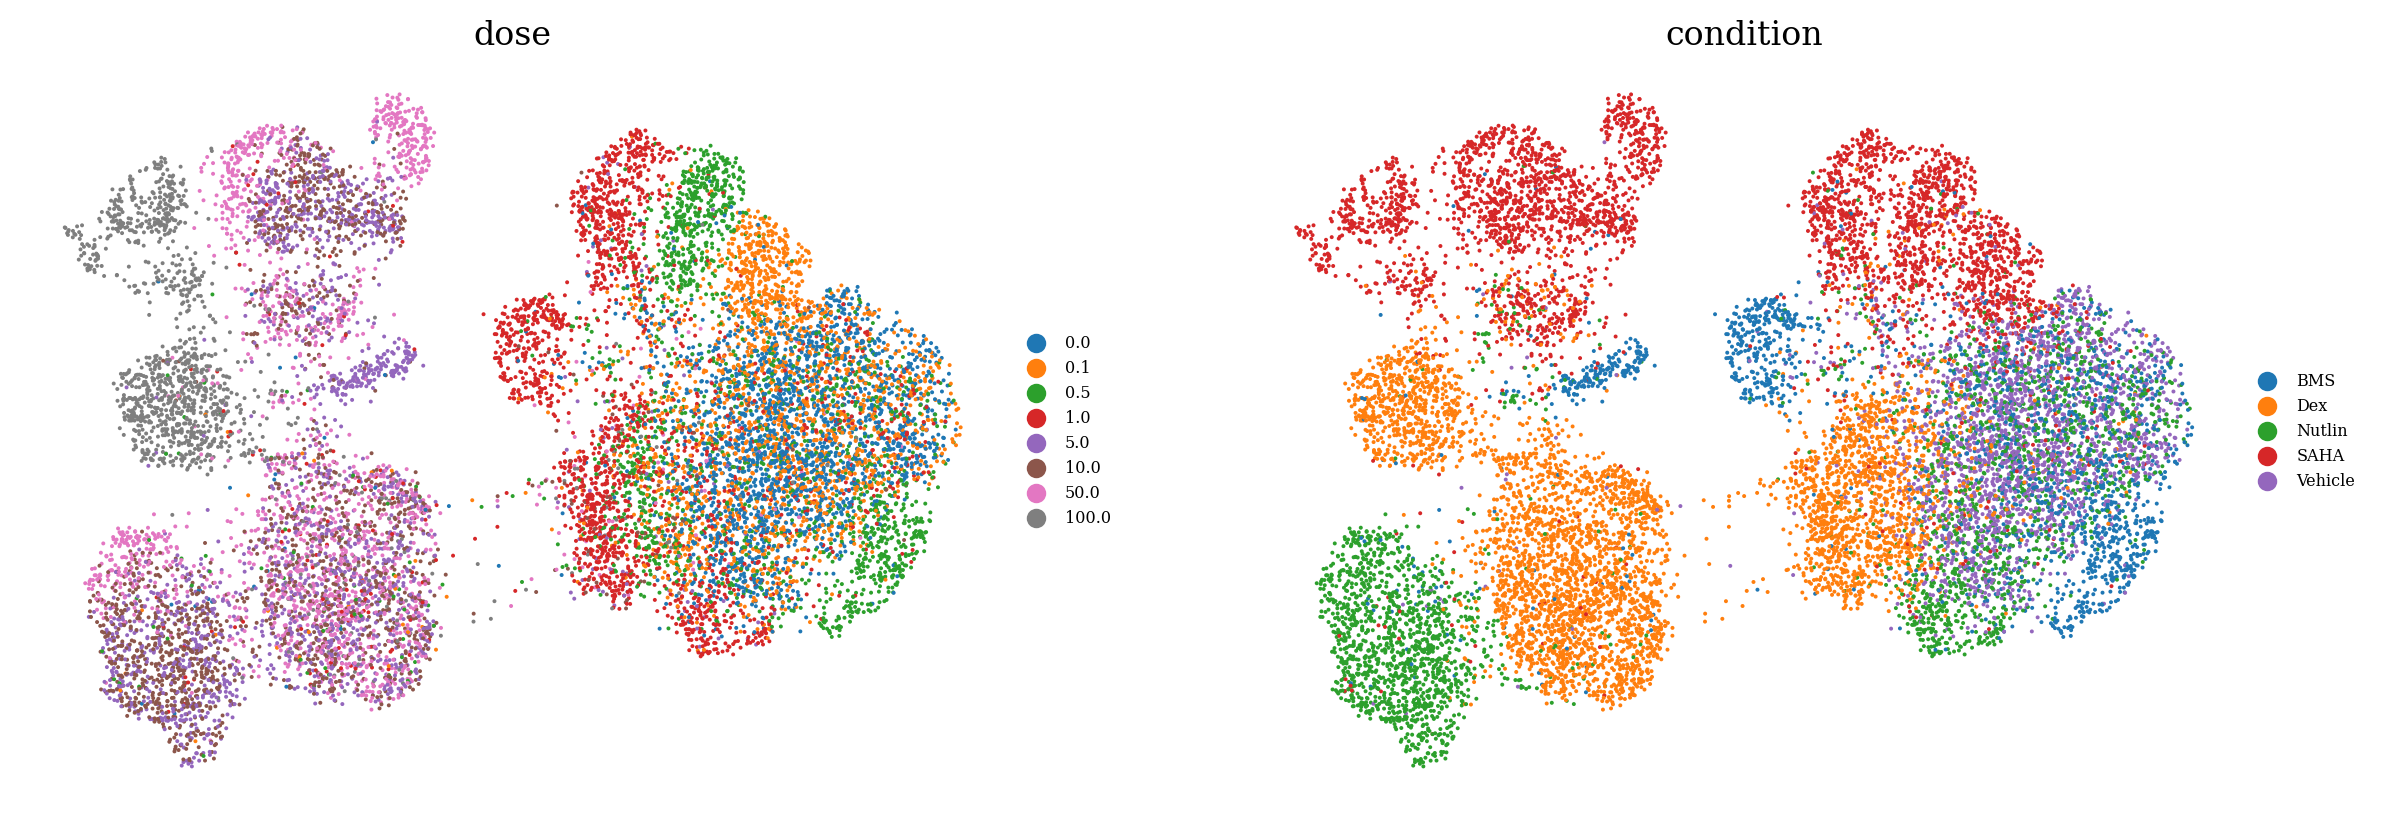

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [24]:
from tardis._disentanglementmanager import DisentanglementManager as DM

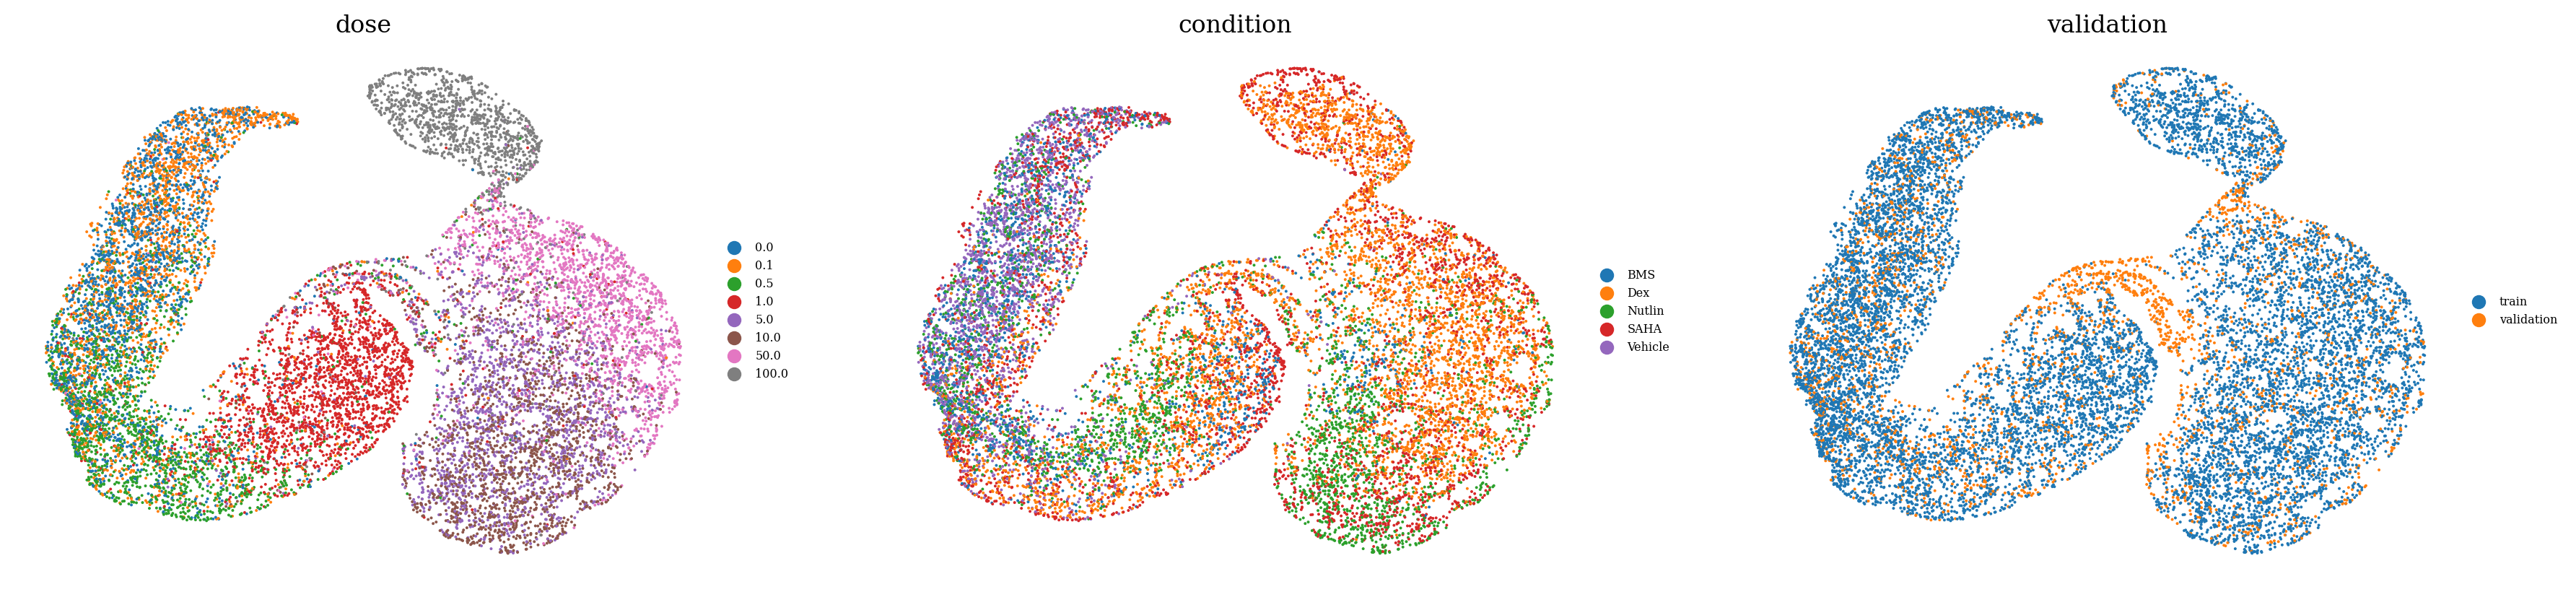

In [25]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key(obs_key).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [26]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs.loc[adata_main.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata_main.obs["dose"].astype(float).unique()))}
adata_main.obs["dose_training"] = [d[float(i)] for i in adata_main.obs["dose"]]

adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [27]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


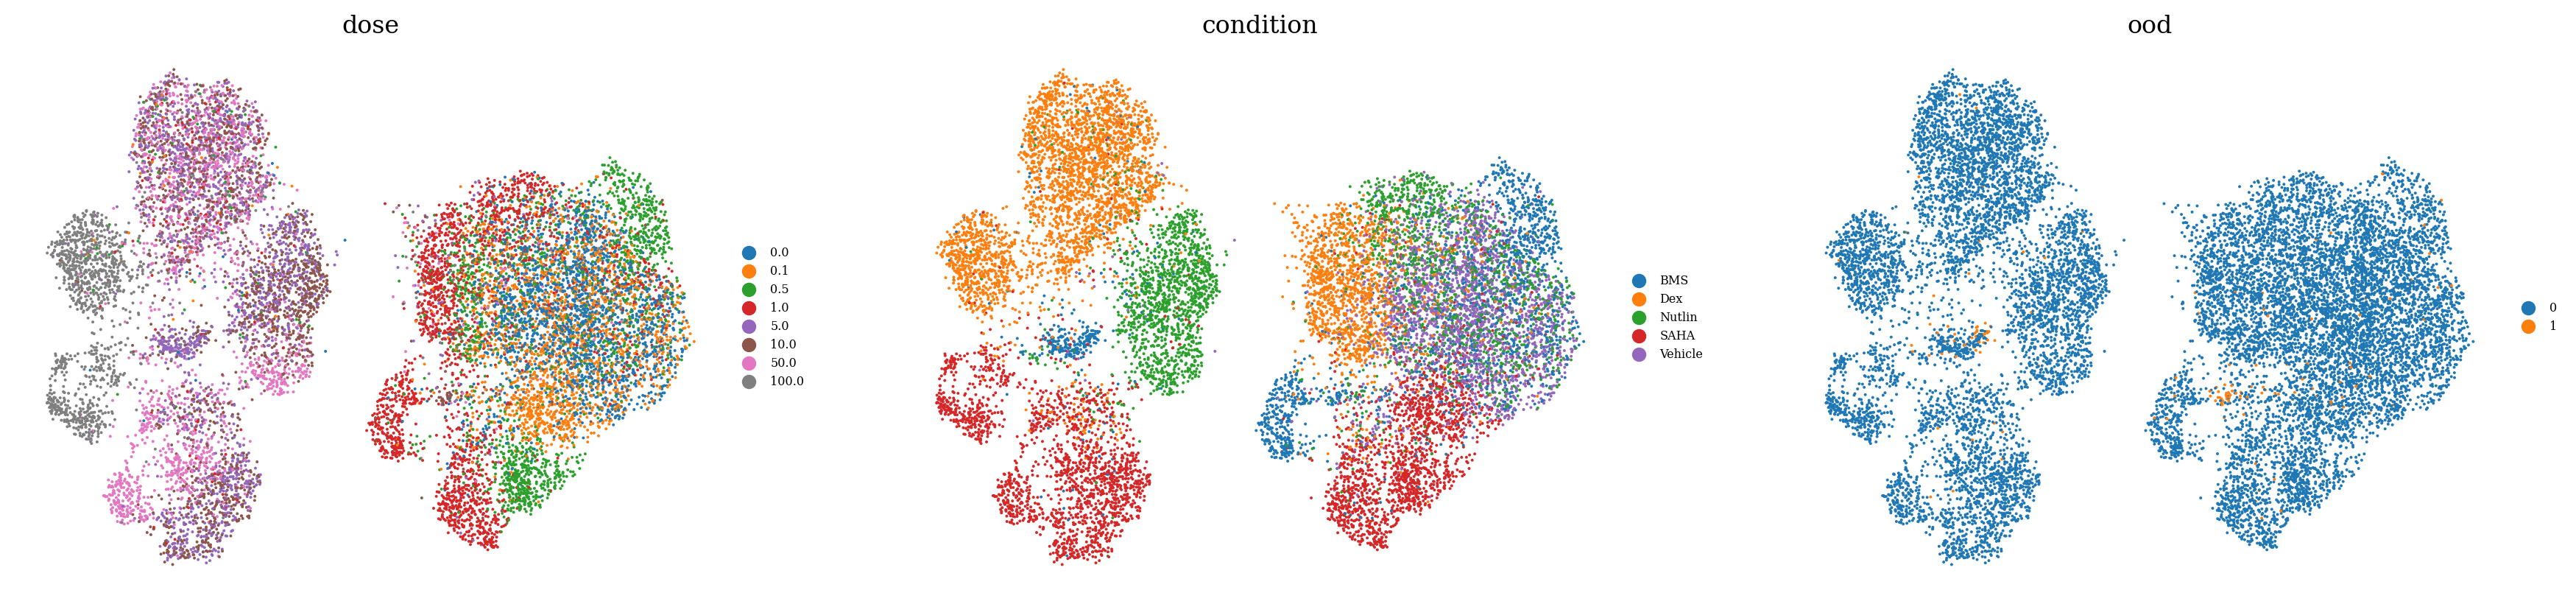

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["dose", "condition", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [29]:
k = obs_key

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)
label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


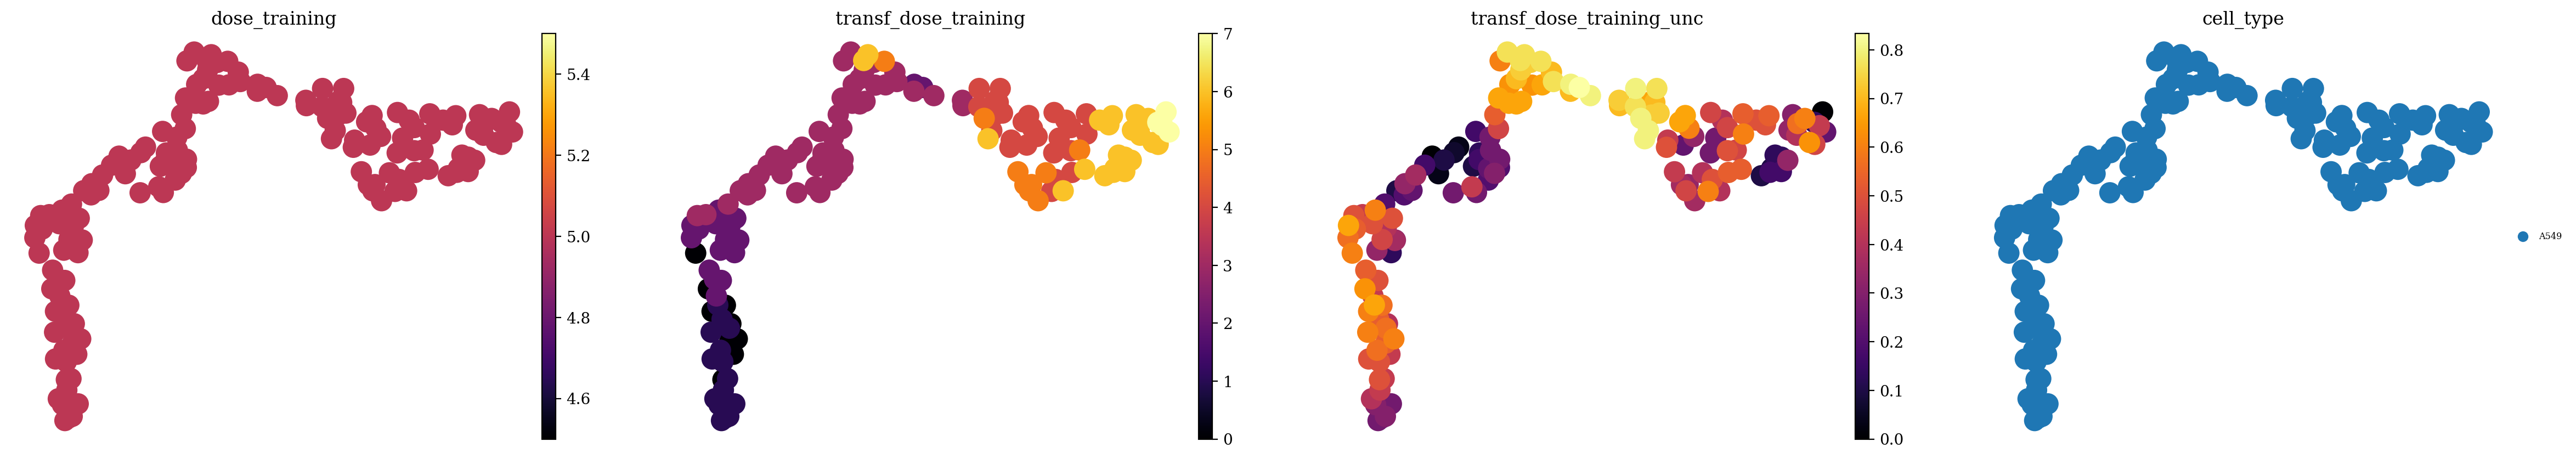

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc", "cell_type"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [31]:
metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)
metrics

{'accuracy': 0.058823529411764705,
 'precision_macro': 0.125,
 'recall_macro': 0.007352941176470588,
 'f1_score_macro': 0.013888888888888888,
 'precision_micro': 0.058823529411764705,
 'recall_micro': 0.058823529411764705,
 'f1_score_micro': 0.058823529411764705,
 'precision_weighted': 1.0,
 'recall_weighted': 0.058823529411764705,
 'f1_score_weighted': 0.1111111111111111,
 'confusion_matrix': array([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [10, 16, 18, 48, 26,  9, 22,  4],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])}

In [32]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.14658024441293632


In [33]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.12463709405171831
